# <center>CSE 546: Reinforcement Learning</center>
## <center>Assignment 3 Actor Critic</center>
### <center>Nitin Kulkarni - nitinvis@buffalo.edu</center>

In [1]:
# Imports
import cv2
import gym
from gym import spaces
import tensorflow as tf
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from operator import add
import random

In [2]:
# This ensures that all the data isn't loaded into the GPU memory at once.
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

# Disables eager execution.
tf.compat.v1.disable_eager_execution()

### The Wumpus World Environment:

<img src="files/images/Wumpus_World.jpg">

In [3]:
# Defining the Wumpus World Environment.
class WumpusWorldEnvironment(gym.Env):
    """This class implements the Wumpus World environment."""

    def __init__(self, environment_type):
        """This method initializes the environment.

        :param environment_type: - (It can take two values: 1. 'deterministic' 2. 'stochastic' indicating the type of
                                    environment.)"""

        self.environment_type = environment_type  # This indicates whether the environment is of the type deterministic
                                                  # or stochastic.
        self.observation_space = spaces.Discrete(16)  # This defines that there are 16 states in the environment.
        self.action_space = spaces.Discrete(4)  # This defines that there are 4 discrete actions that the agent can
                                                # perform.
        self.number_of_agents = 1  # This defines the number of agents in the environment.
        self.agent_pos = [0, 0]  # This defines the agent's position in the environment.
        self.breeze_pos = [[1, 0], [2, 1], [2, 3], [3, 0], [3, 2]]  # This defines the positions of breeze in the
                                                                    # environment.
        self.breeze_gold_stench_pos = [1, 2]  # This defines the position of breeze, gold, and stench in the
                                              # environment.
        self.gold_pos = [1, 2]  # This defines the position of gold in the environment.
        self.gold_quantity = 1  # This defines the quantity of gold.
        self.pit_pos = [[2, 0], [2, 2], [3, 3]]  # This defines the positions of pit in the environment.
        self.stench_pos = [[0, 1], [0, 3]]  # This defines the positions of stench in the environment.
        self.wumpus_pos = [0, 2]  # This defines the position of the Wumpus in the environment.
        self.timesteps = 0  # This defines the steps the agent has taken during an episode.
        self.max_timesteps = 10  # This defines the maximum steps the agent can take during an episode.
        self.gold_distance = self.compute_distance(self.agent_pos, self.gold_pos)  # This defines the distance of
                                                                                   # the agent from the Gold.

    def reset(self, exploring_starts=False, random_start=False):
        """This method resets the agent position and returns the state as the observation.

        :param exploring_starts: - (Boolean indicating whether the agent will start in a random position and take a
                                    random action.)
        :param random_start: - (Boolean indicating whether the agent will start in a random or fixed position.)

        :returns observation: - (Integers from 0 to 15 defining the agent's position in the environment."""

        # Creating the mapping from the possible states the agent can start in to the co-ordinates.
        coordinates_state_mapping = {12: [0, 3], 13: [1, 3], 14: [2, 3],
                                     11: [3, 2],
                                     4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
                                     0: [0, 0], 1: [1, 0], 3: [3, 0]}

        if not random_start:
            self.agent_pos = [0, 0]  # Upon resetting the environment the agent's position is set to [0, 0].
            observation = 0  # The state mapping for position [0, 0] is '0'.
        else:
            # Randomly selecting the agent's position.
            random_state = random.choice([0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14])
            self.agent_pos = coordinates_state_mapping[random_state]
            # Setting the observation to be the state occupied by the agent.
            observation = random_state

        if exploring_starts:
            # Randomly selecting the agent's position.
            random_state = random.choice([0, 1, 3, 4, 5, 6, 7, 11, 12, 13, 14])
            self.agent_pos = coordinates_state_mapping[random_state]
            # Setting the observation to be the state occupied by the agent.
            observation = random_state
            action = self.action_space.sample()  # Randomly selecting an action.
            next_state, reward, done, info = self.step(action)  # Taking an action.
            return observation, action, reward, done, info

        self.timesteps = 0  # Resetting the number of steps taken by the agent.
        self.gold_quantity = 1  # Resetting the Gold quantity to be 1.
        self.gold_distance = self.compute_distance(self.agent_pos, self.gold_pos)  # Resetting the distance of
                                                                                   # the agent to the Gold.

        return observation

    def step(self, action):
        """This function implements what happens when the agent takes a particular action. It changes the agent's
        position (While not allowing it to go out of the environment space.), maps the environment co-ordinates to a
        state, defines the rewards for the various states, and determines when the episode ends.

        :param action: - (Integer in the range 0 to 3 inclusive.)

        :returns observation: - (Integers from 0 to 15 defining the agent's position in the environment.)
                 reward: - (Integer value that's used to measure the performance of the agent.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        if self.environment_type == 'deterministic':
            # Describing the outcomes of the various possible actions.
            if action == 0:
                self.agent_pos[0] += 1  # This action causes the agent to go right.
            if action == 1:
                self.agent_pos[0] -= 1  # This action causes the agent to go left.
            if action == 2:
                self.agent_pos[1] += 1  # This action causes the agent to go up.
            if action == 3:
                self.agent_pos[1] -= 1  # This action causes the agent to go down.

        if self.environment_type == 'stochastic':
            # Describing the outcomes of the various possible actions.
            if action == 0:  # This action causes the agent to go right with 0.9 probability and remain in the same
                             # position with 0.1 probability.
                probability = random.uniform(0, 1)
                if probability > 0.1:
                    self.agent_pos[0] += 1
            if action == 1:  # This action causes the agent to go left with 0.9 probability and remain in the same
                             # position with 0.1 probability.
                probability = random.uniform(0, 1)
                if probability > 0.1:
                    self.agent_pos[0] -= 1
            if action == 2:  # This action causes the agent to go up with 0.9 probability and remain in the same
                             # position with 0.1 probability.
                probability = random.uniform(0, 1)
                if probability > 0.1:
                    self.agent_pos[1] += 1
            if action == 3:  # This action causes the agent to go down with 0.9 probability and remain in the same
                             # position with 0.1 probability.
                probability = random.uniform(0, 1)
                if probability > 0.1:
                    self.agent_pos[1] -= 1

        # Ensuring that the agent doesn't go out of the environment.
        self.agent_pos = np.clip(self.agent_pos, a_min=0, a_max=3)

        new_gold_distance = self.compute_distance(self.agent_pos, self.gold_pos)  # Computing the new distance of the
                                                                                  # agent from the Gold.

        # Giving the agent different rewards if its distance to the Gold increases, decreases or remains the same.
        if new_gold_distance > self.gold_distance:  # If the agent moves away from the Gold it gets reward -1.
            reward = -1
            self.gold_distance = new_gold_distance

        elif new_gold_distance < self.gold_distance:  # If the agent moves closer to the Gold it gets reward 1.
            reward = 1
            self.gold_distance = new_gold_distance

        else:  # If the agent's distance to the Gold doesn't change it gets reward 0.
            reward = 0

        # Creating the mapping from the co-ordinates to the state.
        coordinates_state_mapping = {'[0 3]': 12, '[1 3]': 13, '[2 3]': 14, '[3 3]': 15,
                                     '[0 2]': 8, '[1 2]': 9, '[2 2]': 10, '[3 2]': 11,
                                     '[0 1]': 4, '[1 1]': 5, '[2 1]': 6, '[3 1]': 7,
                                     '[0 0]': 0, '[1 0]': 1, '[2 0]': 2, '[3 0]': 3}

        # Setting the observation to be the state occupied by the agent.
        observation = coordinates_state_mapping[f'{self.agent_pos}']

        self.timesteps += 1  # Increasing the total number of steps taken by the agent.

        # Setting the reward to 10 if the agent reaches the gold.
        if (self.agent_pos == self.gold_pos).all() and self.gold_quantity > 0:
            self.gold_quantity -= 1
            reward = 10

        for i in range(len(self.pit_pos)):  # Setting the reward to -1 if the agent falls in the pit.
            if (self.agent_pos == self.pit_pos[i]).all():
                reward = -1

        if (self.agent_pos == self.wumpus_pos).all():  # Setting the reward to -1 if the agent is killed by Wumpus.
            reward = -1

        # The episode terminates when the agent reaches the Gold, or is killed by the Wumpus, falls into the pit, or
        # takes more than 10 steps.
        if self.gold_quantity == 0 or \
                (self.agent_pos == self.wumpus_pos).all():
            done = True
        else:
            done = False
        for i in range(len(self.pit_pos)):
            if (self.agent_pos == self.pit_pos[i]).all():
                done = True
        if self.timesteps == self.max_timesteps:
            done = True
        info = {}

        return observation, reward, done, info

    @staticmethod
    def compute_distance(x, y):
        """This method computes the distance between the old and new.

        :param x: This is the first array representing the agent position.
        :param y: This is the second array representing the goal position.

        :returns distance: The Manhattan distance between the agent and the goal."""

        distance = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return distance

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param mode:
        :param plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(10, 10))  # Initializing the figure.
        ax.set_xlim(0, 4)  # Setting the limit on the x-axis.
        ax.set_ylim(0, 4)  # Setting the limit on the y-axis.

        agent = AnnotationBbox(OffsetImage(plt.imread('./images/agent.png'), zoom=0.28),  # Plotting the agent.
                               list(map(add, self.agent_pos, [0.5, 0.5])), frameon=False)
        ax.add_artist(agent)

        for i in range(len(self.breeze_pos)):  # Plotting the breeze.

            # Plot for when the agent is not in the same position as the breeze.
            if self.breeze_pos[i][0] != self.agent_pos[0] or self.breeze_pos[i][1] != self.agent_pos[1]:
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/breeze.png'), zoom=0.28),
                                        list(map(add, self.breeze_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze)

            else:  # Plot for when the agent is in the same position as the breeze.
                agent_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_breeze.png'), zoom=0.28),
                                              list(map(add, self.breeze_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_breeze)

        # Plotting the breeze, gold and stench in a single position.
        if self.gold_quantity > 0:
            breeze_gold_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold_stench.png'), zoom=0.28),
                                                list(map(add, self.breeze_gold_stench_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(breeze_gold_stench)
        else:
            breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_stench.png'), zoom=0.28),
                                                list(map(add, self.breeze_gold_stench_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(breeze_stench)

        for i in range(len(self.pit_pos)):  # Plotting the pit.

            # Plot for when the agent is not in the same position as the pit.
            if self.pit_pos[i][0] != self.agent_pos[0] or self.pit_pos[i][1] != self.agent_pos[1]:
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/pit.png'), zoom=0.28),
                                     list(map(add, self.pit_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(pit)

            else:  # Plot for when the agent is in the same position as the pit.
                agent_dead_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_dead_pit.png'), zoom=0.28),
                                                list(map(add, self.pit_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_dead_pit)

        for i in range(len(self.stench_pos)):  # plotting the stench.

            # Plot for when the agent is not in the same position as the stench.
            if self.stench_pos[i][0] != self.agent_pos[0] or self.stench_pos[i][1] != self.agent_pos[1]:
                stench = AnnotationBbox(OffsetImage(plt.imread('./images/stench.png'), zoom=0.28),
                                        list(map(add, self.stench_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(stench)

            else:  # Plot for when the agent is in the same position as the stench.
                agent_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_stench.png'), zoom=0.28),
                                              list(map(add, self.stench_pos[i], [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_stench)

        # Plotting the Wumpus.
        # Plot for when the agent is not in the same position as the Wumpus.
        if self.agent_pos[0] != self.wumpus_pos[0] or self.agent_pos[1] != self.wumpus_pos[1]:
            wumpus = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus.png'), zoom=0.28),
                                    list(map(add, self.wumpus_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(wumpus)

        else:  # Plot for when the agent is in the same position as the Wumpus.
            wumpus = AnnotationBbox(OffsetImage(plt.imread('./images/agent_dead_wumpus.png'), zoom=0.28),
                                    list(map(add, self.wumpus_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(wumpus)

        plt.xticks([0, 1, 2, 3])  # Specifying the ticks on the x-axis.
        plt.yticks([0, 1, 2, 3])  # Specifying the ticks on the y-axis.
        plt.grid()  # Setting the plot to be of the type 'grid'.
        if plot:
            plt.show()  # Displaying the plot.
        else:
            # Preprocessing the image of the environment to be used as a state representation.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :1]
            width = int(img.shape[1] * 84 / 1000)
            height = int(img.shape[0] * 84 / 1000)
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            return preprocessed_image

### Advantage Weighted Regression Algorithm

<img src="files/images/advantage_weighted_regression.jpg">

In [4]:
class AdvantageWeightedRegression:
    """This class implements the AWR Agent."""

    def __init__(self, environment, alternate_network=False, offline_memory_size=10000, iterations=10):
        """This method initializes the AWR parameters, and calls the train, evaluate and render_actions methods.

        :param environment: This is the environment on which the agent will learn.
        :param alternate_network: Boolean indicating whether to use the second deeper network.
        :param offline_memory_size: Integer indicating the size of the offline replay memory.
        :param iterations: Integer indicating the number of iterations for which the agent will train."""

        self.environment = environment  # The environment which we need the agent to solve.
        self.alternate_network = alternate_network  # Boolean indicating whether to use the second deeper network.
        self.offline_replay_memory_size = offline_memory_size  # This specifies the length of the offline replay memory.
        self.offline_replay_memory = []  # Offline replay memory.
        self.iterations = iterations  # Number of episodes for which the agent will train.
        self.discount_factor = 0.99  # Discount factor determines the value of the future rewards.
        self.beta = 0.5  # Hyper-parameter used to calculate the exponential advantage.
        self.actor_model, self.critic_model, self.policy_model = self.neural_network()  # Creating the networks.
        self.cumulative_rewards_evaluation = []  # List containing the cumulative rewards per episode during evaluation.
        self.train()  # Calling the train method.
        self.evaluate()  # Calling the evaluate method.
        self.render_actions()  # Calling the render method.

    def neural_network(self):
        """This method builds the actor, critic and policy networks."""

        if not self.alternate_network:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common = Dense(128, activation='relu')(input_)  # Common layer for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common)  # Actor output.
            values = Dense(1, activation='linear')(common)  # Critic output.

        else:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common1 = Dense(512, activation='relu')(input_)  # Common layer 1 for the networks.
            common2 = Dense(256, activation='relu')(common1)  # Common layer 2 for the networks.
            common3 = Dense(128, activation='relu')(common2)  # Common layer 3 for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common3)  # Actor output.
            values = Dense(1, activation='linear')(common3)  # Critic output.

        def custom_loss(exponential_advantage_):
            """This method defines the custom loss wrapper function that will be used by the actor model."""

            def loss_fn(y_true, y_pred):
                # Clipping y_pred so that we don't end up taking the log of 0 or 1.
                clipped_y_pred = k.clip(y_pred, 1e-8, 1 - 1e-8)
                log_probability = y_true * k.log(clipped_y_pred)
                return k.sum(-log_probability * exponential_advantage_)
            return loss_fn

        # Instantiating the actor model.
        actor_model = Model(inputs=[input_, exponential_advantage], outputs=[probabilities])
        actor_model.compile(optimizer=Adam(), loss=custom_loss(exponential_advantage))

        # Instantiating the critic model.
        critic_model = Model(inputs=[input_], outputs=[values])
        critic_model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber())

        # Instantiating the policy model.
        policy_model = Model(inputs=[input_], outputs=[probabilities])

        return actor_model, critic_model, policy_model

    def monte_carlo_returns(self):
        """This method calculates the Monte Carlo returns given a list of rewards."""

        rewards = [item[2] for item in self.offline_replay_memory]
        monte_carlo_returns = []  # List containing the Monte-Carlo returns.
        monte_carlo_return = 0
        t = 0  # Exponent by which the discount factor is raised.

        for i in range(len(self.offline_replay_memory)):

            while not self.offline_replay_memory[i][4]:  # Execute until you encounter a terminal state.

                # Equation to calculate the Monte-Carlo return.
                monte_carlo_return += self.discount_factor ** t * rewards[i]
                i += 1  # Go to the next sample.
                t += 1  # Increasing the exponent by which the discount factor is raised.

                # Condition to check whether we have reached the end of the replay memory without the episode being
                # terminated, and if so break. (This can happen with the samples at the end of the replay memory as we
                # only store the samples till we reach the replay memory size and not till we exceed it with the episode
                # being terminated.)
                if i == len(self.offline_replay_memory):

                    # If the episode hasn't terminated but you reach the end append the Monte-Carlo return to the list.
                    monte_carlo_returns.append(monte_carlo_return)

                    # Resetting the Monte-Carlo return value and the exponent to 0.
                    monte_carlo_return = 0
                    t = 0

                    break  # Break from the loop.

            # If for one of the samples towards the end we reach the end of the replay memory and it hasn't terminated,
            # we will go back to the beginning of the for loop to calculate the Monte-Carlo return for the future
            # samples if any for whom the episode hasn't terminated.
            if i == len(self.offline_replay_memory):
                continue

            # Equation to calculate the Monte-Carlo return.
            monte_carlo_return += self.discount_factor ** t * rewards[i]

            # Appending the Monte-Carlo Return for cases where the episode terminates without reaching the end of the
            # replay memory.
            monte_carlo_returns.append(monte_carlo_return)

            # Resetting the Monte-Carlo return value and the exponent to 0.
            monte_carlo_return = 0
            t = 0

        # Normalizing the returns.
        monte_carlo_returns = np.array(monte_carlo_returns)
        monte_carlo_returns = (monte_carlo_returns - np.mean(monte_carlo_returns)) / (np.std(monte_carlo_returns)
                                                                                      + 1e-08)
        monte_carlo_returns = monte_carlo_returns.tolist()

        return monte_carlo_returns

    def replay(self):
        """This is the replay method, that is used to fit the actor and critic networks and synchronize the weights
            between the actor and policy networks."""

        states = [item[0] for item in self.offline_replay_memory]
        states = np.asarray(states).reshape(-1, self.environment.observation_space.n)

        actions = [tf.keras.utils.to_categorical(item[1], self.environment.action_space.n).tolist()
                   for item in self.offline_replay_memory]

        monte_carlo_returns = self.monte_carlo_returns()

        critic_values = self.critic_model.predict(states).flatten()

        exponential_advantages = [np.exp(1/self.beta * (monte_carlo_returns[i] - critic_values[i]))
                      for i in range(len(self.offline_replay_memory))]

        # Fitting the actor model.
        self.actor_model.fit([states, np.asarray(exponential_advantages)], np.asarray(actions),
                             batch_size=16, epochs=1, verbose=0)

        # Syncing the weights between the actor and policy models.
        self.policy_model.set_weights(self.actor_model.get_weights())

        # Fitting the critic model.
        self.critic_model.fit(states, np.asarray(monte_carlo_returns), batch_size=16, epochs=1, verbose=0)

    def train(self):
        """This method performs the agent training."""

        # Environment states for indirectly plotting the policy table.
        test_states = [x for x in range(self.environment.observation_space.n)]
        test_states = tf.keras.utils.to_categorical(test_states)

        # Printing the initial policy table.
        policy_table = self.policy_model.predict(
            np.asarray(test_states).reshape(-1, self.environment.observation_space.n))
        for terminal_state in [2, 8, 9, 10, 15]:  # The list represents terminal states.
            policy_table[terminal_state] = 0
        print('\nInitial Policy Table:\n', policy_table)

        average_reward_per_episode_per_iteration = []
        cumulative_average_rewards_per_episode_per_iteration = []
        gold_reached = []  # List containing the percentage of episodes in which the agent reached the Gold per
                           # iteration.

        for iteration in range(self.iterations):

            self.offline_replay_memory = []  # Resetting the offline replay memory to be empty.
            total_reward_iteration = 0  # Total reward acquired in this iteration.
            gold = 0  # Initializing the number of episodes in which the agent reached the Gold to be 0.
            episodes = 0  # Initializing the number of episodes in this iteration to be 0.

            while len(self.offline_replay_memory) < self.offline_replay_memory_size:

                # Resetting the environment and starting from a random position.
                state = self.environment.reset(random_start=True)
                # One-hot encoding.
                state = tf.keras.utils.to_categorical(state, self.environment.observation_space.n)
                done = False  # Initializing the done parameter which indicates whether the environment has terminated
                              # or not to False.
                episodes += 1  # Increasing the number of episodes in this iteration.

                while not done:
                    # Selecting an action according to the predicted action probabilities.
                    action_probabilities = (self.policy_model.predict(
                        np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])
                    action = np.random.choice(self.environment.action_space.n, p=action_probabilities)

                    # Taking an action.
                    next_state, reward, done, info = self.environment.step(action)
                    # One-hot encoding.
                    next_state = tf.keras.utils.to_categorical(next_state, self.environment.observation_space.n)

                    # Incrementing the Gold counter when the agent reaches the Gold.
                    if self.environment.agent_pos[0] == self.environment.gold_pos[0] and \
                            self.environment.agent_pos[1] == self.environment.gold_pos[1]:
                        gold += 1

                    # Incrementing the total reward.
                    total_reward_iteration += reward

                    # Appending the state, action, reward, next state and done to the replay memory.
                    self.offline_replay_memory.append([state, action, reward, next_state, done])

                    state = next_state  # Setting the current state to be equal to the next state.

                    # This condition ensures that we don't append more values than the size of the replay memory.
                    if len(self.offline_replay_memory) == self.offline_replay_memory_size:
                        break

            # Calculating the average reward per episode for this iteration.
            average_reward_per_episode = total_reward_iteration / episodes
            average_reward_per_episode_per_iteration.append(average_reward_per_episode)

            # Appending the cumulative reward.
            if len(cumulative_average_rewards_per_episode_per_iteration) == 0:
                cumulative_average_rewards_per_episode_per_iteration.append(average_reward_per_episode)
            else:
                cumulative_average_rewards_per_episode_per_iteration.append(
                    average_reward_per_episode + cumulative_average_rewards_per_episode_per_iteration[iteration - 1])

            # Calculating the percentage of episodes in which the agent reached the Gold.
            percentage_gold_reached = gold / episodes * 100
            gold_reached.append(percentage_gold_reached)

            # Calling the replay method.
            self.replay()

            # Printing the policy table every 5 iterations.
            if (iteration + 1) % 5 == 0:
                policy_table = self.policy_model.predict(
                    np.asarray(test_states).reshape(-1, self.environment.observation_space.n))
                for terminal_state in [2, 8, 9, 10, 15]:  # The list represents terminal states.
                    policy_table[terminal_state] = 0
                print(f'\nPolicy table after {iteration + 1} iterations:\n', policy_table)

        # Calling the plots method to plot the reward dynamics.
        self.plots(average_reward_per_episode_per_iteration, cumulative_average_rewards_per_episode_per_iteration,
                   gold_reached, plot_gold_reached=True, iterations=True)

    def evaluate(self):
        """This method evaluates the performance of the agent after it has finished training."""

        total_steps, total_penalties = 0, 0  # Initializing the total steps taken and total penalties incurred
                                             # across all episodes.
        episodes = 100  # Number of episodes for which we are going to test the agent's performance.
        rewards_per_episode = []  # Sum of immediate rewards during the episode.
        gold = 0  # Counter to keep track of the episodes in which the agent reaches the Gold.

        for episode in range(episodes):
            state = self.environment.reset(random_start=True)  # Resetting the environment for every new episode.
            # One-hot encoding.
            state = tf.keras.utils.to_categorical(state, self.environment.observation_space.n)
            steps, penalties = 0, 0  # Initializing the steps taken, and penalties incurred in this episode.
            done = False  # Initializing the done parameter indicating the episode termination to be False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                # Always choosing the greedy action.
                action = np.argmax(self.policy_model.predict(
                    np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])

                # Taking the greedy action.
                next_state, reward, done, info = self.environment.step(action)
                # One-hot encoding.
                next_state = tf.keras.utils.to_categorical(next_state, self.environment.observation_space.n)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward acquired
                                                # during the episode.

                # Incrementing the Gold counter when the agent reaches the Gold.
                if self.environment.agent_pos[0] == self.environment.gold_pos[0] and \
                        self.environment.agent_pos[1] == self.environment.gold_pos[1]:
                    gold += 1

                if reward == -1:  # Increasing the penalties incurred in this episode by checking the reward.
                    penalties += 1

                    # If the agent gets the Gold in 100 % of the episodes along with a small average penalty value per
                    # episode (~ 0.09 (1/11 where it's the one state 'i.e., state 11' out of a total of 11 possible
                    # states the agent can start in)) it's not that the agent doesn't learn the optimal policy but it
                    # simply arises from the fact that when the agent starts in state 11 it has to go down which
                    # increases the distance to the Gold and it receives a penalty but it has still learned that getting
                    # to the Gold is the optimal action.

                    # If you want to see why we get a penalty even though the environment is solved uncomment the
                    # following lines of code:

                    # print(f'\nPenalty Acquired on: State: {np.argmax(state)}, Action: {action}, Reward: {reward}, '
                    #       f'Next State: {np.argmax(next_state)}, Done: {done}')

                state = next_state  # Setting the current state to the next state.

                steps += 1  # Increasing the number of steps taken in this episode.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_evaluation) == 0:
                self.cumulative_rewards_evaluation.append(total_reward_episode)
            else:
                self.cumulative_rewards_evaluation.append(
                    total_reward_episode + self.cumulative_rewards_evaluation[episode - 1])

            total_penalties += penalties  # Adding the penalties incurred in this episode to the total penalties
                                          # across all the episodes.

            total_steps += steps  # Adding the steps taken in this episode to the total steps taken across all episodes

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nEvaluation of agent's performance across {episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / episodes}")
        print(f"Average penalties incurred per episode: {total_penalties / episodes}")
        print(f"Percentage of episodes in which the agent reaches the Gold: {(gold / episodes) * 100} %")

        # Calling the plots method to plot the reward dynamics.
        self.plots(rewards_per_episode, self.cumulative_rewards_evaluation)

    def render_actions(self):
        # Rendering the actions taken by the agent after learning.
        state = self.environment.reset(random_start=True)  # Resetting the environment for a new episode.
        # One-hot encoding.
        state = tf.keras.utils.to_categorical(state, self.environment.observation_space.n)
        self.environment.render(plot=True)  # Rendering the environment.
        done = False  # Initializing the done parameter indicating the episode termination to be False.

        while not done:
            # Always choosing the greedy action.
            action = np.argmax(self.policy_model.predict(
                np.asarray(state).reshape(-1, self.environment.observation_space.n))[0])

            # Taking the greedy action.
            next_state, reward, done, info = self.environment.step(action)
            # One-hot encoding.
            next_state = tf.keras.utils.to_categorical(next_state, self.environment.observation_space.n)

            self.environment.render(plot=True)  # Rendering the environment.
            state = next_state  # Setting the current state to the next state.

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, gold_reached=None, plot_gold_reached=False, iterations=False):
        """This method plots the reward dynamics and epsilon decay.

        :param iterations: Boolean indicating that we are plotting for iterations and not episodes.
        :param gold_reached: List containing the percentage of episodes in which the agent reached the Gold.
        :param plot_gold_reached: Boolean indicating whether or not to plot gold_reached.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode."""

        plt.figure(figsize=(20, 10))
        plt.plot(rewards_per_episode, 'ro')
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Average Reward Per Episode')
            plt.title('Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rewards Per Episode (During Evaluation)')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.plot(cumulative_rewards)
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Cumulative Average Reward Per Episode')
            plt.title('Cumulative Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Cumulative Reward Per Episode')
            plt.title('Cumulative Rewards Per Episode (During Evaluation)')
        plt.show()

        if plot_gold_reached:
            plt.figure(figsize=(20, 10))
            plt.plot(gold_reached)
            plt.xlabel('Iterations')
            plt.ylabel('Percentage')
            plt.title('Percentage of Episodes in Which the Agent Reached the Gold.')
            plt.show()

In [5]:
# Instantiating the deterministic and stochastic Wumpus World environment.
deterministic_wumpus_world_environment = WumpusWorldEnvironment(environment_type='deterministic')
stochastic_wumpus_world_environment = WumpusWorldEnvironment(environment_type='stochastic')

#### AWR on Deterministic Wumpus World Environment

Version 1:

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Initial Policy Table:
 [[0.2475595  0.28194344 0.211986   0.258511  ]
 [0.26009518 0.26035762 0.20633565 0.27321157]
 [0.         0.         0.         0.        ]
 [0.26692635 0.2768312  0.20450872 0.2517337 ]
 [0.24243496 0.27721098 0.20888399 0.27147013]
 [0.25083306 0.29777044 0.2083676  0.24302891]
 [0.26419142 0.2465585  0.21999371 0.2692564 ]
 [0.26752567 0.2605131  0.22398934 0.24797192]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.23568882 0.26107758 0.24489304 0.25834057]
 [0.28664702 0.2228566  0.23368599 0.25681037]
 [0.24225862 0.2662913  0.22694547 0.26450458]
 [0.24481621 0.25389162 0.23904127 0.2622509 ]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.39085287 0.18305129 0.27934778 0.14674802]
 [0.0231941 

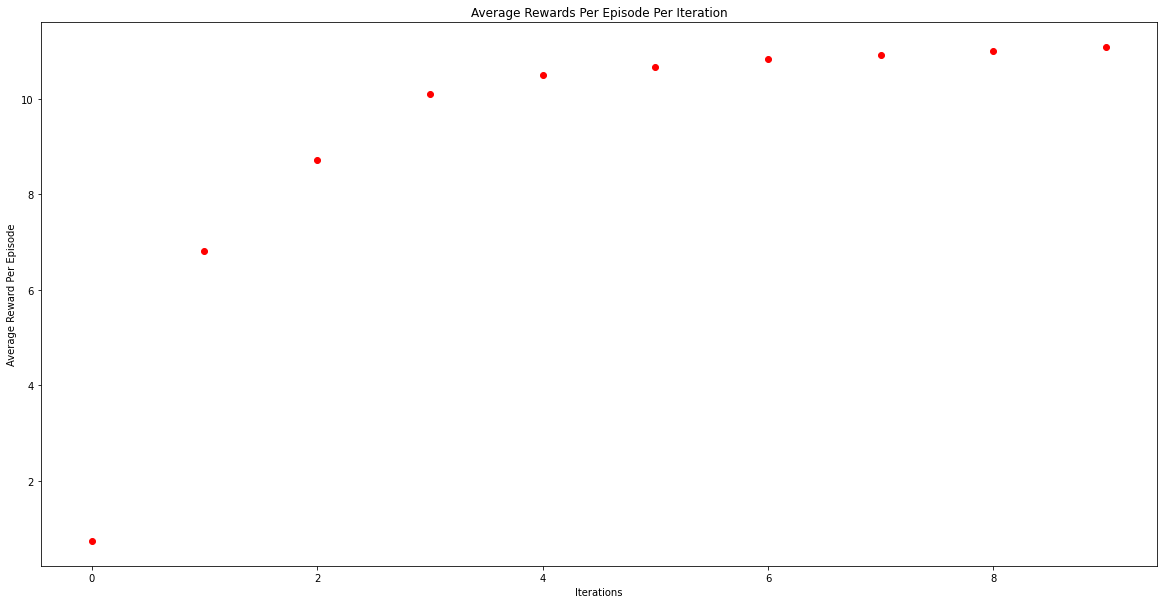

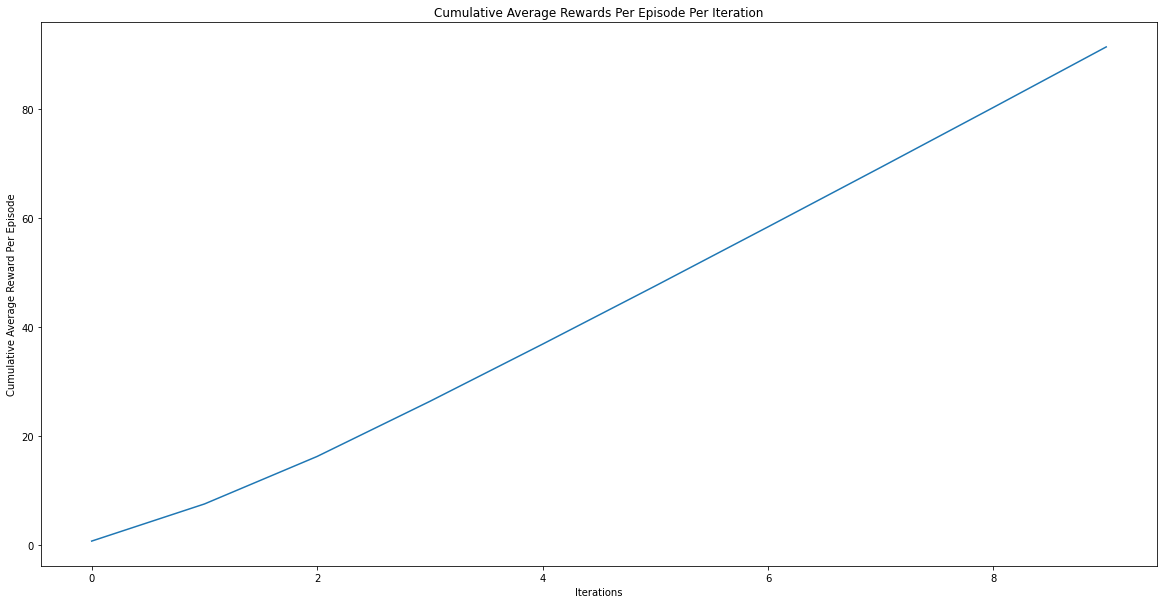

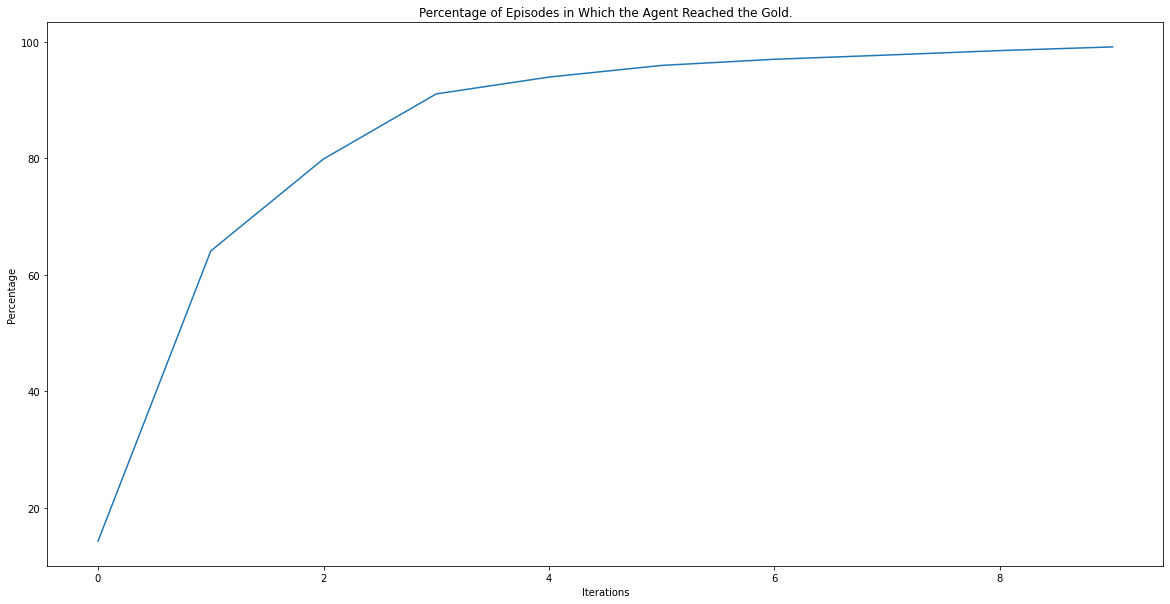


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 2.33
Average penalties incurred per episode: 0.1
Percentage of episodes in which the agent reaches the Gold: 100.0 %


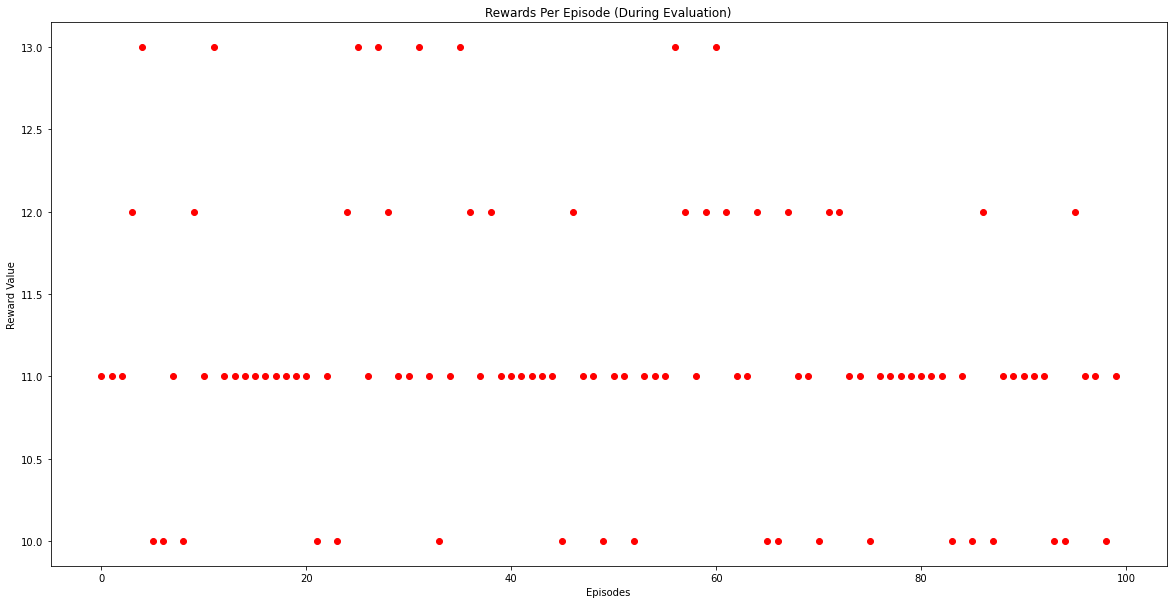

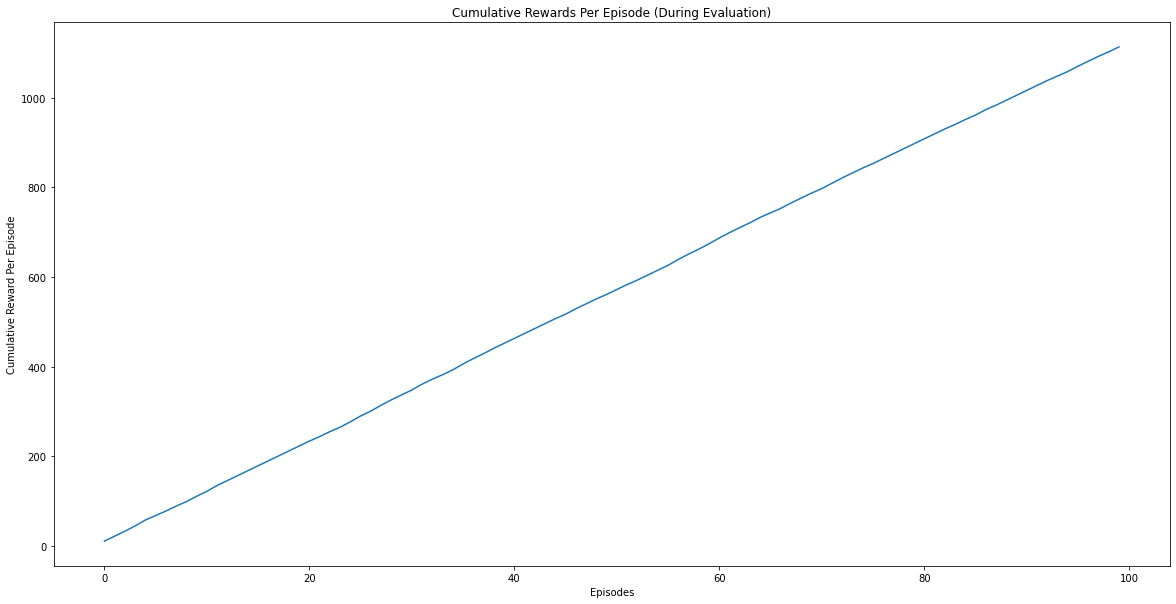

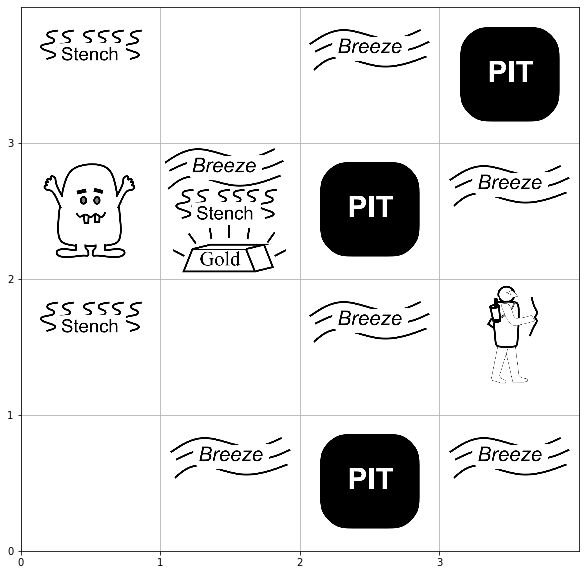

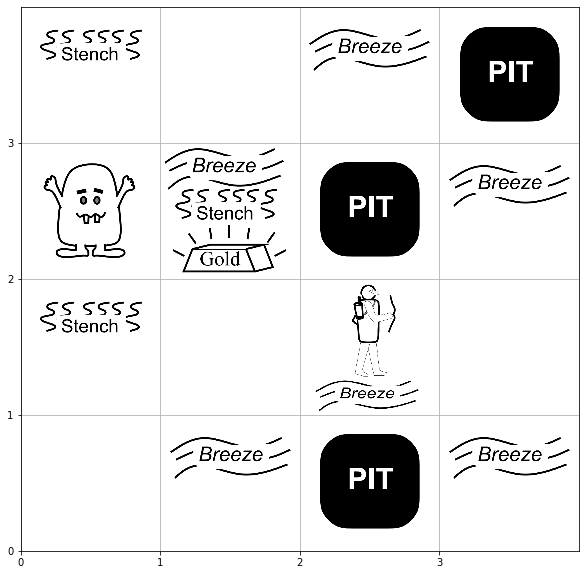

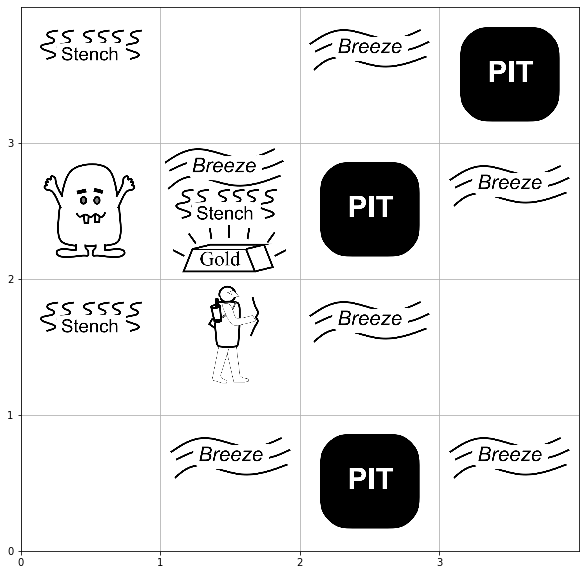

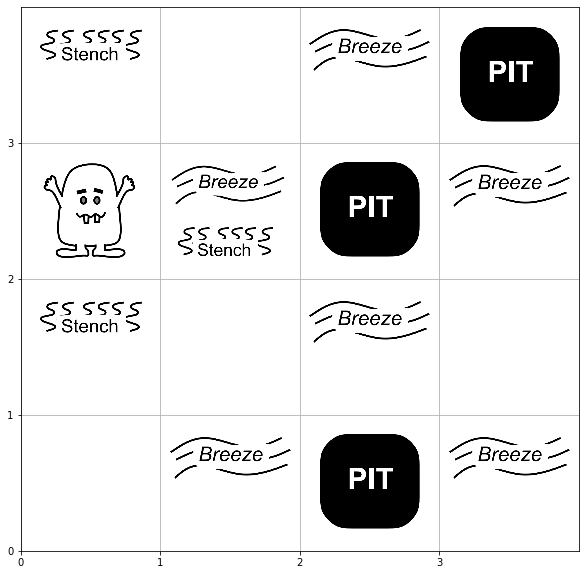

In [6]:
print('Version 1:\n')
AdvantageWeightedRegression(deterministic_wumpus_world_environment, alternate_network=False, offline_memory_size=10000,
                            iterations=10)

Version 2:


Initial Policy Table:
 [[0.25093982 0.2519556  0.2525735  0.24453107]
 [0.24184848 0.25572363 0.25674373 0.24568418]
 [0.         0.         0.         0.        ]
 [0.24105571 0.24741052 0.26143938 0.25009435]
 [0.24446425 0.2549752  0.259683   0.24087755]
 [0.23068225 0.2655788  0.25081098 0.25292802]
 [0.24233238 0.24552019 0.25774586 0.25440153]
 [0.23933834 0.25709137 0.27530017 0.22827011]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.23314017 0.25280246 0.26400957 0.25004777]
 [0.23956454 0.24969608 0.2560248  0.2547146 ]
 [0.22588167 0.25776508 0.26586884 0.25048438]
 [0.23638295 0.2547943  0.25953734 0.2492854 ]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.3492615  0.19066468 0.28284752 0.1772263 ]
 [0.10321002 0.21595626 0.43990728 0.24092638]
 [0.         0.         0.         0.        ]
 [0.07394183 0.05832102 0.7239058  

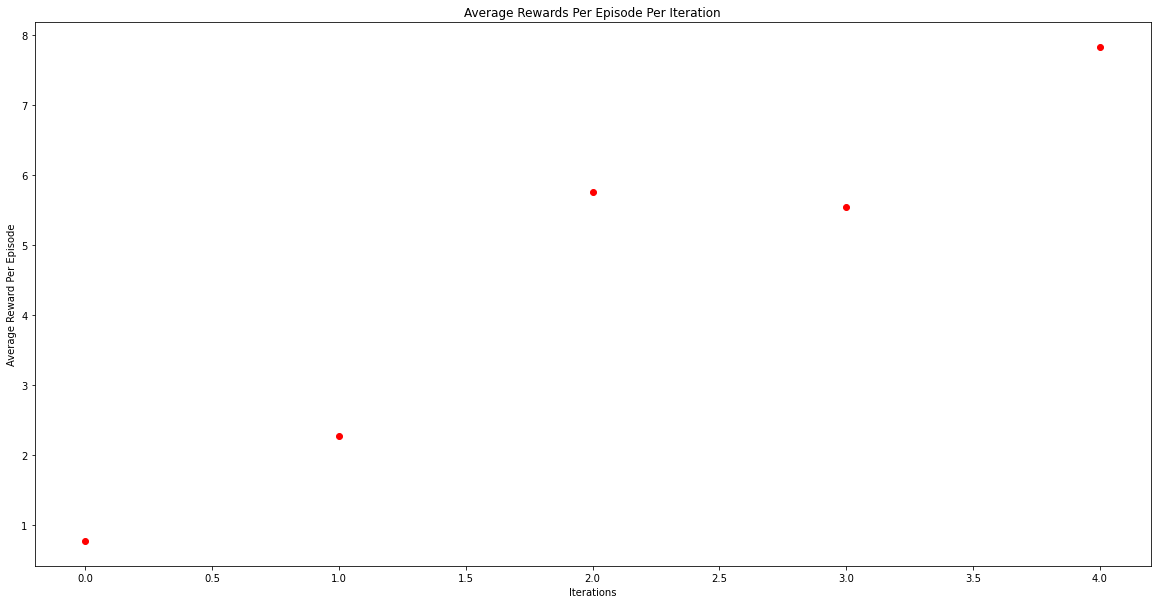

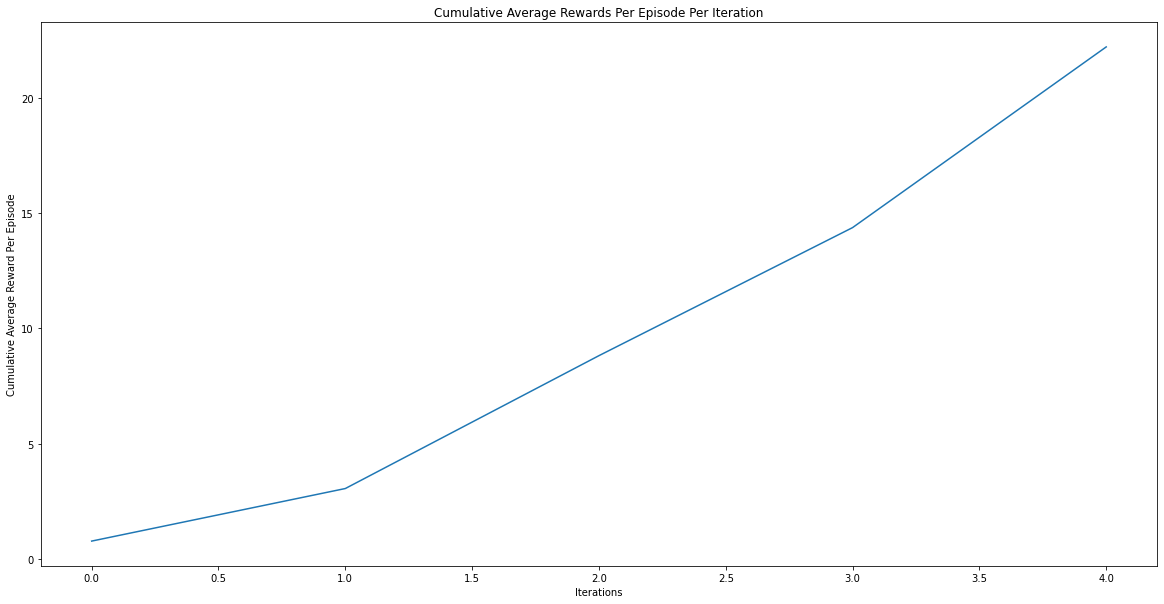

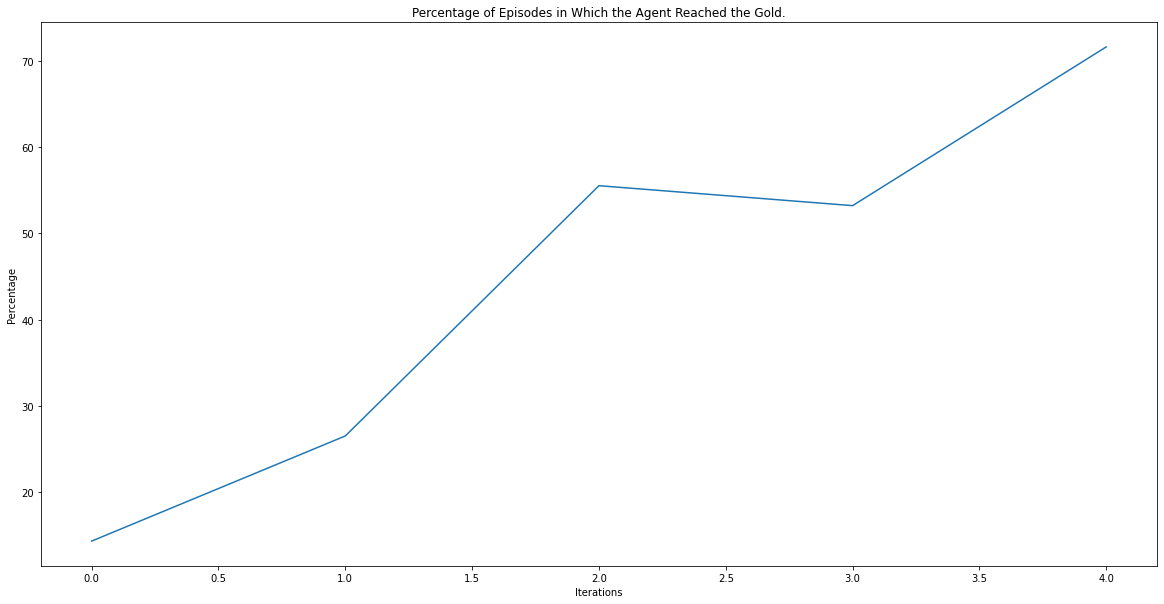


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 2.32
Average penalties incurred per episode: 0.11
Percentage of episodes in which the agent reaches the Gold: 100.0 %


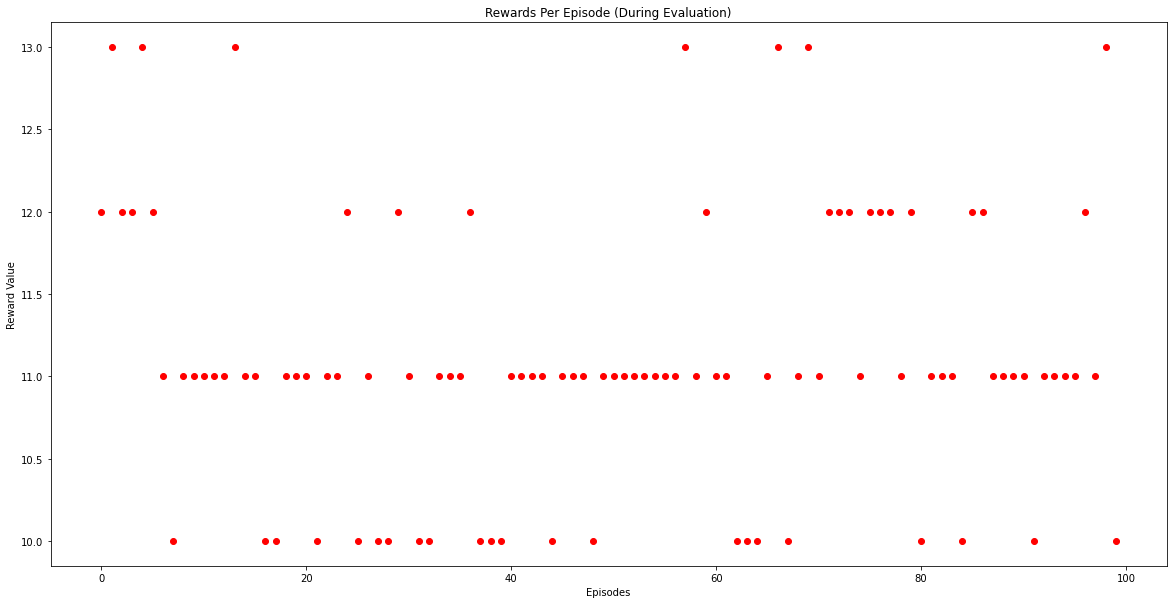

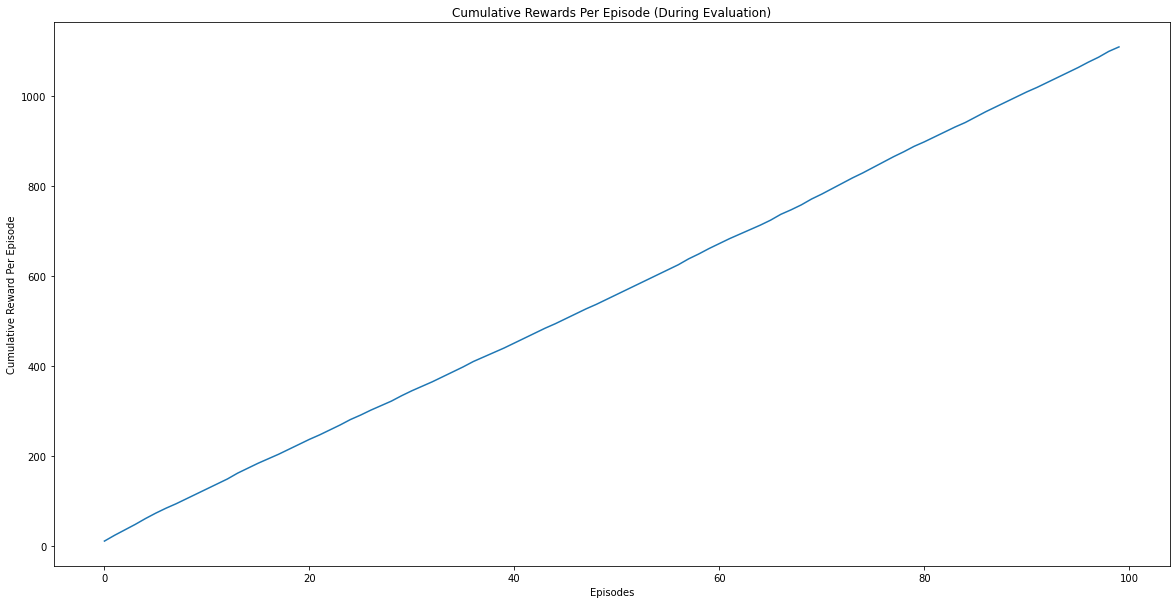

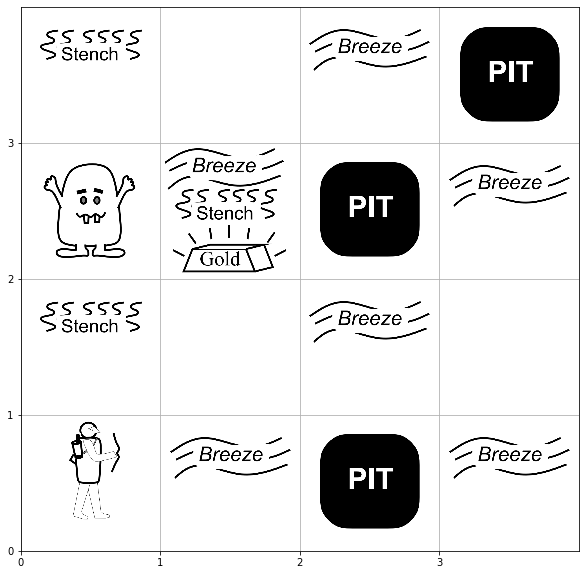

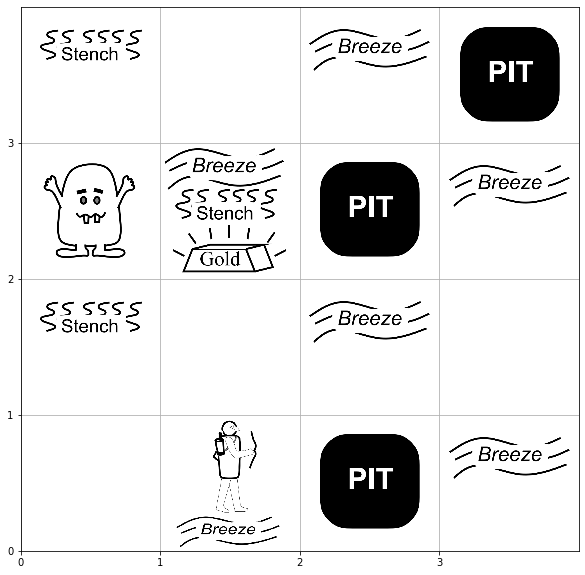

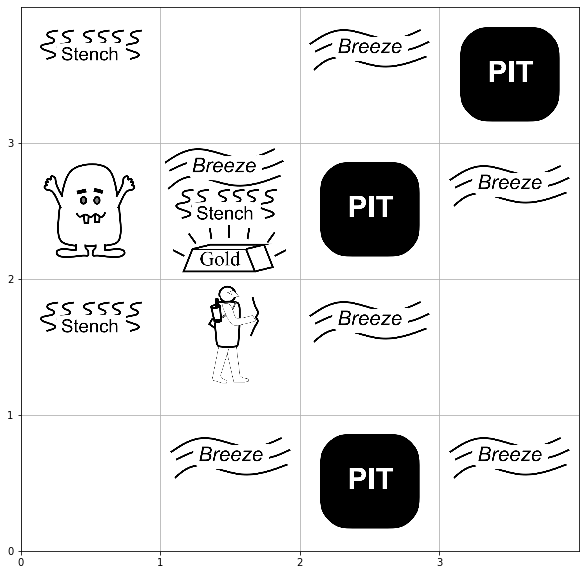

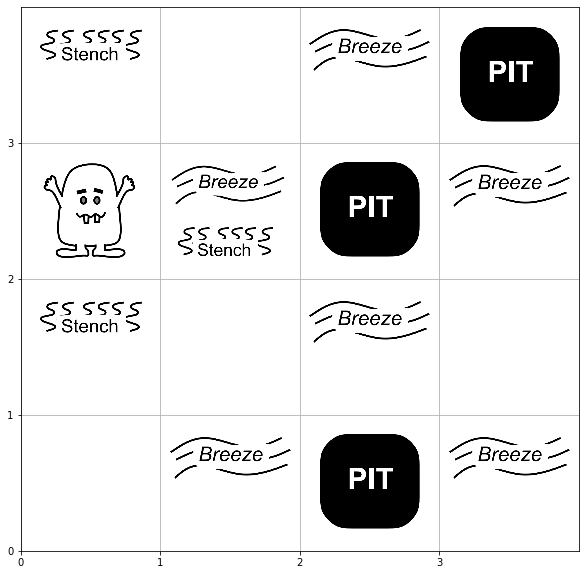

In [7]:
print('Version 2:\n')
AdvantageWeightedRegression(deterministic_wumpus_world_environment, alternate_network=True, offline_memory_size=1000,
                            iterations=5)

Version 3:


Initial Policy Table:
 [[0.2550544  0.25554556 0.25127304 0.238127  ]
 [0.25612205 0.24996759 0.249414   0.24449636]
 [0.         0.         0.         0.        ]
 [0.24423853 0.25482166 0.26356074 0.23737907]
 [0.24144319 0.25119665 0.25478137 0.25257882]
 [0.25309008 0.25679642 0.25640872 0.23370476]
 [0.25273716 0.25262403 0.2556473  0.23899147]
 [0.24332489 0.2539766  0.25750285 0.24519566]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.24647425 0.26381618 0.24799982 0.2417098 ]
 [0.25228587 0.25600502 0.2519767  0.23973243]
 [0.26054677 0.24783687 0.25388563 0.23773073]
 [0.25859416 0.24851659 0.25741634 0.2354729 ]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.19229372 0.19923617 0.5627742  0.04569592]
 [0.06514508 0.11112141 0.763817   0.0599165 ]
 [0.         0.         0.         0.        ]
 [0.16844608 0.17942719 0.5930738  

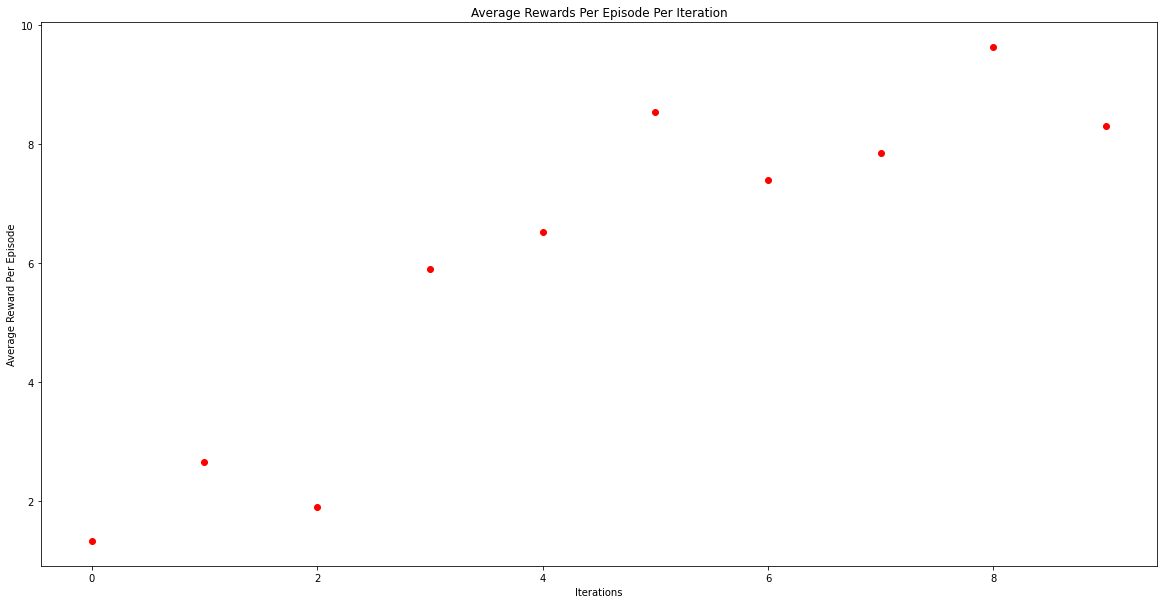

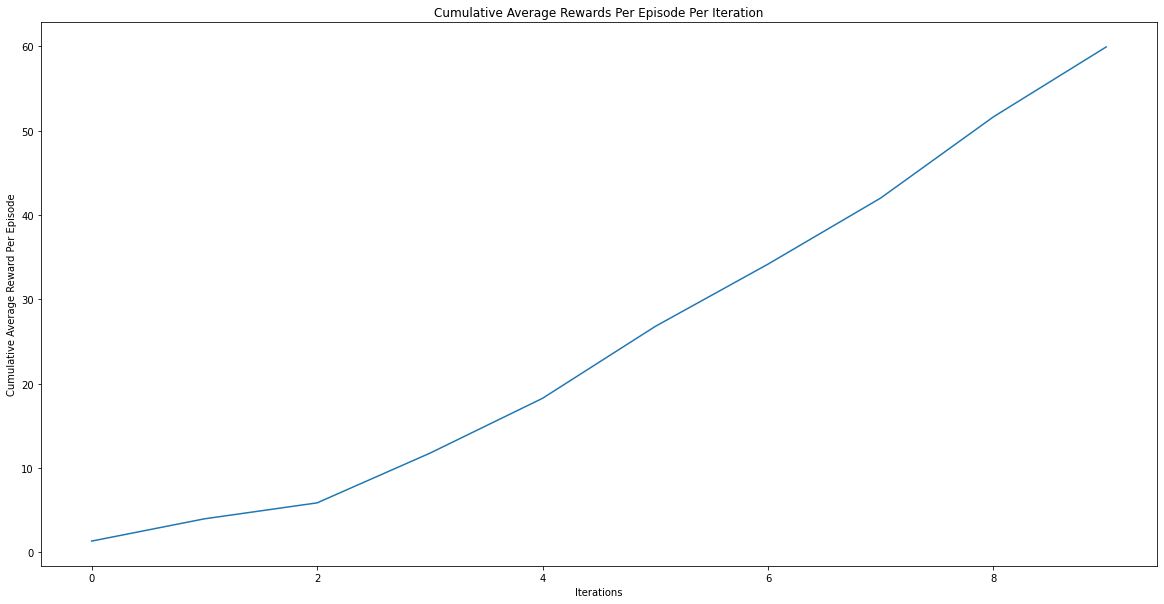

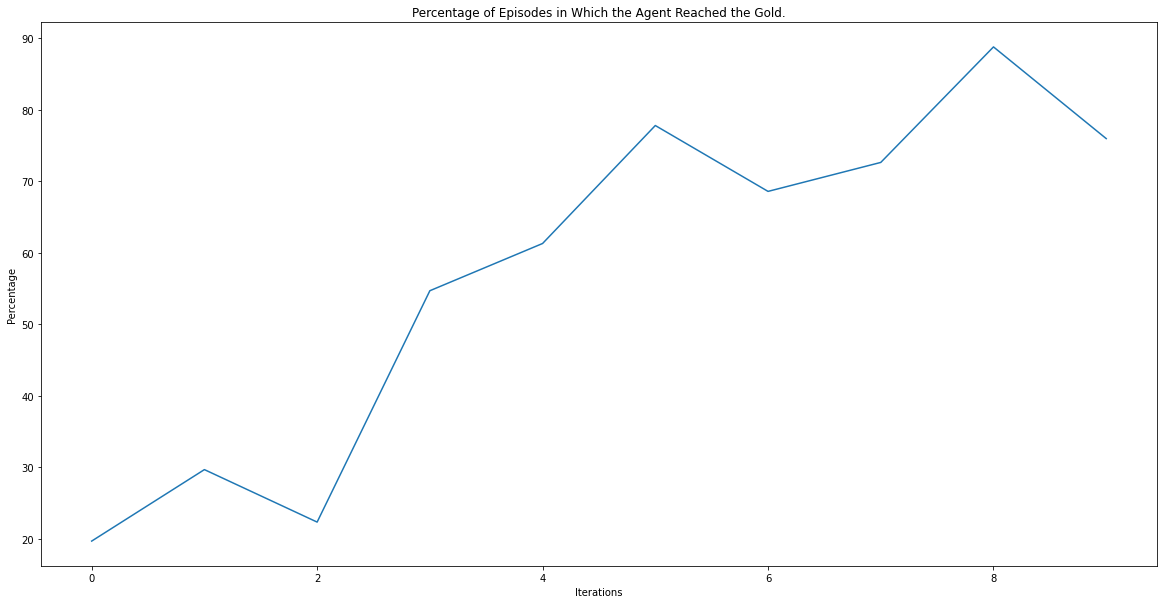


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 2.34
Average penalties incurred per episode: 0.06
Percentage of episodes in which the agent reaches the Gold: 100.0 %


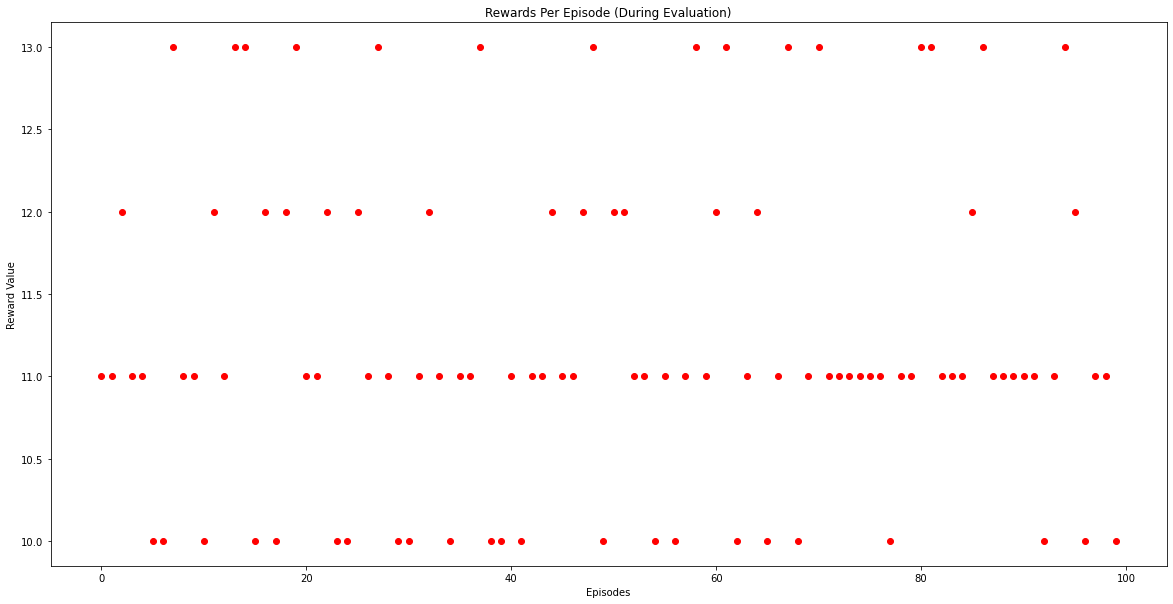

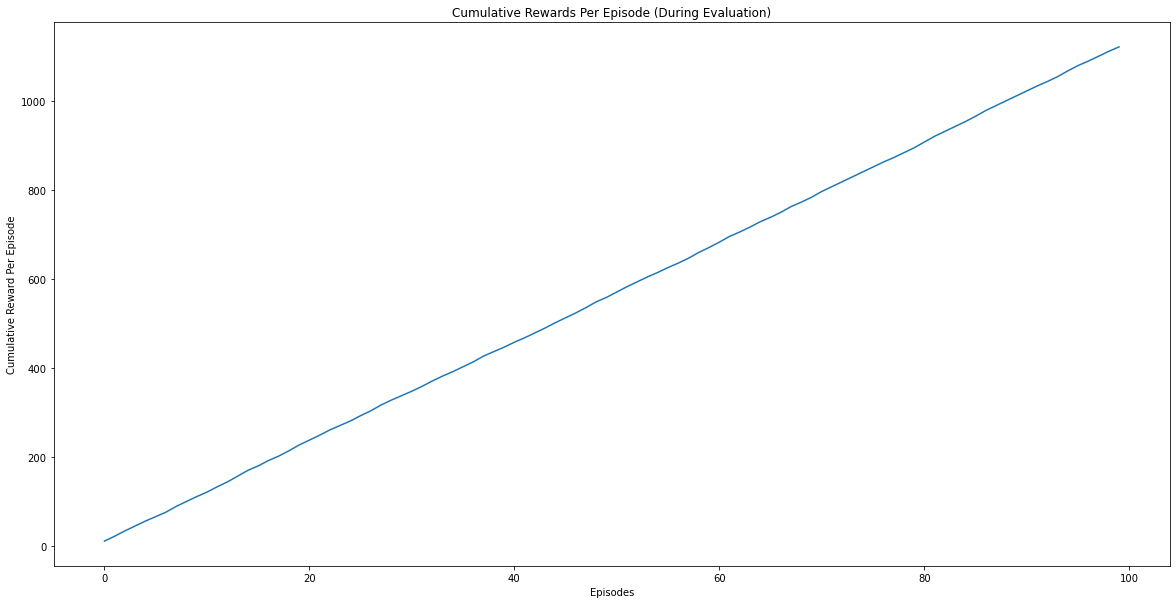

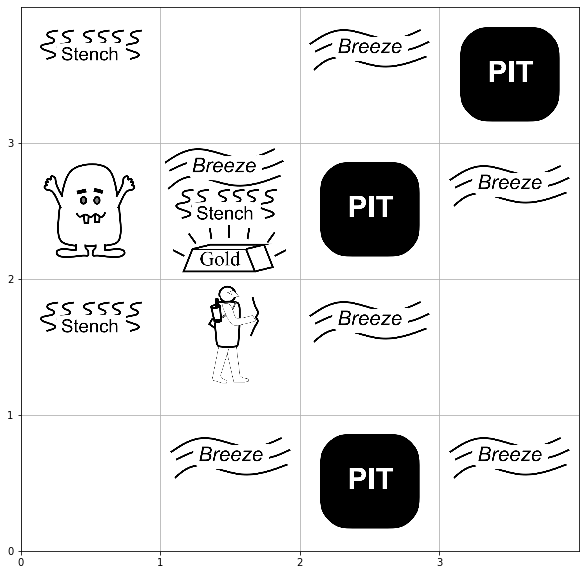

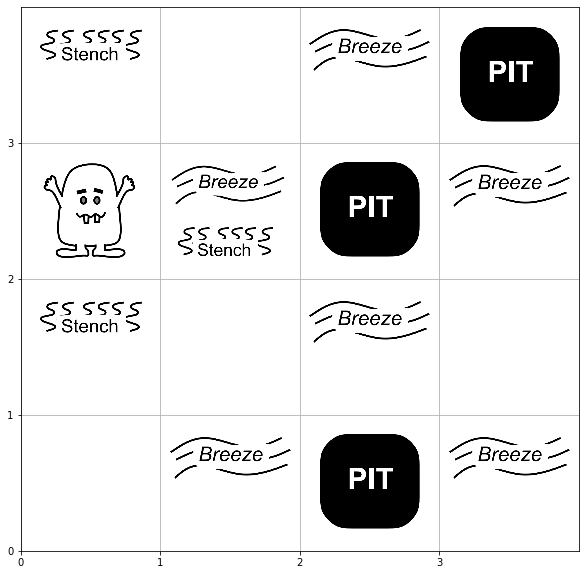

In [8]:
print('Version 3:\n')
AdvantageWeightedRegression(deterministic_wumpus_world_environment, alternate_network=True, offline_memory_size=250,
                            iterations=10)

#### AWR on Deterministic Wumpus World Environment

Version 1:


Initial Policy Table:
 [[0.24903779 0.27623785 0.26463875 0.21008565]
 [0.24281587 0.26246253 0.28278118 0.21194041]
 [0.         0.         0.         0.        ]
 [0.23532763 0.26134765 0.27223822 0.23108646]
 [0.24580029 0.2638255  0.26649287 0.22388133]
 [0.24033631 0.25909072 0.28075078 0.2198222 ]
 [0.23236601 0.24190634 0.27285385 0.25287384]
 [0.22477996 0.24349318 0.28944233 0.2422845 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.25280848 0.22105245 0.30056578 0.22557327]
 [0.2379752  0.22076811 0.2990123  0.24224445]
 [0.23264906 0.2345935  0.2845485  0.2482089 ]
 [0.24302545 0.27279064 0.25160715 0.23257676]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.35997105 0.12294776 0.345038   0.17204325]
 [0.02685006 0.07081721 0.8067535  0.09557921]
 [0.         0.         0.         0.        ]
 [0.09178103 0.01775176 0.8194295  

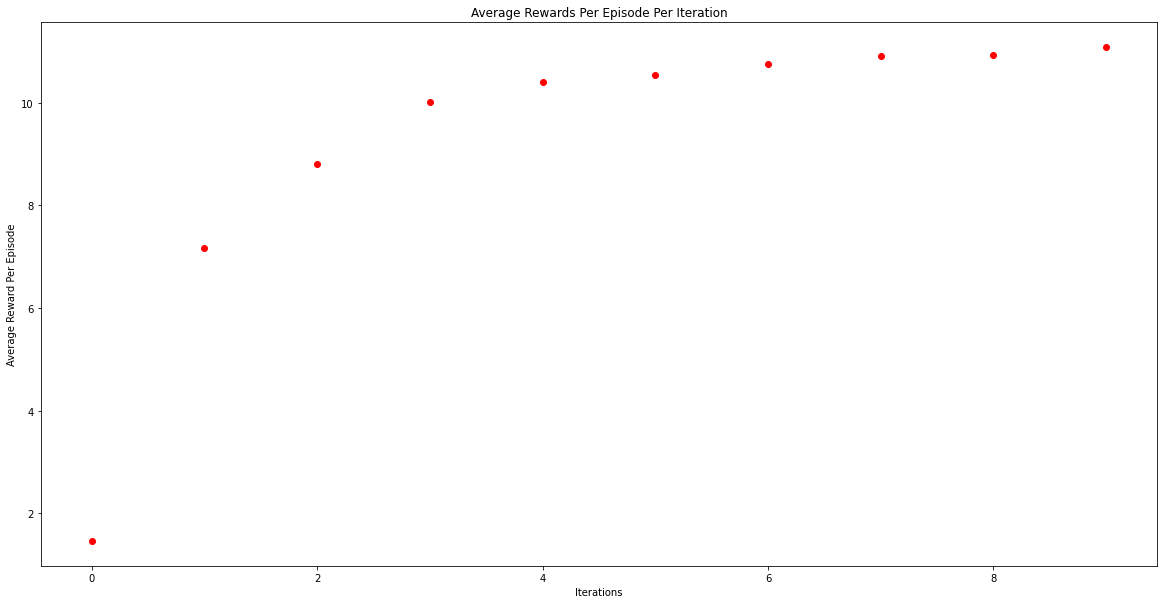

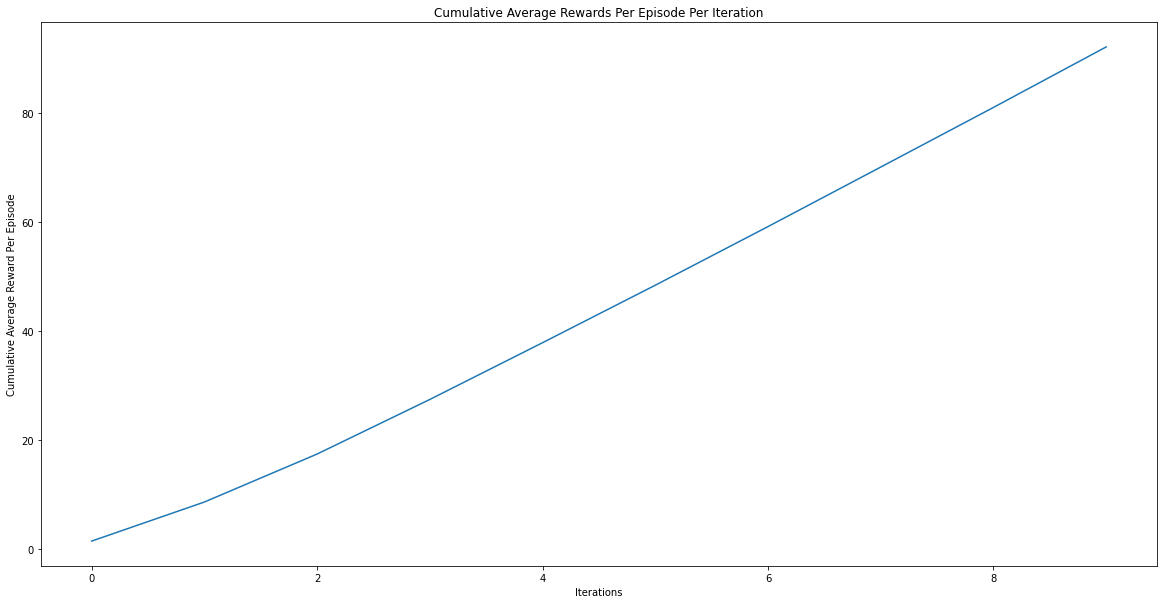

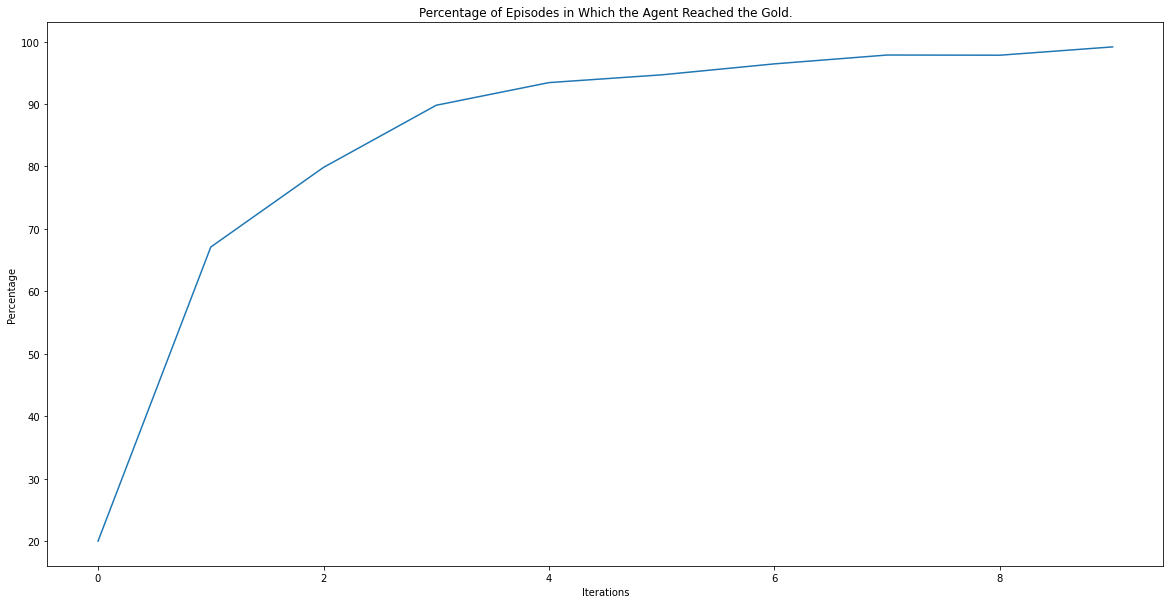


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 2.68
Average penalties incurred per episode: 0.07
Percentage of episodes in which the agent reaches the Gold: 100.0 %


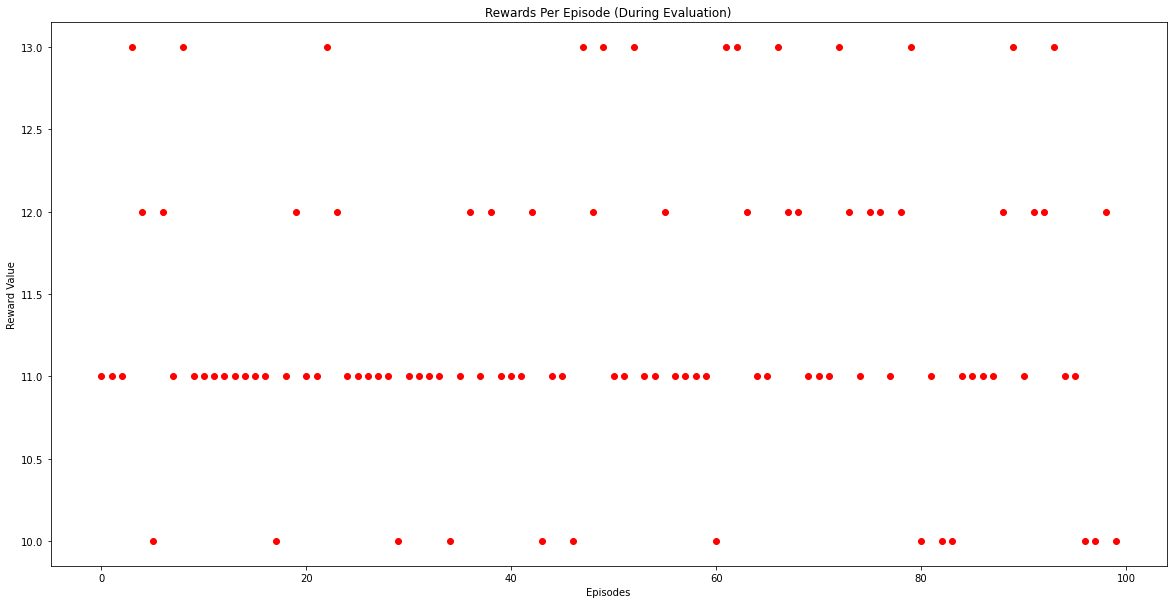

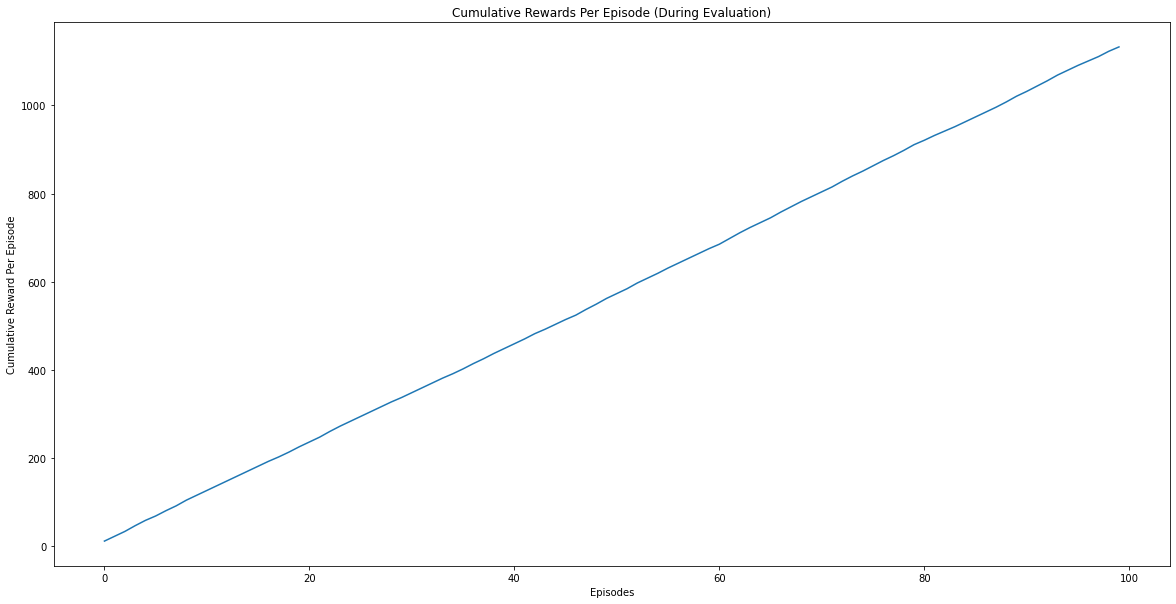

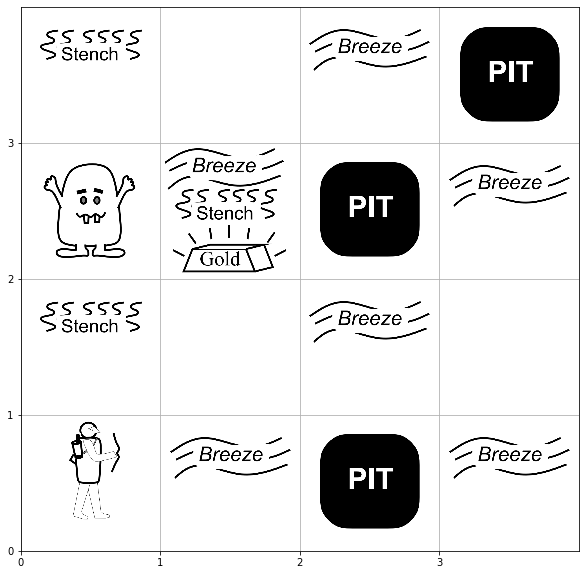

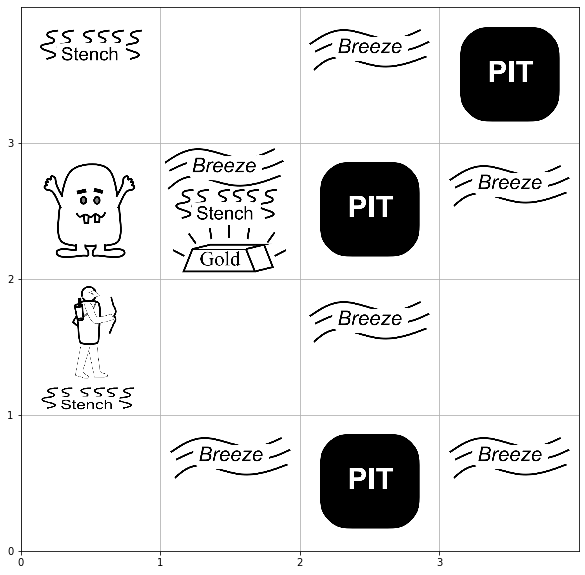

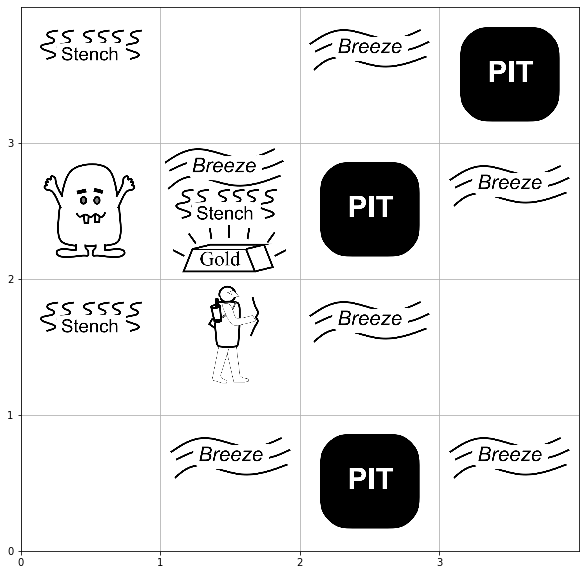

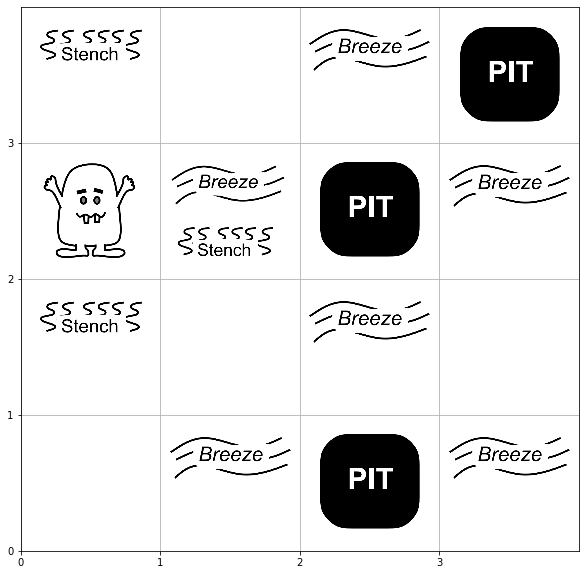

In [9]:
print('Version 1:\n')
AdvantageWeightedRegression(stochastic_wumpus_world_environment, alternate_network=False, offline_memory_size=10000,
                            iterations=10)

Version 2:


Initial Policy Table:
 [[0.24655949 0.25650504 0.25187212 0.24506336]
 [0.23816109 0.2380509  0.2582721  0.26551595]
 [0.         0.         0.         0.        ]
 [0.25036997 0.23324879 0.27386272 0.2425185 ]
 [0.25011486 0.24216618 0.26016974 0.24754928]
 [0.25505036 0.24445735 0.26026994 0.24022233]
 [0.25537807 0.2404562  0.25856328 0.24560246]
 [0.25670508 0.24261346 0.2527648  0.2479167 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.24880935 0.24961622 0.25330493 0.24826948]
 [0.2470489  0.24576028 0.25424138 0.2529494 ]
 [0.24421896 0.24125229 0.2551082  0.25942054]
 [0.25129816 0.2367404  0.25917178 0.25278968]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.27566734 0.13953921 0.41138914 0.17340432]
 [0.09461389 0.1411946  0.46631652 0.297875  ]
 [0.         0.         0.         0.        ]
 [0.23909283 0.08420938 0.5115736  

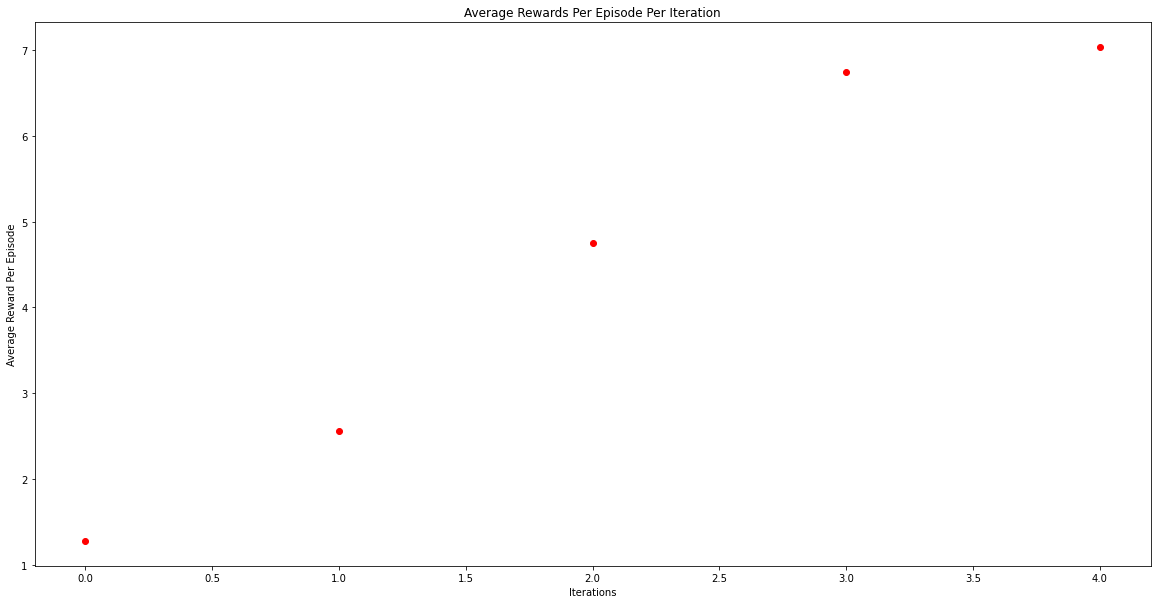

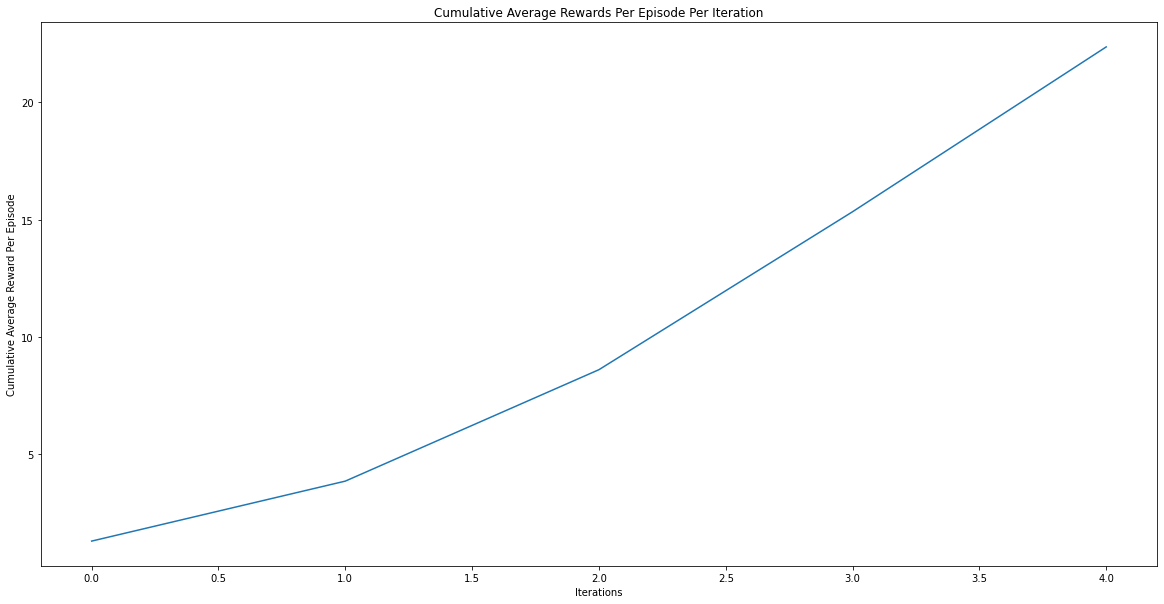

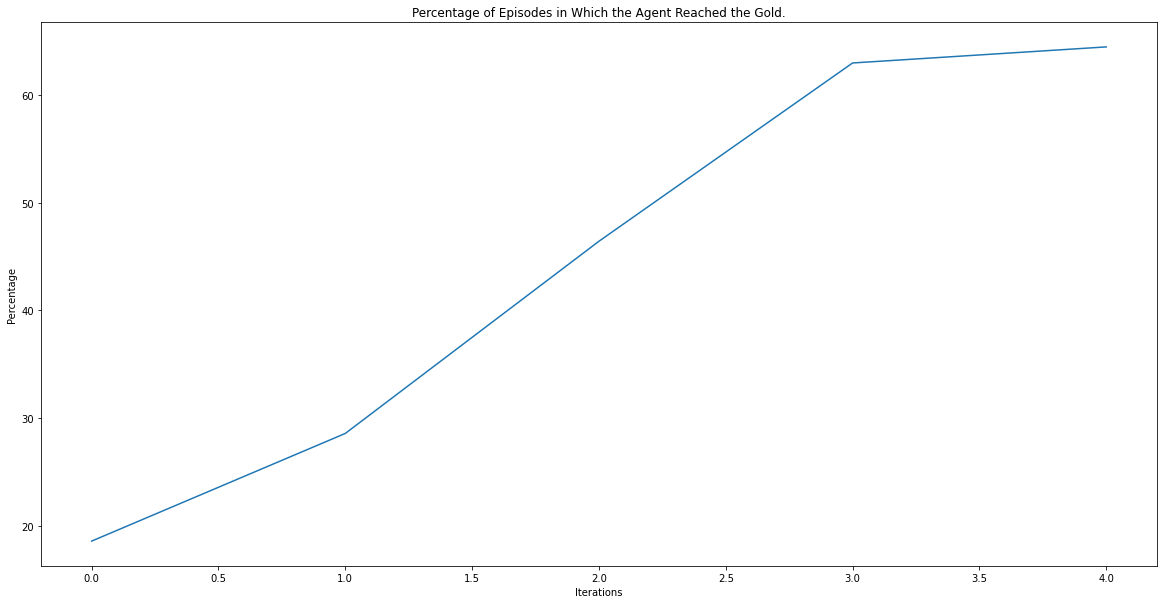


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 2.55
Average penalties incurred per episode: 0.08
Percentage of episodes in which the agent reaches the Gold: 100.0 %


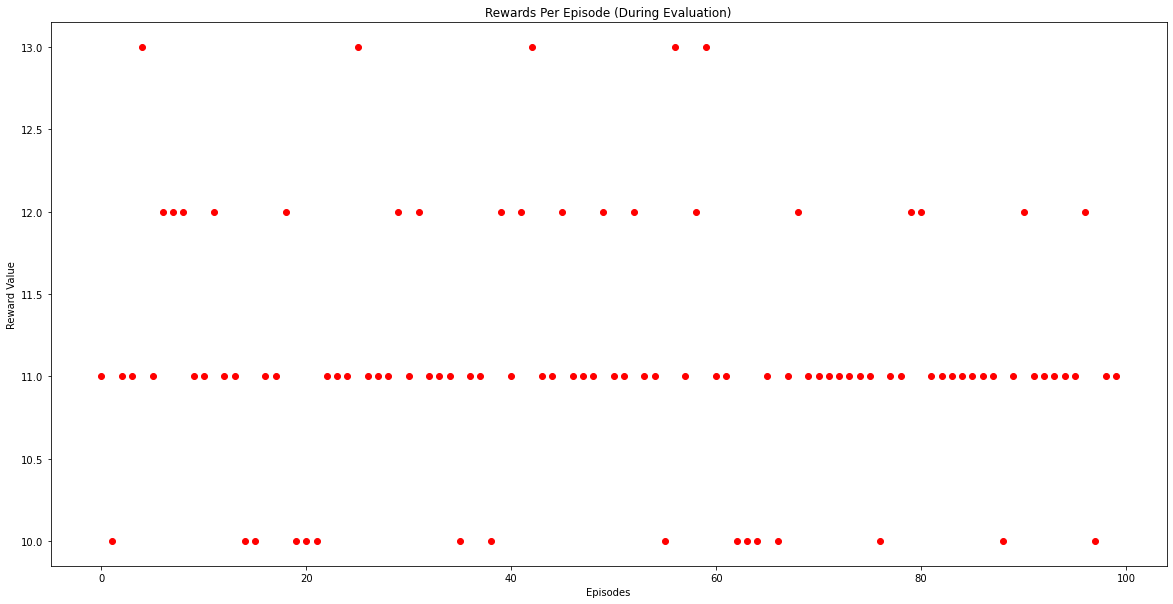

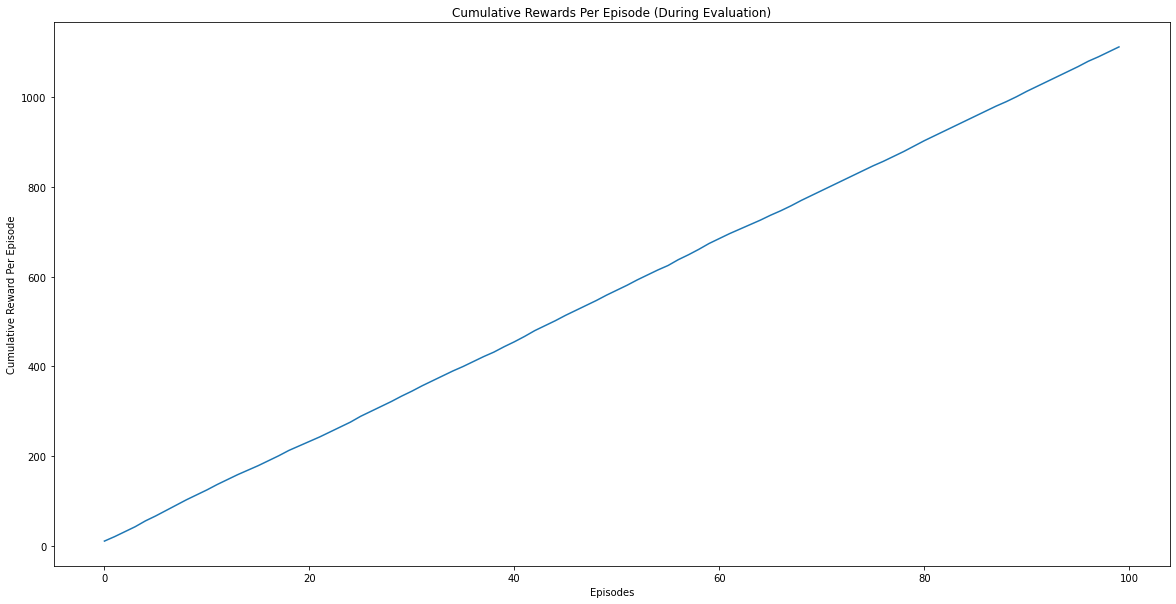

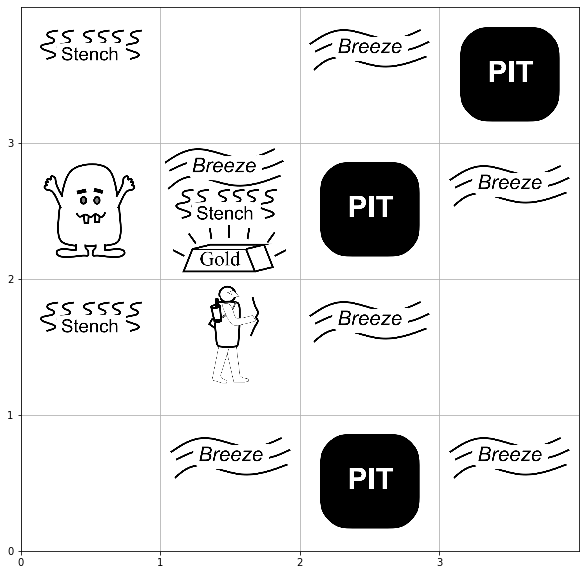

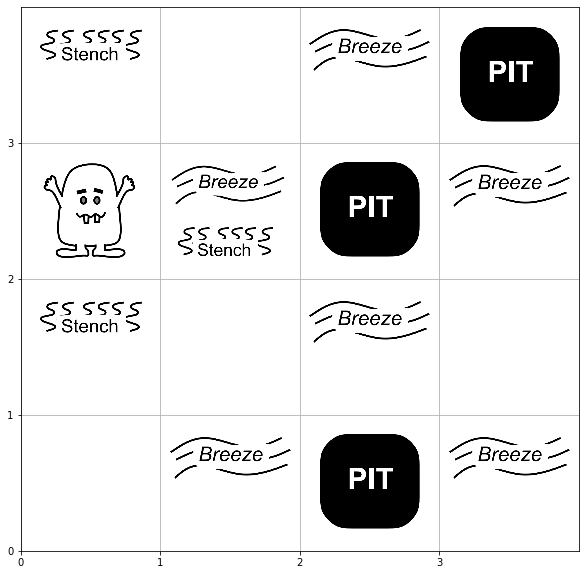

In [10]:
print('Version 2:\n')
AdvantageWeightedRegression(stochastic_wumpus_world_environment, alternate_network=True, offline_memory_size=1000,
                            iterations=5)

Version 3:


Initial Policy Table:
 [[0.23965941 0.24861617 0.25943723 0.2522872 ]
 [0.24305533 0.2534642  0.2518399  0.25164056]
 [0.         0.         0.         0.        ]
 [0.24416587 0.25074366 0.2487438  0.25634667]
 [0.23053858 0.25083387 0.2584467  0.26018083]
 [0.24594879 0.265742   0.23556243 0.25274682]
 [0.24910973 0.2575025  0.24199125 0.25139657]
 [0.24313809 0.26621795 0.2319906  0.25865337]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.24136788 0.25624907 0.24040504 0.26197803]
 [0.25140202 0.2570986  0.23167917 0.25982022]
 [0.23821667 0.24439245 0.24658151 0.27080938]
 [0.24607946 0.2575438  0.24244374 0.253933  ]
 [0.         0.         0.         0.        ]]

Policy table after 5 iterations:
 [[0.24052814 0.2742886  0.30301425 0.182169  ]
 [0.25468057 0.27824718 0.27097166 0.19610056]
 [0.         0.         0.         0.        ]
 [0.1947785  0.26225203 0.34174088 

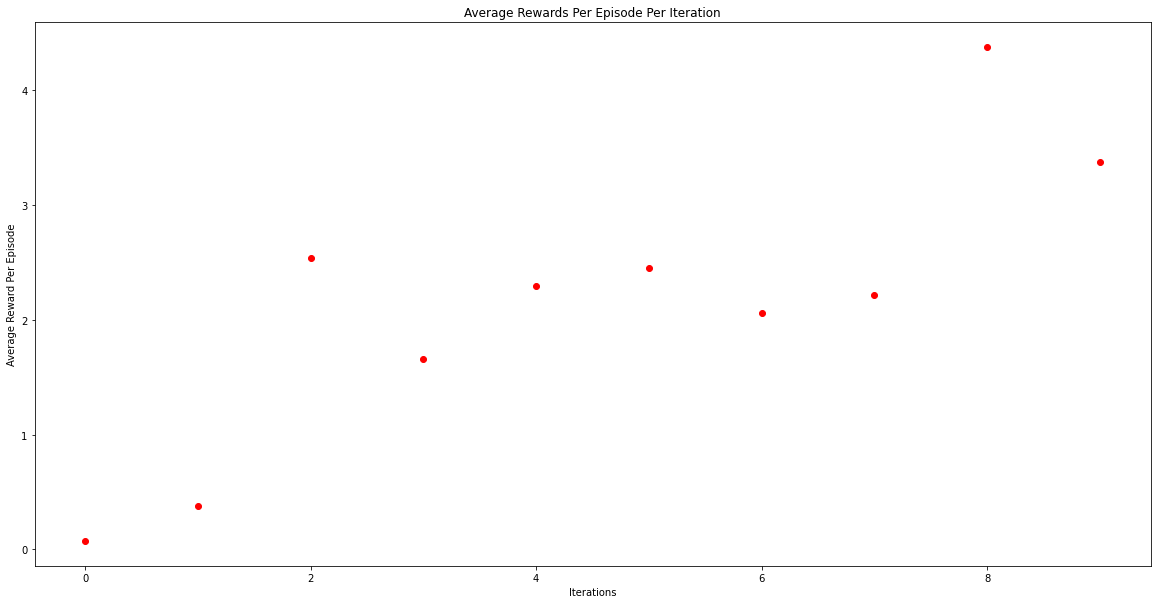

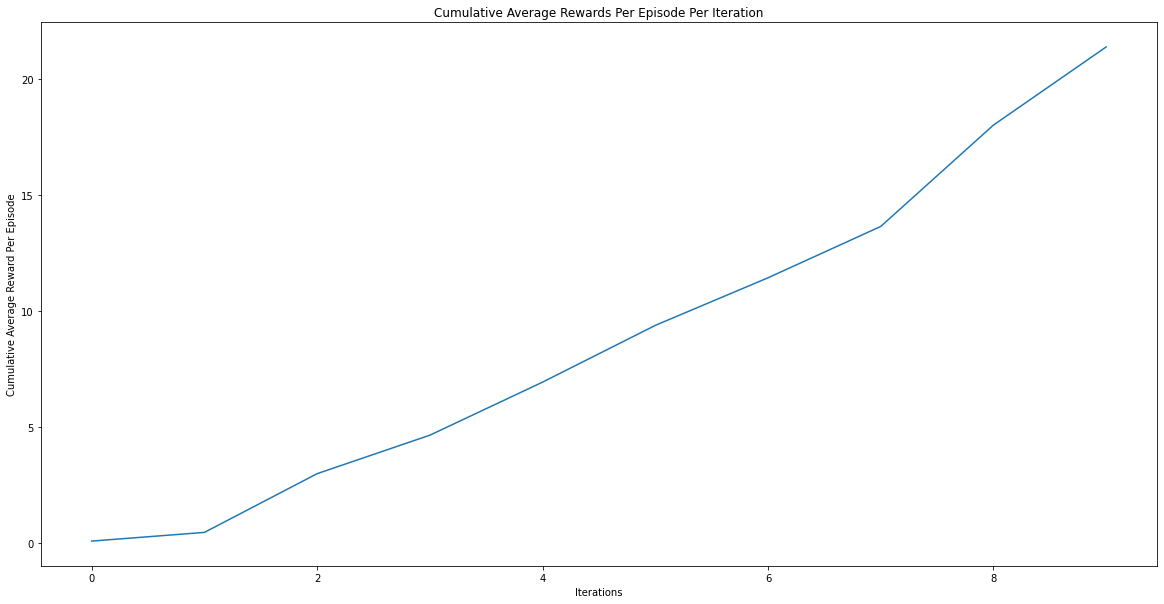

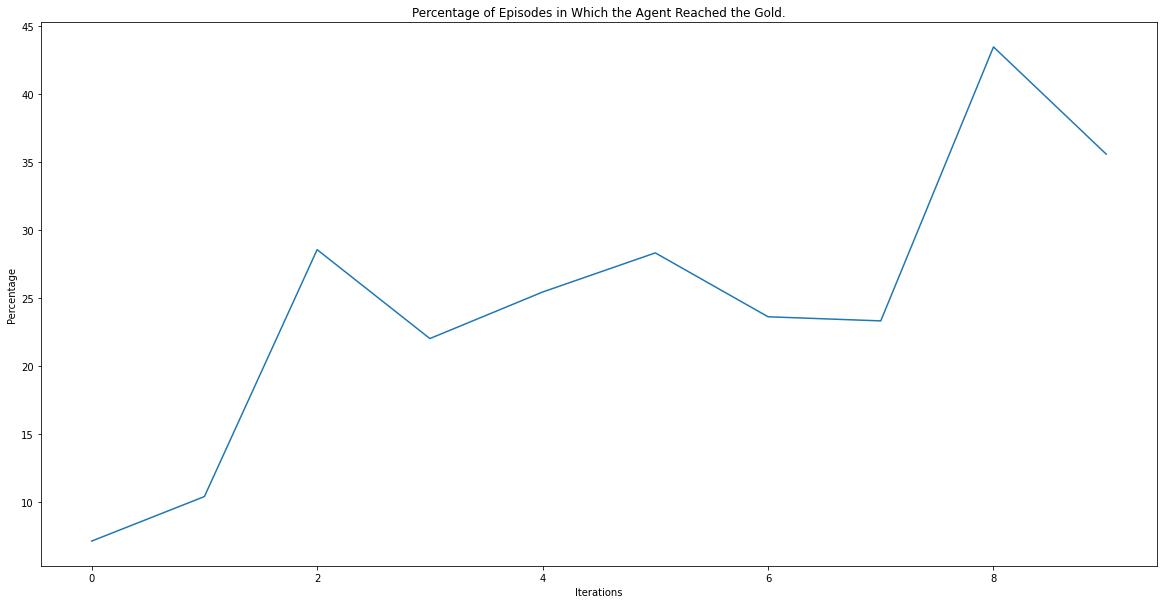


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 4.3
Average penalties incurred per episode: 0.1
Percentage of episodes in which the agent reaches the Gold: 63.0 %


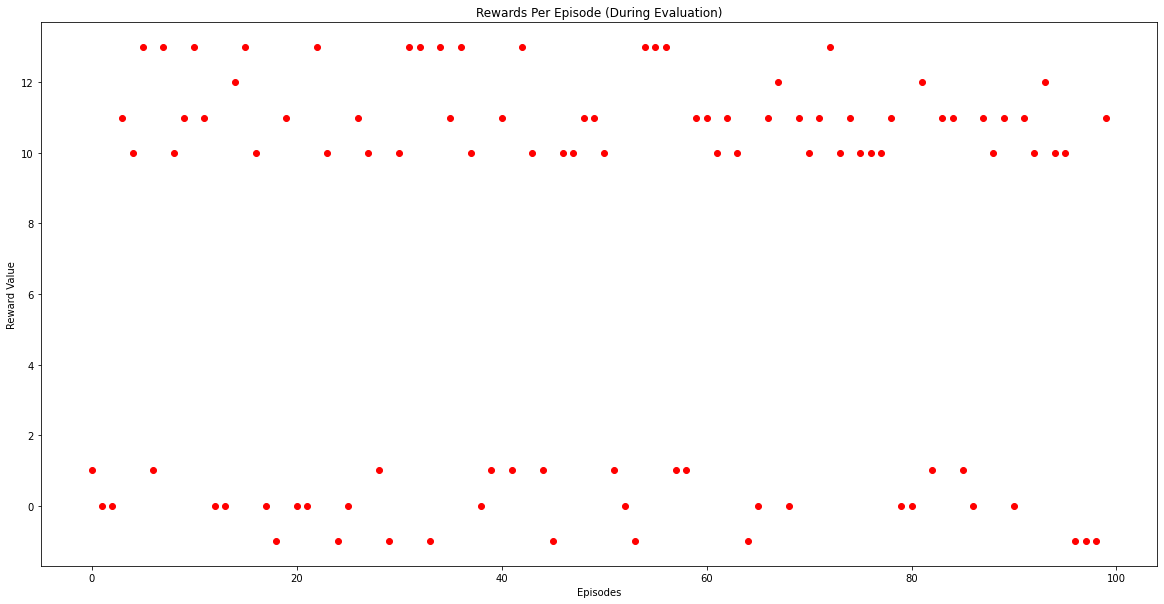

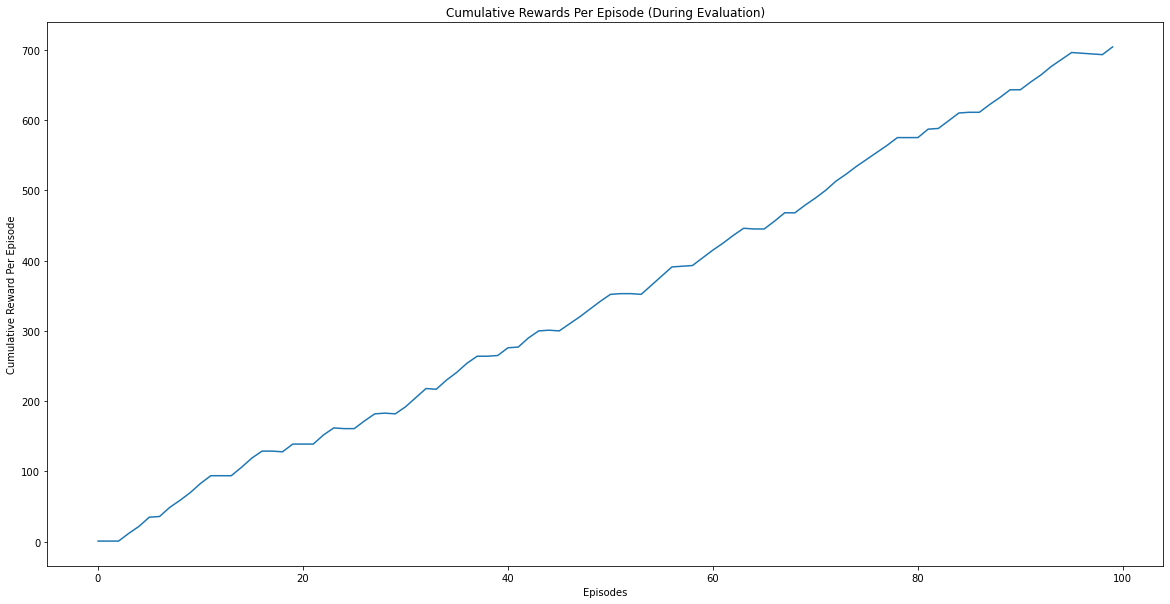

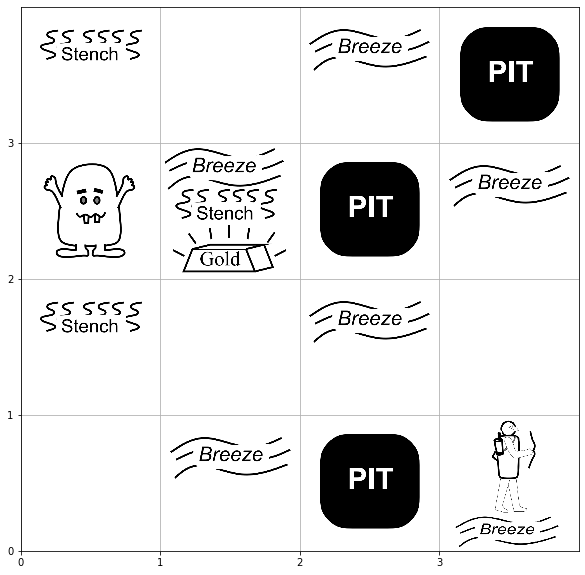

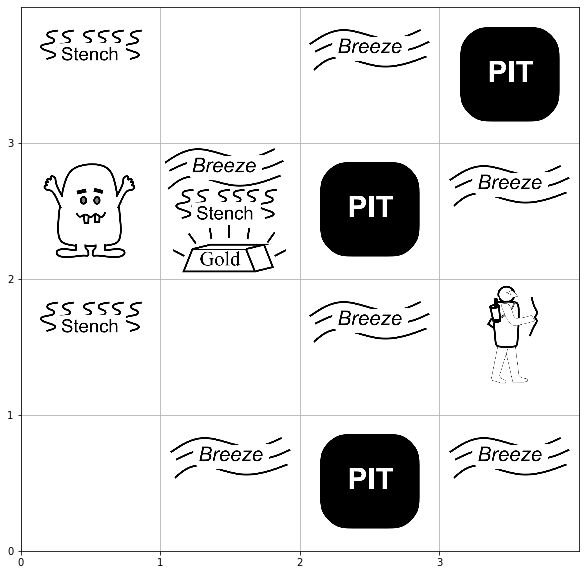

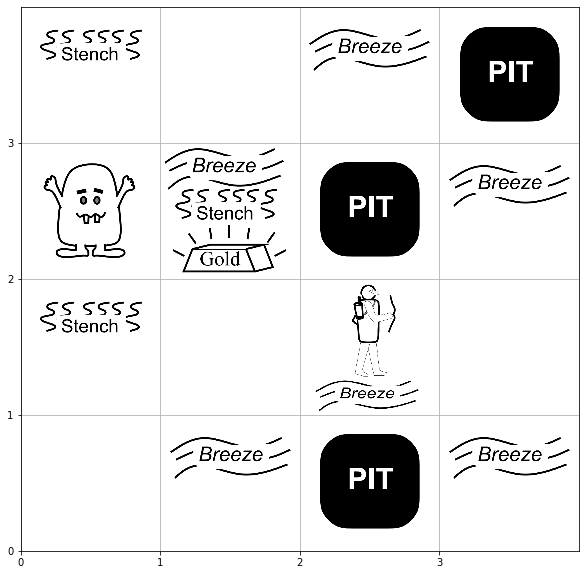

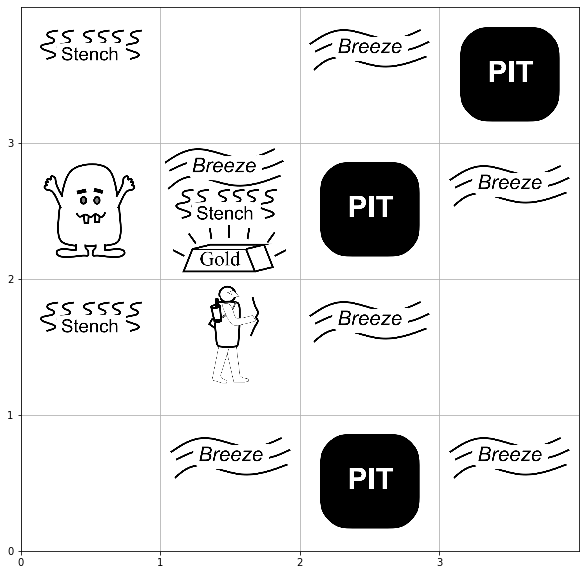

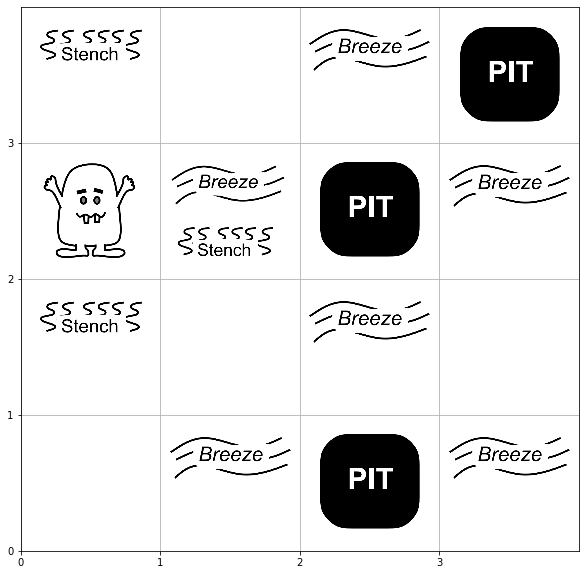

In [11]:
print('Version 3:\n')
AdvantageWeightedRegression(stochastic_wumpus_world_environment, alternate_network=True, offline_memory_size=250,
                            iterations=10)

### Multi-Agent Wumpus World Environment

<img src="files/images/multi_agent_wumpus_world.jpg">

In [12]:
# Defining the Multi-Agent Wumpus World Environment.
class MultiAgentWumpusWorldEnvironment(gym.Env):
    """This class implements the Wumpus World environment."""

    def __init__(self, environment_type):
        """This method initializes the environment.

        :param environment_type: - (It can take two values: 1. 'deterministic' 2. 'stochastic' indicating the type of
                                    environment.)"""

        self.environment_type = environment_type  # This indicates whether the environment is of the type deterministic
                                                  # or stochastic.
        self.observation_space = spaces.Discrete(16)  # This defines that there are 16 states in the environment.
        self.action_space = spaces.Discrete(6)  # This defines that there are 6 discrete actions that the agent can
                                                # perform.
        self.number_of_agents = 2  # This defines the number of agents in the environment.
        self.number_of_arrows = 10  # This defines the number of arrows each agent has.
        self.arrows = [self.number_of_arrows for _ in range(self.number_of_agents)]  # List indicating the number of
                                                                                     # arrows per agent.
        self.agent_positions = [[0, 0], [3, 1]]  # Initializing the agents in fixed positions.
        self.breeze_pos = [[1, 0], [1, 2], [2, 1], [2, 3], [3, 0], [3, 2]]  # This defines the positions of breeze
                                                                            # in the environment.
        self.gold_pos = [3, 3]  # This defines the position of gold in the environment.
        self.gold_quantity = 1  # This defines the quantity of gold.
        self.pit_pos = [[2, 0], [2, 2]]  # This defines the positions of pit in the environment.
        self.stench_pos = [[0, 1], [0, 3], [1, 2]]  # This defines the positions of stench in the environment.
        self.wumpus_pos = [0, 2]  # This defines the position of the Wumpus in the environment.
        self.wumpus_alive = True  # Boolean indicating whether the Wumpus is alive or dead.
        self.timesteps = 0  # This defines the steps the agent has taken during an episode.
        self.max_timesteps = 10  # This defines the maximum steps the agent can take during an episode.
        # This defines the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                              for i in range(self.number_of_agents)]
        # This defines the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                                for i in range(self.number_of_agents)]

    def reset(self, random_start=False):
        """This method resets the agent position and returns the state as the observation.

        :param random_start: - (Boolean indicating whether the agent will start in a random or fixed position.)

        :returns observation: - (Integers from 0 to 15 defining the agent's position in the environment."""

        # Creating the mapping from the possible states the agent can start in to the co-ordinates.
        coordinates_state_mapping = {12: [0, 3], 13: [1, 3], 14: [2, 3],
                                     9: [1, 2], 11: [3, 2],
                                     4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
                                     0: [0, 0], 1: [1, 0], 3: [3, 0]}

        if not random_start:
            self.agent_positions = [[0, 0], [3, 1]]
            observation = [0, 7]
            # The state mapping for position [0, 0] is '0', and for position [3, 1] is '7'.

        else:
            # Randomly selecting the agent's position.
            observation = [random.choice([0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14]) for
                           _ in range(self.number_of_agents)]

            self.agent_positions = [coordinates_state_mapping[observation[i]] for i in range(self.number_of_agents)]

        self.arrows = [self.number_of_arrows for _ in range(self.number_of_agents)]  # Resetting the number of arrows.
        self.wumpus_alive = True  # Resetting the Wumpus to be alive.
        self.gold_quantity = 1  # Resetting the Gold quantity to be 1.
        self.timesteps = 0  # Resetting the number of steps taken by the agent.
        # Resetting the distance of the agents to the Gold.
        self.gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                              for i in range(self.number_of_agents)]
        # Resetting the distance of the agents to the Wumpus.
        self.wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                                for i in range(self.number_of_agents)]

        return observation

    def step(self, actions):
        """This function implements what happens when the agent takes a particular action. It changes the agent's
        position (While not allowing it to go out of the environment space.), maps the environment co-ordinates to a
        state, defines the rewards for the various states, and determines when the episode ends.

        :param actions: - (Vector of Integers in the range 0 to 5 inclusive.)

        :returns observation: - (Vector of Integers from 0 to 15 defining the agent's position in the environment.)
                 rewards: - (Vector of Integers values that are used to measure the performance of the agents.)
                 done: - (Boolean describing whether or not the episode has ended.)
                 info: - (A dictionary that can be used to provide additional implementation information.)"""

        if self.environment_type == 'deterministic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    if self.arrows[i] > 0:
                        self.arrows[i] -= 1

        if self.environment_type == 'stochastic':
            for i in range(self.number_of_agents):
                # Describing the outcomes of the various possible actions.
                if actions[i] == 0:  # This action causes the agent to go right.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] += 1
                if actions[i] == 1:  # This action causes the agent to go left.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][0] -= 1
                if actions[i] == 2:  # This action causes the agent to go up.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] += 1
                if actions[i] == 3:  # This action causes the agent to go down.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i][1] -= 1
                if actions[i] == 4:  # This action causes the agent to not move.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        self.agent_positions[i] = self.agent_positions[i]
                if actions[i] == 5:  # This action causes the agent to shoot an arrow.
                    probability = random.uniform(0, 1)
                    if probability > 0.1:
                        if self.arrows[i] > 0:
                            self.arrows[i] -= 1

        # Ensuring that the agent doesn't go out of the environment.
        self.agent_positions = np.clip(self.agent_positions, a_min=0, a_max=3)

        # Computing the new distance of the agents to the Gold.
        new_gold_distance = [self.compute_distance(self.agent_positions[i], self.gold_pos)
                             for i in range(self.number_of_agents)]

        # Setting the rewards to 0.
        rewards = [0 for _ in range(self.number_of_agents)]

        # Giving the agents reward 10 for picking up the Gold.
        for i in range(self.number_of_agents):
            if (self.agent_positions[i] == self.gold_pos).all():
                if self.gold_quantity > 0:
                    self.gold_quantity -= 1
                    rewards[i] = 10

        # Giving the agents different rewards if their distance to the Gold increases, decreases or remains the same.
        if self.gold_quantity > 0:
            for i in range(self.number_of_agents):
                # If agent moves away from the Gold it gets reward -1.
                if new_gold_distance[i] > self.gold_distance[i]:
                    rewards[i] = -1
                    self.gold_distance[i] = new_gold_distance[i]

                # If agent moves closer to the Gold it gets reward 1.
                elif new_gold_distance[i] < self.gold_distance[i]:
                    rewards[i] = 1
                    self.gold_distance[i] = new_gold_distance[i]

                else:  # If agent's distance to the Gold doesn't change it gets reward 0.
                    rewards[i] = 0

        # Computing the new distance of the agents to the Wumpus.
        new_wumpus_distance = [self.compute_distance(self.agent_positions[i], self.wumpus_pos)
                               for i in range(self.number_of_agents)]

        # Giving the agents different rewards if their distance to the Wumpus increases, decreases or remains the same.
        # These reward will only come in when the Gold is collected.
        if self.gold_quantity == 0:
            # If agent moves away from the Wumpus it gets reward -1.
            for i in range(self.number_of_agents):
                if new_wumpus_distance[i] > self.wumpus_distance[i]:
                    rewards[i] = -1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                # If agent moves closer to the Wumpus it gets reward 1.
                elif new_wumpus_distance[i] < self.wumpus_distance[i]:
                    rewards[i] = 1
                    self.wumpus_distance[i] = new_wumpus_distance[i]

                else:  # If the agent's distance to the Wumpus doesn't change it gets reward 0.
                    rewards[i] = 0

        # Creating the mapping from the co-ordinates to the state.
        coordinates_state_mapping = {'[0 3]': 12, '[1 3]': 13, '[2 3]': 14, '[3 3]': 15,
                                     '[0 2]': 8, '[1 2]': 9, '[2 2]': 10, '[3 2]': 11,
                                     '[0 1]': 4, '[1 1]': 5, '[2 1]': 6, '[3 1]': 7,
                                     '[0 0]': 0, '[1 0]': 1, '[2 0]': 2, '[3 0]': 3}

        # Setting the observation to be the state occupied by the agent.
        observation = [coordinates_state_mapping[f'{self.agent_positions[i]}'] for i in range(self.number_of_agents)]

        self.timesteps += 1  # Increasing the total number of steps taken by the agent.

        # Setting the reward to -1 if the agent falls into the pit.
        for i in range(self.number_of_agents):
            for j in range(len(self.pit_pos)):
                if (self.agent_positions[i] == self.pit_pos[j]).all():
                    rewards[i] = -1

            # Setting the reward to -1 if the agent is killed by the Wumpus.
            if (self.agent_positions[i] == self.wumpus_pos).all():
                rewards[i] = -1

        # Giving the agents reward 10 for killing the Wumpus.
        if all((self.wumpus_distance[i] == 1 and actions[i] == 5 and self.arrows[i] > 0)
               for i in range(self.number_of_agents)):
            rewards = [10 for _ in range(self.number_of_agents)]
            self.wumpus_alive = False

        # The episode terminates when one agent picks the Gold and both agents kill the Wumpus together,
        # or at least one agent is killed by the Wumpus, falls into the pit, or takes more than 10 steps.
        if (self.gold_quantity == 0 and not self.wumpus_alive) or \
                any((self.agent_positions[i] == self.wumpus_pos).all() for i in range(self.number_of_agents)):
            done = True
        else:
            done = False
        for i in range(len(self.pit_pos)):
            if any((self.agent_positions[i] == self.pit_pos[i]).all() for i in range(self.number_of_agents)):
                done = True
        if self.timesteps == self.max_timesteps:
            done = True
        info = {}

        return observation, rewards, done, info

    @staticmethod
    def compute_distance(x, y):
        """This method computes the distance between the old and new.

        :param x: This is the first array representing the agent position.
        :param y: This is the second array representing the goal position.

        :returns distance: The Manhattan distance between the agent and the goal."""

        distance = np.abs(x[0] - y[0]) + np.abs(x[1] - y[1])
        return distance

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param mode:
        :param plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(10, 10))  # Initializing the figure.
        ax.set_xlim(0, 4)  # Setting the limit on the x-axis.
        ax.set_ylim(0, 4)  # Setting the limit on the y-axis.

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus = \
                False, False, False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if plot_pos[0] == self.agent_positions[0][0] and plot_pos[1] == self.agent_positions[0][1]:
                plot_agent_1 = True
            if plot_pos[0] == self.agent_positions[1][0] and plot_pos[1] == self.agent_positions[1][1]:
                plot_agent_2 = True
            for i in range(len(self.breeze_pos)):
                if plot_pos == self.breeze_pos[i]:
                    plot_breeze = True
            if self.gold_quantity > 0:  # Gold isn't plotted if it has already been picked by one of the agents.
                if plot_pos == self.gold_pos:
                    plot_gold = True
            for i in range(len(self.pit_pos)):
                if plot_pos == self.pit_pos[i]:
                    plot_pit = True
            for i in range(len(self.stench_pos)):
                if plot_pos == self.stench_pos[i]:
                    plot_stench = True
            if plot_pos == self.wumpus_pos:
                plot_wumpus = True

            # Plot for Agent 1.
            if plot_agent_1 and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1.png'), zoom=0.28),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1)

            # Plot for Agent 2.
            if plot_agent_2 and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2.png'), zoom=0.28),
                                         list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2)

            # Plot for Breeze.
            if plot_breeze and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                breeze = AnnotationBbox(OffsetImage(plt.imread('./images/breeze.png'), zoom=0.28),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze)

            # Plot for Gold.
            if plot_gold and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_stench, plot_wumpus]):
                gold = AnnotationBbox(OffsetImage(plt.imread('./images/gold.png'), zoom=0.28),
                                      list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(gold)

            # Plot for Pit.
            if plot_pit and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                pit = AnnotationBbox(OffsetImage(plt.imread('./images/pit.png'), zoom=0.28),
                                     list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(pit)

            # Plot for Stench.
            if plot_stench and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                stench = AnnotationBbox(OffsetImage(plt.imread('./images/stench.png'), zoom=0.28),
                                        list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench)

            # Plot for alive Wumpus.
            if self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_alive = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus.png'), zoom=0.28),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_alive)

            # Plot for dead Wumpus.
            if not self.wumpus_alive:
                if plot_wumpus and \
                        all(not item for item in
                            [plot_agent_1, plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_stench]):
                    wumpus_dead = AnnotationBbox(OffsetImage(plt.imread('./images/wumpus_dead.png'), zoom=0.28),
                                                 list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                    ax.add_artist(wumpus_dead)

            # Plot for Agent 1 and Agent 2.
            if all(item for item in [plot_agent_1, plot_agent_2]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2 = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2.png'), zoom=0.28),
                                           list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2)

            # Plot for Agent 1 and Breeze.
            if all(item for item in [plot_agent_1, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze.png'), zoom=0.28),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_breeze)

            # Plot for Agent 2 and Breeze.
            if all(item for item in [plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze.png'), zoom=0.28),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_breeze)

            # Plot for Agent 1, Agent 2, and Breeze.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_stench, plot_wumpus]):
                agent_1_2_breeze = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze.png'), zoom=0.28),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_breeze)

            # Plot for Agent 1 and Pit.
            if all(item for item in [plot_agent_1, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_dead_pit.png'), zoom=0.28),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_pit)

            # Plot for Agent 2 and Pit.
            if all(item for item in [plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_dead_pit.png'), zoom=0.28),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_pit)

            # Plot for Agent 1, Agent 2, and Pit.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_pit]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_stench, plot_wumpus]):
                agent_1_2_pit = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_dead_pit.png'), zoom=0.28),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_pit)

            # Plot for Agent 1 and Stench.
            if all(item for item in [plot_agent_1, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_stench.png'), zoom=0.28),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_stench)

            # Plot for Agent 2 and Stench.
            if all(item for item in [plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_stench.png'), zoom=0.28),
                                                list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_2_stench)

            # Plot for Agent 1, Agent 2, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_stench]) and \
                    all(not item for item in
                        [plot_breeze, plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_stench.png'), zoom=0.28),
                                                  list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(agent_1_2_stench)

            # Plot for Agent 1, Breeze, Stench.
            if all(item for item in [plot_agent_1, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                agent_1_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_breeze_stench.png'),
                                                                   zoom=0.28), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_1_breeze_stench)

            # Plot for Agent 2, Breeze, Stench.
            if all(item for item in [plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_gold, plot_pit, plot_wumpus]):
                agent_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_2_breeze_stench.png'),
                                                                   zoom=0.28), list(map(add, plot_pos, [0.5, 0.5])),
                                                       frameon=False)
                ax.add_artist(agent_2_breeze_stench)

            # Plot for Agent 1, Agent 2, Breeze, and Stench.
            if all(item for item in [plot_agent_1, plot_agent_2, plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_gold, plot_pit, plot_wumpus]):
                agent_1_2_breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/agent_1_2_breeze_stench.png'),
                                                                     zoom=0.28), list(map(add, plot_pos, [0.5, 0.5])),
                                                         frameon=False)
                ax.add_artist(agent_1_2_breeze_stench)

            # Plot for Breeze and Gold.
            if all(item for item in [plot_breeze, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_stench, plot_wumpus]):
                breeze_gold = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold.png'), zoom=0.28),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold)

            # Plot for Breeze and Stench.
            if all(item for item in [plot_breeze, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_gold, plot_pit, plot_wumpus]):
                breeze_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_stench.png'), zoom=0.28),
                                               list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_stench)

            # Plot for Breeze, Stench, and Gold.
            if all(item for item in [plot_breeze, plot_gold, plot_stench]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_pit, plot_wumpus]):
                breeze_gold_stench = AnnotationBbox(OffsetImage(plt.imread('./images/breeze_gold_stench.png'), zoom=0.28),
                                                    list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(breeze_gold_stench)

            # Plot for Stench and Gold.
            if all(item for item in [plot_stench, plot_gold]) and \
                    all(not item for item in
                        [plot_agent_1, plot_agent_2, plot_breeze, plot_pit, plot_wumpus]):
                stench_gold = AnnotationBbox(OffsetImage(plt.imread('./images/stench_gold.png'), zoom=0.28),
                                             list(map(add, plot_pos, [0.5, 0.5])), frameon=False)
                ax.add_artist(stench_gold)

        # Dictionary mapping the states to their co-ordinates.
        coordinates_state_mapping = {
            12: [0, 3], 13: [1, 3], 14: [2, 3], 15: [3, 3],
            8: [0, 2], 9: [1, 2], 10: [2, 2], 11: [3, 2],
            4: [0, 1], 5: [1, 1], 6: [2, 1], 7: [3, 1],
            0: [0, 0], 1: [1, 0], 2: [2, 0], 3: [3, 0]}

        # Rendering the images for all states.
        for state in range(self.observation_space.n):
            plot_image(coordinates_state_mapping[state])

        plt.xticks([0, 1, 2, 3])  # Specifying the ticks on the x-axis.
        plt.yticks([0, 1, 2, 3])  # Specifying the ticks on the y-axis.
        plt.grid()  # Setting the plot to be of the type 'grid'.

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :1]
            width = int(img.shape[1] * 84 / 1000)
            height = int(img.shape[0] * 84 / 1000)
            dim = (width, height)
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            return preprocessed_image

In [13]:
class AdvantageWeightedRegression:
    """This class implements the AWR Agent."""

    def __init__(self, environment, alternate_network=False, offline_memory_size=10000, iterations=10):
        """This method initializes the AWR parameters, and calls the train, evaluate and render_actions methods.

        :param environment: This is the environment on which the agent will learn.
        :param alternate_network: Boolean indicating whether to use the second deeper network.
        :param offline_memory_size: Integer indicating the size of the offline replay memory.
        :param iterations: Integer indicating the number of episodes for which the agent will train."""

        self.environment = environment  # The environment which we need the agent to solve.
        self.alternate_network = alternate_network  # Boolean indicating whether to use the second deeper network.
        self.offline_replay_memory_size = offline_memory_size  # This specifies the length of the offline replay memory.
        # Creating as many replay memories as there are agents.
        self.offline_replay_memory = [[] for _ in range(self.environment.number_of_agents)]
        self.iterations = iterations  # Number of episodes for which the agent will train.
        self.discount_factor = 0.9  # Discount factor determines the value of the future rewards.
        self.beta = 0.5  # Hyper-parameter used to calculate the exponential advantage.
        # Creating the actor, critic and policy models.
        self.actor_model, self.critic_model, self.policy_model = [], [], []
        for _ in range(self.environment.number_of_agents):
            self.actor_model_, self.critic_model_, self.policy_model_ = self.neural_network()
            self.actor_model.append(self.actor_model_)
            self.critic_model.append(self.critic_model_)
            self.policy_model.append(self.policy_model_)

        self.cumulative_rewards_evaluation = []  # List containing the cumulative rewards per episode during evaluation.
        self.train()  # Calling the train method.
        self.evaluate()  # Calling the evaluate method.
        self.render_actions()  # Calling the render method.

    def neural_network(self):
        """This method builds the actor, critic and policy networks."""

        if not self.alternate_network:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common1 = Dense(64, activation='relu')(input_)  # Common layer for the networks.
            common2 = Dense(128, activation='relu')(common1)
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common2)  # Actor output.
            values = Dense(1, activation='linear')(common2)  # Critic output.

        else:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.n,))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common1 = Dense(512, activation='relu')(input_)  # Common layer 1 for the networks.
            common2 = Dense(256, activation='relu')(common1)  # Common layer 2 for the networks.
            common3 = Dense(128, activation='relu')(common2)  # Common layer 3 for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common3)  # Actor output.
            values = Dense(1, activation='linear')(common3)  # Critic output.

        def custom_loss(exponential_advantage_):
            """This method defines the custom loss wrapper function that will be used by the actor model."""

            def loss_fn(y_true, y_pred):
                # Clipping y_pred so that we don't end up taking the log of 0 or 1.
                clipped_y_pred = k.clip(y_pred, 1e-8, 1 - 1e-8)
                log_probability = y_true * k.log(clipped_y_pred)
                return k.sum(-log_probability * exponential_advantage_)
            return loss_fn

        # Instantiating the actor model.
        actor_model = Model(inputs=[input_, exponential_advantage], outputs=[probabilities])
        actor_model.compile(optimizer=Adam(), loss=custom_loss(exponential_advantage))

        # Instantiating the critic model.
        critic_model = Model(inputs=[input_], outputs=[values])
        critic_model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber())

        # Instantiating the policy model.
        policy_model = Model(inputs=[input_], outputs=[probabilities])

        return actor_model, critic_model, policy_model

    def monte_carlo_returns(self, index):
        """This method calculates the Monte Carlo returns given a list of rewards.

        :param index: Integer indicating the agent for whom we will calculate the Monte Carlo returns."""

        rewards = [item[2] for item in self.offline_replay_memory[index]]
        monte_carlo_returns = []  # List containing the Monte-Carlo returns.
        monte_carlo_return = 0
        t = 0  # Exponent by which the discount factor is raised.

        for i in range(len(self.offline_replay_memory[index])):

            while not self.offline_replay_memory[index][i][4]:  # Execute until you encounter a terminal state.

                # Equation to calculate the Monte-Carlo return.
                monte_carlo_return += self.discount_factor ** t * rewards[i]
                i += 1  # Go to the next sample.
                t += 1  # Increasing the exponent by which the discount factor is raised.

                # Condition to check whether we have reached the end of the replay memory without the episode being
                # terminated, and if so break. (This can happen with the samples at the end of the replay memory as we
                # only store the samples till we reach the replay memory size and not till we exceed it with the episode
                # being terminated.)
                if i == len(self.offline_replay_memory[index]):

                    # If the episode hasn't terminated but you reach the end append the Monte-Carlo return to the list.
                    monte_carlo_returns.append(monte_carlo_return)

                    # Resetting the Monte-Carlo return value and the exponent to 0.
                    monte_carlo_return = 0
                    t = 0

                    break  # Break from the loop.

            # If for one of the samples towards the end we reach the end of the replay memory and it hasn't terminated,
            # we will go back to the beginning of the for loop to calculate the Monte-Carlo return for the future
            # samples if any for whom the episode hasn't terminated.
            if i == len(self.offline_replay_memory[index]):
                continue

            # Equation to calculate the Monte-Carlo return.
            monte_carlo_return += self.discount_factor ** t * rewards[i]

            # Appending the Monte-Carlo Return for cases where the episode terminates without reaching the end of the
            # replay memory.
            monte_carlo_returns.append(monte_carlo_return)

            # Resetting the Monte-Carlo return value and the exponent to 0.
            monte_carlo_return = 0
            t = 0

        # Normalizing the returns.
        monte_carlo_returns = np.array(monte_carlo_returns)
        monte_carlo_returns = (monte_carlo_returns - np.mean(monte_carlo_returns)) / (np.std(monte_carlo_returns)
                                                                                      + 1e-08)
        monte_carlo_returns = monte_carlo_returns.tolist()

        return monte_carlo_returns

    def replay(self, i):
        """This is the replay method, that is used to fit the actor and critic networks and synchronize the weights
            between the actor and policy networks.

        :param i: Integer indicating the agent for whom we will perform the replay. """

        states = [item[0] for item in self.offline_replay_memory[i]]
        states = np.asarray(states).reshape(-1, self.environment.observation_space.n)

        actions = [tf.keras.utils.to_categorical(item[1], self.environment.action_space.n).tolist()
                   for item in self.offline_replay_memory[i]]

        monte_carlo_returns = self.monte_carlo_returns(i)

        critic_values = self.critic_model[i].predict(states).flatten()

        exponential_advantages = [np.exp(1/self.beta * (monte_carlo_returns[x] - critic_values[x]))
                      for x in range(len(self.offline_replay_memory[i]))]

        # Fitting the actor model.
        self.actor_model[i].fit([states, np.asarray(exponential_advantages)], np.asarray(actions),
                             batch_size=16, epochs=1, verbose=0)

        # Syncing the weights between the actor and policy models.
        self.policy_model[i].set_weights(self.actor_model[i].get_weights())

        # Fitting the critic model.
        self.critic_model[i].fit(states, np.asarray(monte_carlo_returns), batch_size=16, epochs=1, verbose=0)

    def train(self):
        """This method performs the agent training."""

        # Environment states for indirectly plotting the policy table.
        test_states = [x for x in range(self.environment.observation_space.n)]
        test_states = tf.keras.utils.to_categorical(test_states)

        # Printing the initial policy table.
        policy_table = [self.policy_model[i].predict(
            np.asarray(test_states).reshape(-1, self.environment.observation_space.n))
            for i in range(self.environment.number_of_agents)]
        for i in range(self.environment.number_of_agents):
            for terminal_state in [2, 8, 10, 15]:  # The list represents terminal states.
                policy_table[i][terminal_state] = 0
        for i in range(self.environment.number_of_agents):
            print(f'\nInitial Policy Table for Agent {i + 1}:\n', policy_table[i])

        average_reward_per_episode_per_iteration = []
        cumulative_average_rewards_per_episode_per_iteration = []
        wumpus_killed_list = []  # List containing the percentage of episodes in which the agents killed the Wumpus per
                                 # iteration.

        for iteration in range(self.iterations):

            # Resetting the offline replay memories for all agents to be empty.
            self.offline_replay_memory = [[] for _ in range(self.environment.number_of_agents)]
            total_reward_iteration = 0  # Total reward acquired in this iteration.
            wumpus_killed = 0  # Initializing the number of episodes in which the agents killed the Wumpus to be 0.
            episodes = 0  # Initializing the number of episodes in this iteration to be 0.

            while len(self.offline_replay_memory[0]) < self.offline_replay_memory_size:

                # Resetting the environment and starting from a random position.
                state = self.environment.reset(random_start=False)
                # One-hot encoding.
                state = [tf.keras.utils.to_categorical(state[i], self.environment.observation_space.n)
                         for i in range(self.environment.number_of_agents)]
                done = False  # Initializing the done parameter which indicates whether the environment has terminated
                              # or not to False.
                episodes += 1  # Increasing the number of episodes in this iteration.

                while not done:
                    # Selecting an action according to the predicted action probabilities.
                    action_probabilities = [self.policy_model[i].predict(
                        np.asarray(state[i]).reshape(-1, self.environment.observation_space.n))[0]
                                            for i in range(self.environment.number_of_agents)]
                    action = [np.random.choice(self.environment.action_space.n, p=action_probabilities[i])
                              for i in range(self.environment.number_of_agents)]

                    # Taking an action.
                    next_state, rewards, done, info = self.environment.step(action)
                    # One-hot encoding.
                    next_state = [tf.keras.utils.to_categorical(next_state[i], self.environment.observation_space.n)
                                  for i in range(self.environment.number_of_agents)]

                    # Incrementing the wumpus_killed counter when the agents kill the Wumpus.
                    if not self.environment.wumpus_alive:
                        wumpus_killed += 1

                    # Incrementing the total reward.
                    total_reward_iteration += sum(rewards)

                    # Appending the state, action, reward, next state and done to the replay memory.
                    for i in range(self.environment.number_of_agents):
                        self.offline_replay_memory[i].append([state[i], action[i], rewards[i], next_state[i], done])

                    state = next_state  # Setting the current state to be equal to the next state.

                    # This condition ensures that we don't append more values than the size of the replay memory.
                    if len(self.offline_replay_memory[0]) == self.offline_replay_memory_size:
                        break

            # Calculating the average reward per episode for this iteration.
            average_reward_per_episode = total_reward_iteration / episodes
            average_reward_per_episode_per_iteration.append(average_reward_per_episode)

            # Appending the cumulative reward.
            if len(cumulative_average_rewards_per_episode_per_iteration) == 0:
                cumulative_average_rewards_per_episode_per_iteration.append(average_reward_per_episode)
            else:
                cumulative_average_rewards_per_episode_per_iteration.append(
                    average_reward_per_episode + cumulative_average_rewards_per_episode_per_iteration[
                        iteration - 1])

            # Calculating the percentage of episodes in which the agent reached the Gold.
            percentage_wumpus_killed = wumpus_killed / episodes * 100
            wumpus_killed_list.append(percentage_wumpus_killed)

            # Calling the replay method.
            for i in range(self.environment.number_of_agents):
                self.replay(i)

            # Printing the policy tables every 5 iterations.
            if (iteration + 1) % 5 == 0:
                policy_table = [self.policy_model[i].predict(
                    np.asarray(test_states).reshape(-1, self.environment.observation_space.n))
                    for i in range(self.environment.number_of_agents)]
                for i in range(self.environment.number_of_agents):
                    for terminal_state in [2, 8, 10, 15]:  # The list represents terminal states.
                        policy_table[i][terminal_state] = 0
                for i in range(self.environment.number_of_agents):
                    print(f'\nPolicy table for agent {i + 1} after {iteration + 1} iterations:\n', policy_table[i])

        # Calling the plots method to plot the reward dynamics.
        self.plots(average_reward_per_episode_per_iteration,
                   cumulative_average_rewards_per_episode_per_iteration,
                   wumpus_killed_list, plot_wumpus_killed=True, iterations=True)

    def evaluate(self):
        """This method evaluates the performance of the agent after it has finished training."""

        total_steps, total_penalties = 0, 0  # Initializing the total steps taken and total penalties incurred
                                             # across all episodes.
        episodes = 100  # Number of episodes for which we are going to test the agent's performance.
        rewards_per_episode = []  # Sum of immediate rewards during the episode.

        for episode in range(episodes):
            state = self.environment.reset(random_start=False)  # Resetting the environment for every new episode.
            # One-hot encoding.
            state = [tf.keras.utils.to_categorical(state[i], self.environment.observation_space.n)
                     for i in range(self.environment.number_of_agents)]
            steps, penalties = 0, 0  # Initializing the steps taken, and penalties incurred in this episode.
            done = False  # Initializing the done parameter indicating the episode termination to be False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                # Always choosing the greedy action.
                action = [np.argmax(self.policy_model[i].predict(
                    np.asarray(state[i]).reshape(-1, self.environment.observation_space.n))[0])
                          for i in range(self.environment.number_of_agents)]

                # Taking the greedy action.
                next_state, rewards, done, info = self.environment.step(action)
                # One-hot encoding.
                next_state = [tf.keras.utils.to_categorical(next_state[i], self.environment.observation_space.n)
                              for i in range(self.environment.number_of_agents)]

                # Adding the reward acquired on this step to the total reward acquired during the episode.
                total_reward_episode += sum(rewards)

                # Increasing the penalties incurred in this episode by checking the reward.
                for i in range(self.environment.number_of_agents):
                    if rewards[i] == -1:
                        penalties += 1

                state = next_state  # Setting the current state to the next state.

                steps += 1  # Increasing the number of steps taken in this episode.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_evaluation) == 0:
                self.cumulative_rewards_evaluation.append(total_reward_episode)
            else:
                self.cumulative_rewards_evaluation.append(
                    total_reward_episode + self.cumulative_rewards_evaluation[episode - 1])

            total_penalties += penalties  # Adding the penalties incurred in this episode to the total penalties
                                          # across all the episodes.

            total_steps += steps  # Adding the steps taken in this episode to the total steps taken across all episodes

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nEvaluation of agent's performance across {episodes} episodes:")
        print(f"Average number of steps taken per episode: {total_steps / episodes}")
        print(f"Average penalties incurred per episode: {total_penalties / episodes}")

        # Calling the plots method to plot the reward dynamics.
        self.plots(rewards_per_episode, self.cumulative_rewards_evaluation)

    def render_actions(self):
        # Rendering the actions taken by the agent after learning.
        state = self.environment.reset(random_start=False)  # Resetting the environment for a new episode.
        # One-hot encoding.
        state = [tf.keras.utils.to_categorical(state[i], self.environment.observation_space.n)
                 for i in range(self.environment.number_of_agents)]
        self.environment.render(plot=True)  # Rendering the environment.
        done = False  # Initializing the done parameter indicating the episode termination to be False.

        while not done:
            # Always choosing the greedy action.
            action = [np.argmax(self.policy_model[i].predict(
                np.asarray(state[i]).reshape(-1, self.environment.observation_space.n))[0])
                      for i in range(self.environment.number_of_agents)]

            # Taking the greedy action.
            next_state, rewards, done, info = self.environment.step(action)
            # One-hot encoding.
            next_state = [tf.keras.utils.to_categorical(next_state[i], self.environment.observation_space.n)
                          for i in range(self.environment.number_of_agents)]

            self.environment.render(plot=True)  # Rendering the environment.
            state = next_state  # Setting the current state to the next state.

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, wumpus_killed=None, plot_wumpus_killed=False, iterations=False):
        """This method plots the reward dynamics and epsilon decay.

        :param iterations: Boolean indicating that we are plotting for iterations and not episodes.
        :param wumpus_killed: List containing the percentage of episodes in which the agent reached the Gold.
        :param plot_wumpus_killed: Boolean indicating whether of not to plot gold_reached.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode."""

        plt.figure(figsize=(20, 10))
        plt.plot(rewards_per_episode, 'ro')
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Average Reward Per Episode')
            plt.title('Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rewards Per Episode (During Evaluation)')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.plot(cumulative_rewards)
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Cumulative Average Reward Per Episode')
            plt.title('Cumulative Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Cumulative Reward Per Episode')
            plt.title('Cumulative Rewards Per Episode (During Evaluation)')
        plt.show()  # Displaying the plot.

        if plot_wumpus_killed:
            plt.figure(figsize=(20, 10))
            plt.plot(wumpus_killed)
            plt.xlabel('Iterations')
            plt.ylabel('Percentage')
            plt.title('Percentage of Episodes in Which the Agents Killed the Wumpus.')
            plt.show()

In [14]:
# Instantiating the deterministic and stochastic Multi-Agent Wumpus World environment.
deterministic_multi_agent_wumpus_world_environment = MultiAgentWumpusWorldEnvironment(environment_type='deterministic')
stochastic_multi_agent_wumpus_world_environment = MultiAgentWumpusWorldEnvironment(environment_type='stochastic')

#### AWR on Deterministic Multi-Agent Wumpus World Environment

Version 1:


Initial Policy Table for Agent 1:
 [[0.15041469 0.1621519  0.18769038 0.16137132 0.15906186 0.1793099 ]
 [0.15437792 0.16266243 0.19714782 0.15572877 0.14192006 0.18816298]
 [0.         0.         0.         0.         0.         0.        ]
 [0.17204614 0.14766191 0.18697707 0.167063   0.16029958 0.16595225]
 [0.1668621  0.16671899 0.18097323 0.16474849 0.1486695  0.17202774]
 [0.16096067 0.16020703 0.17161083 0.16864766 0.17132987 0.16724393]
 [0.16244024 0.16338758 0.18425164 0.15776677 0.16021673 0.17193702]
 [0.16476613 0.15848869 0.18614694 0.16459365 0.16073987 0.16526468]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16404022 0.14928702 0.20305394 0.15905054 0.15855065 0.16601759]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16788033 0.15901735 0.1754942  0.16634683 0.15504459 0.17621666]
 [0.16376747 0.17157023 0.19119929 0.16858357 0.13880357 0.16607589]
 [0.16089056 0.15190639 0.18013567 0.16903128 0.1805255

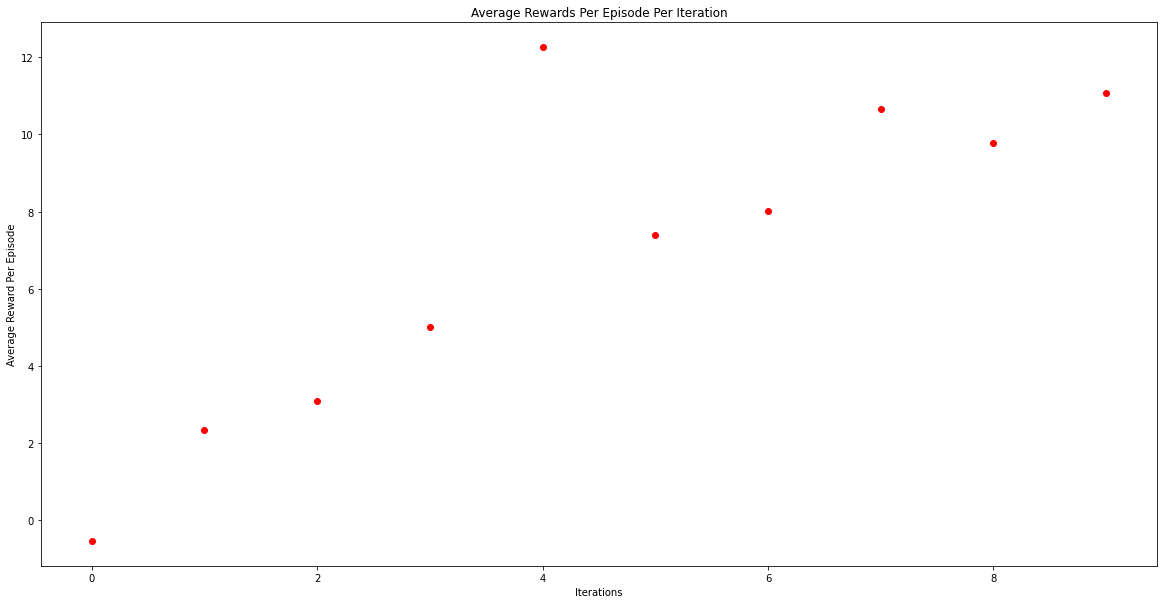

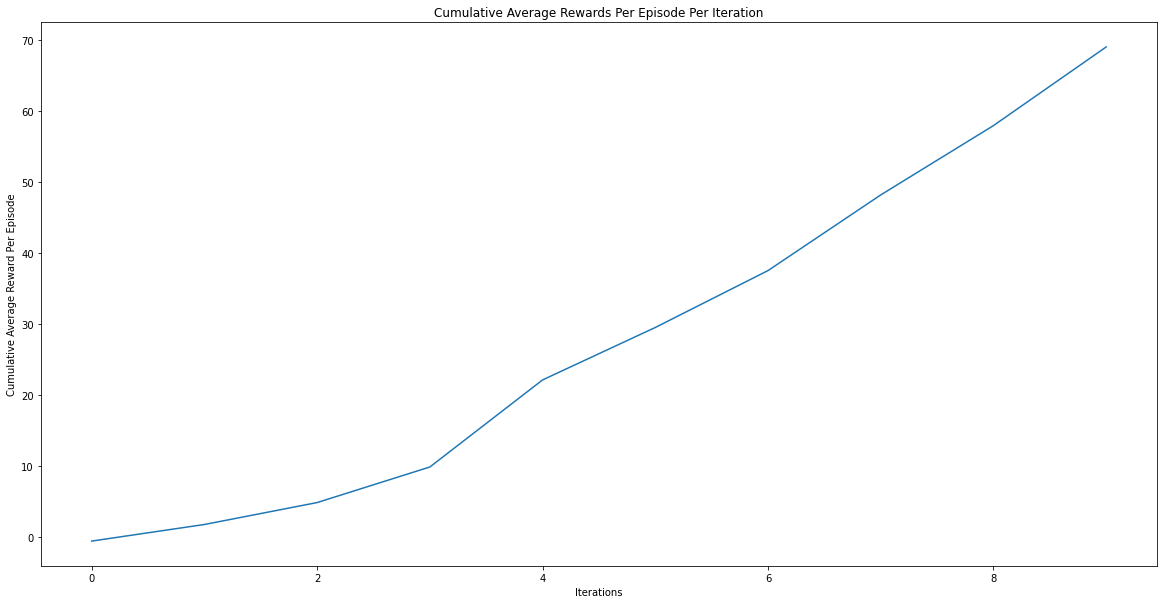

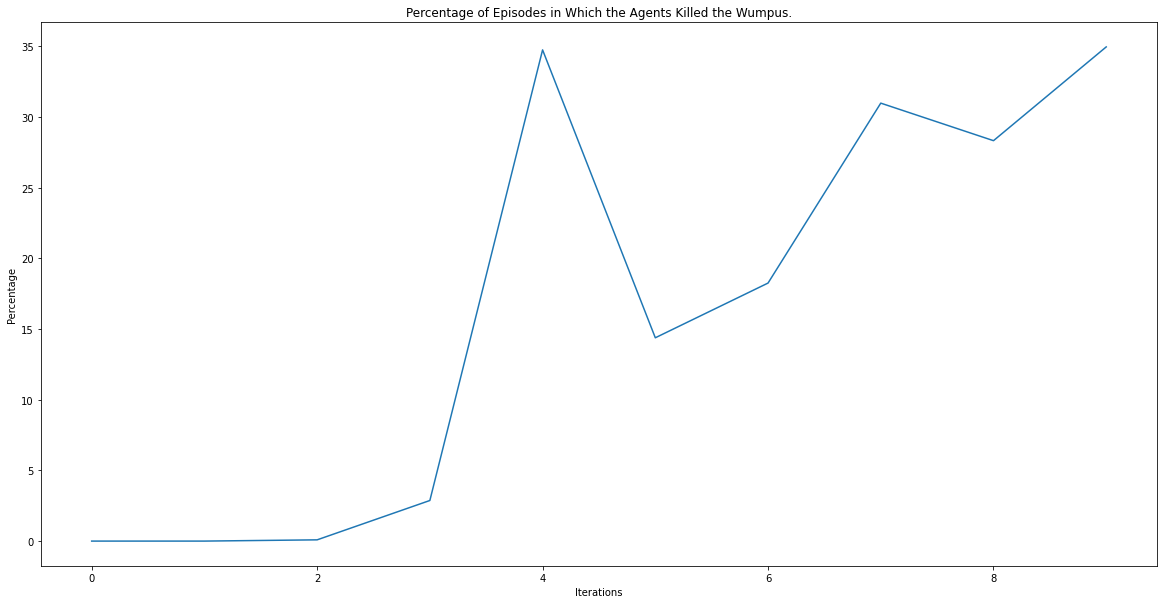


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 6.0
Average penalties incurred per episode: 0.0


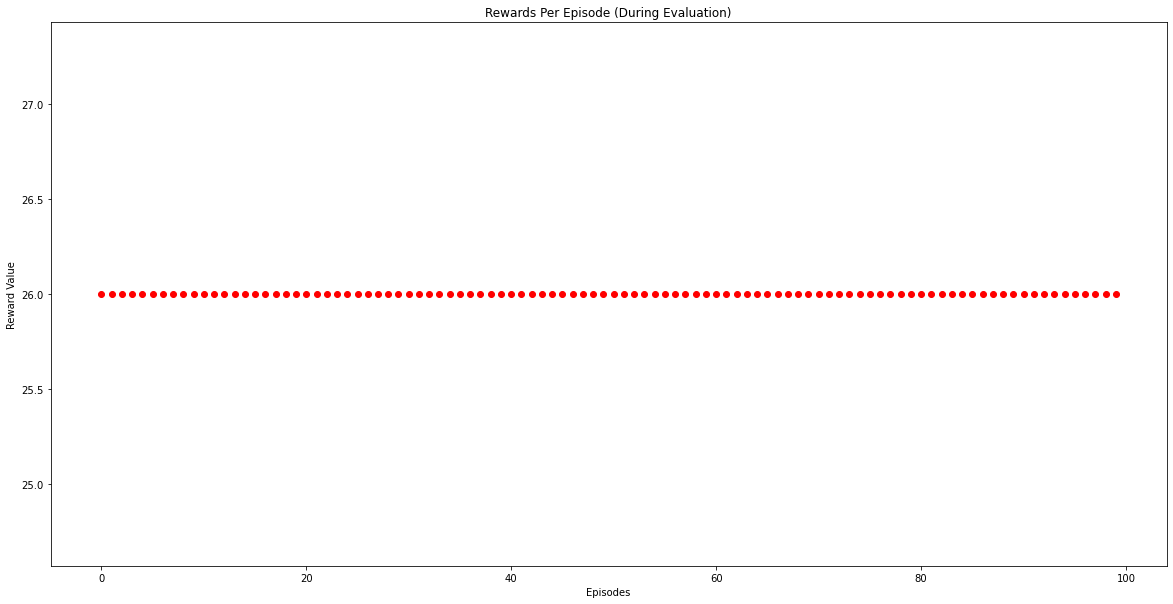

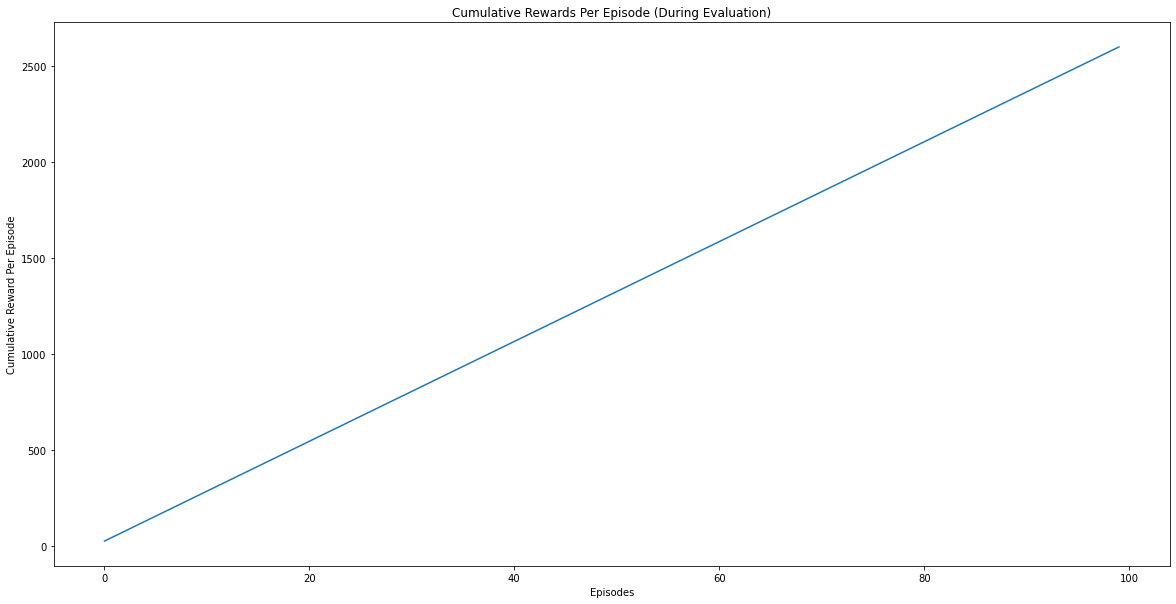

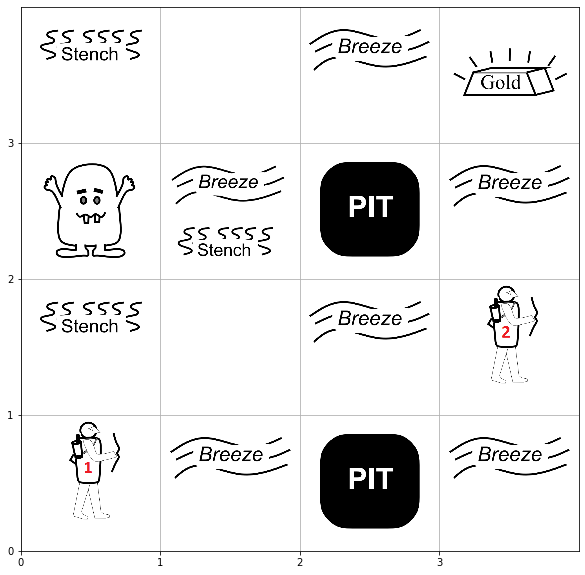

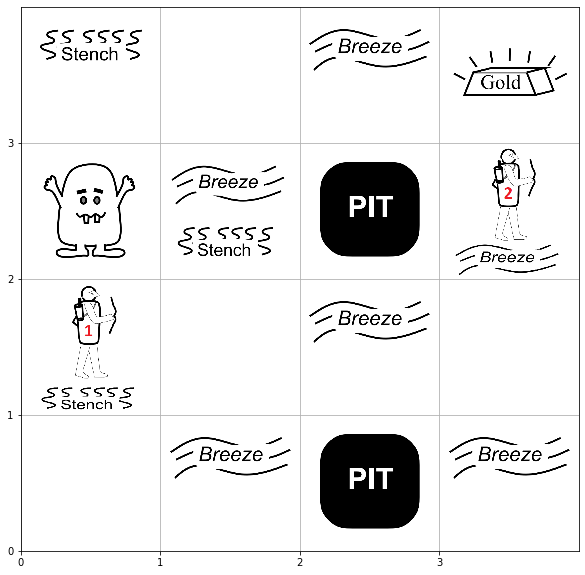

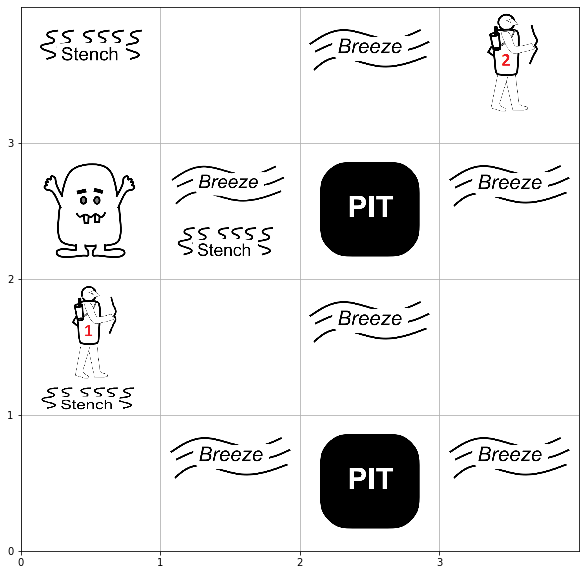

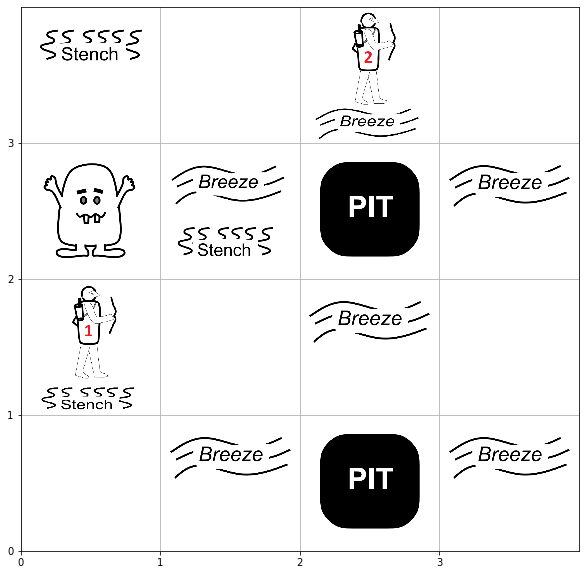

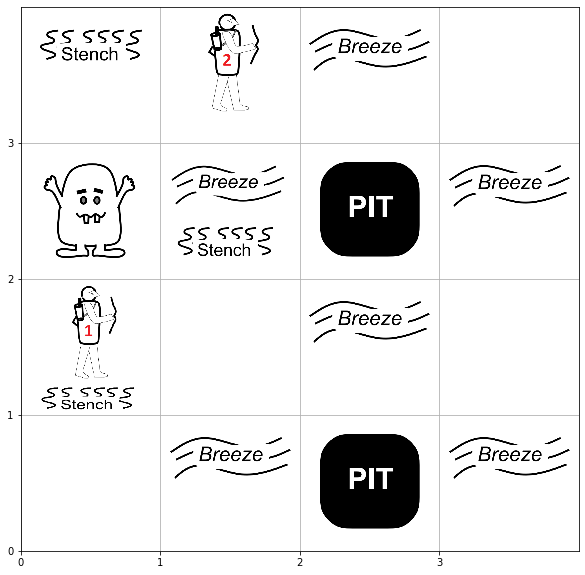

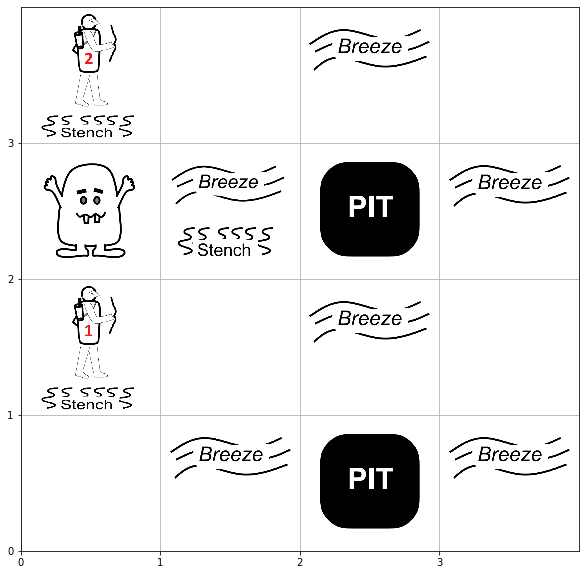

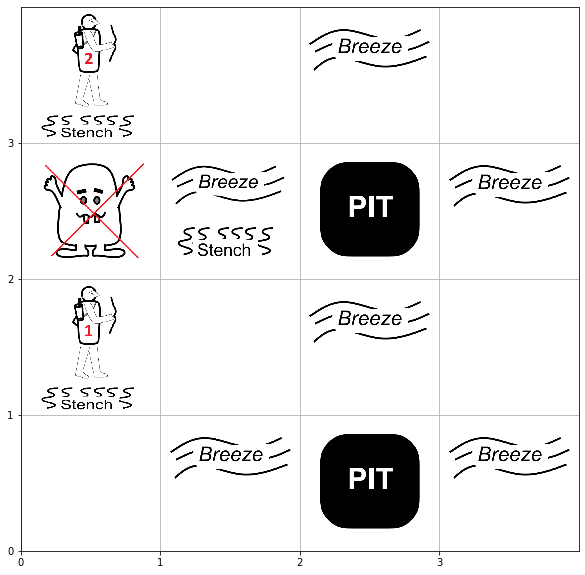

In [15]:
print('Version 1:\n')
AdvantageWeightedRegression(deterministic_multi_agent_wumpus_world_environment, alternate_network=False,
                            offline_memory_size=10000, iterations=10)

Version 2:


Initial Policy Table for Agent 1:
 [[0.15460315 0.16495253 0.19309437 0.16415705 0.17078333 0.15240951]
 [0.15622318 0.16770096 0.17031123 0.1740508  0.16922408 0.16248977]
 [0.         0.         0.         0.         0.         0.        ]
 [0.1579001  0.16474725 0.17439759 0.17268166 0.16525872 0.16501467]
 [0.15964027 0.1578111  0.18058142 0.1676421  0.17417954 0.16014554]
 [0.16556567 0.16332065 0.17206506 0.16628662 0.1685756  0.16418637]
 [0.1547587  0.16852975 0.17311281 0.17044789 0.17143229 0.16171852]
 [0.16071187 0.16668974 0.18187685 0.16298582 0.16523322 0.1625025 ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.15699597 0.16136639 0.17748256 0.16758583 0.17601044 0.16055883]
 [0.         0.         0.         0.         0.         0.        ]
 [0.15167454 0.16492438 0.17910185 0.1706528  0.1770267  0.1566197 ]
 [0.15835057 0.16020484 0.17237538 0.17630057 0.1719142  0.16085446]
 [0.15843956 0.16408433 0.16991445 0.16624634 0.1732188

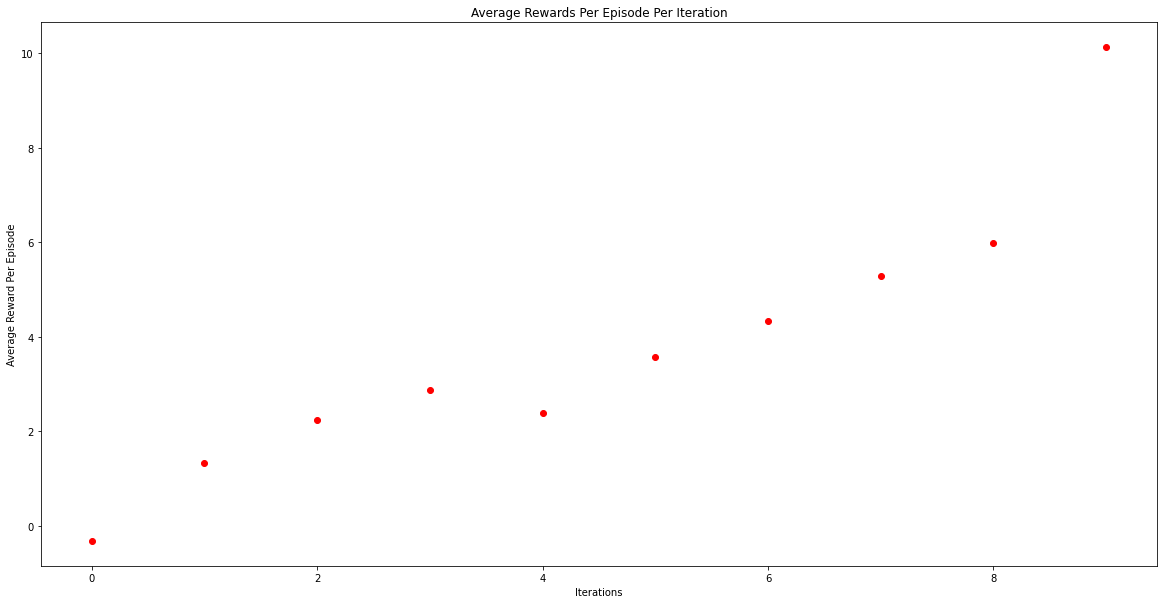

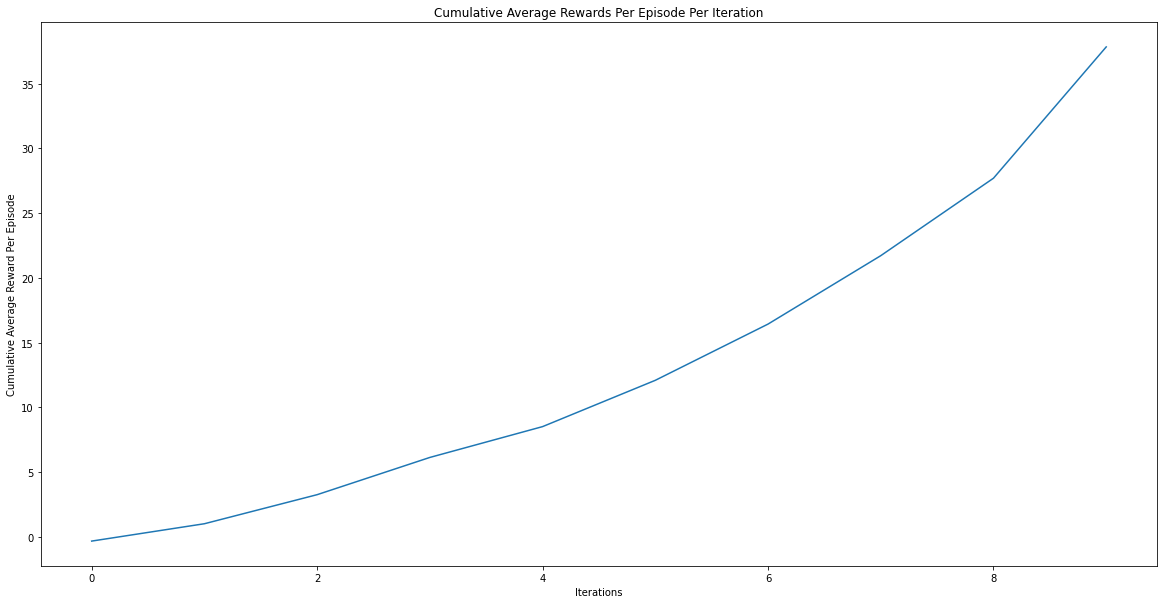

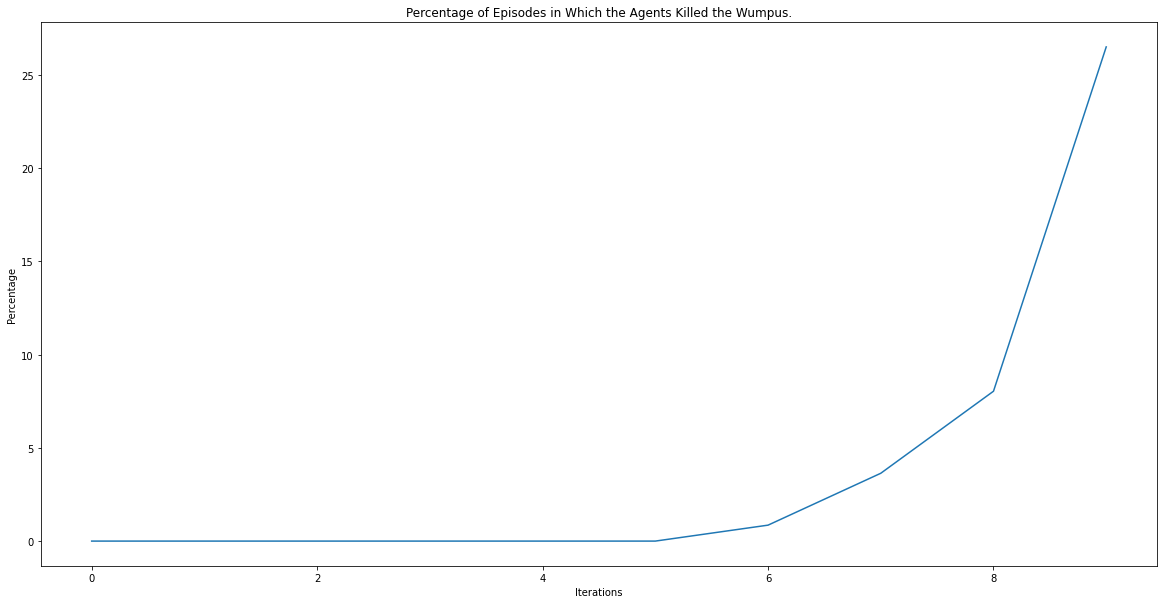


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 6.0
Average penalties incurred per episode: 0.0


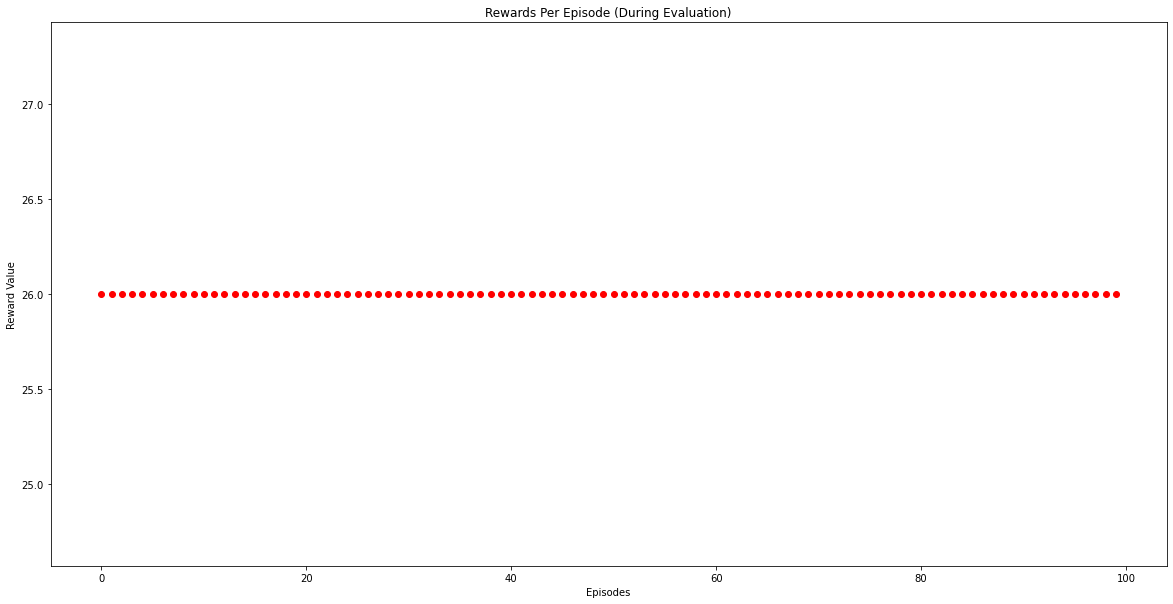

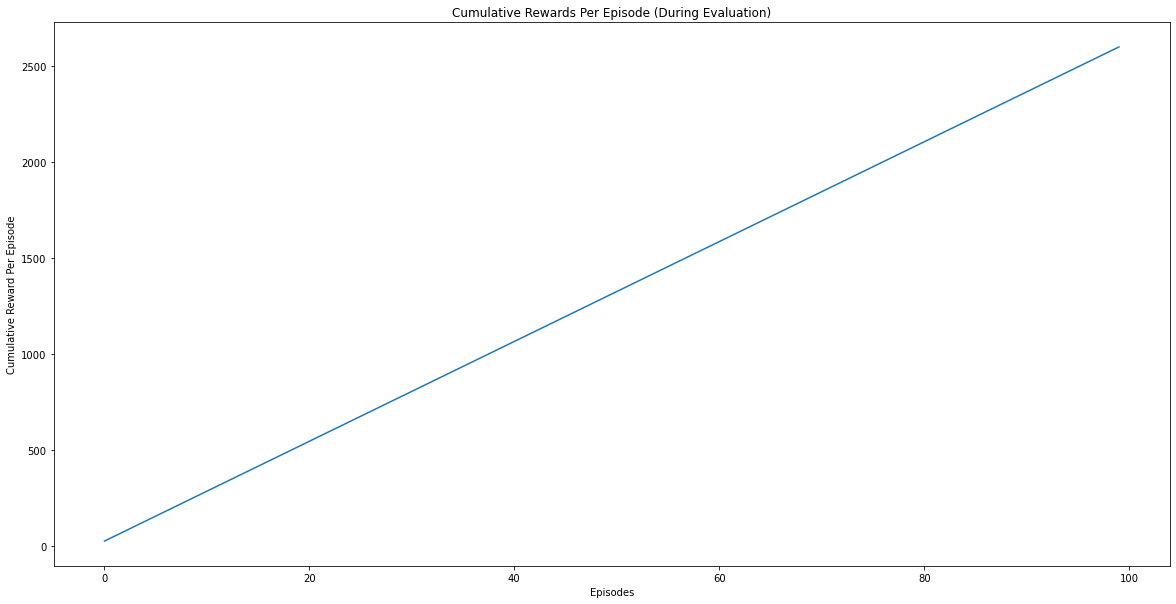

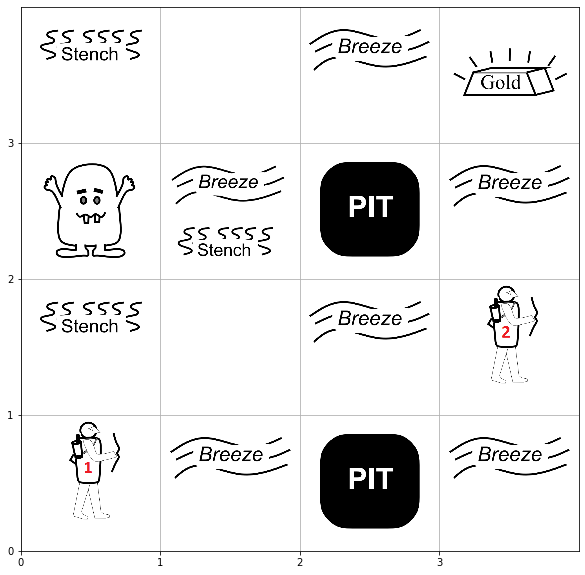

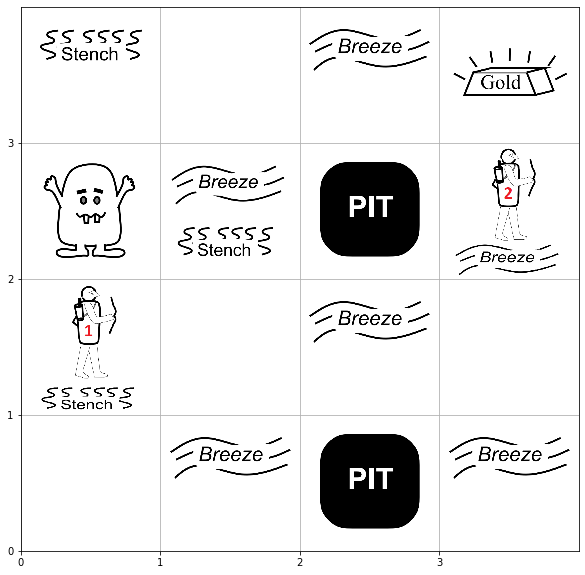

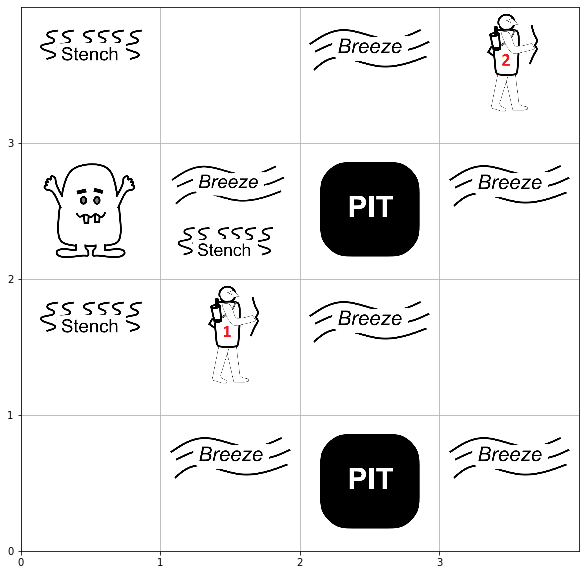

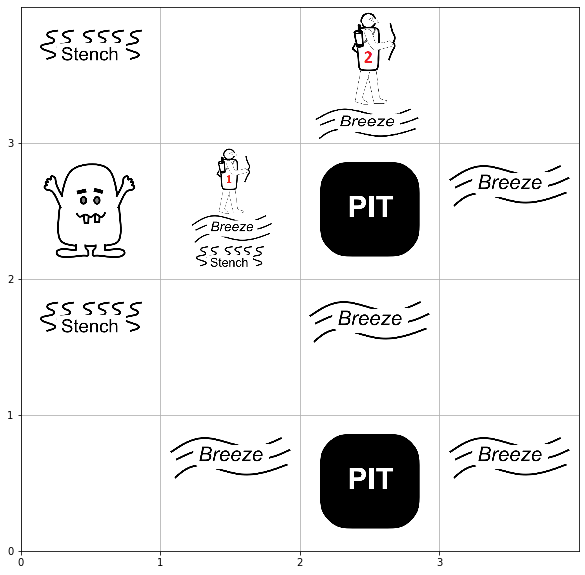

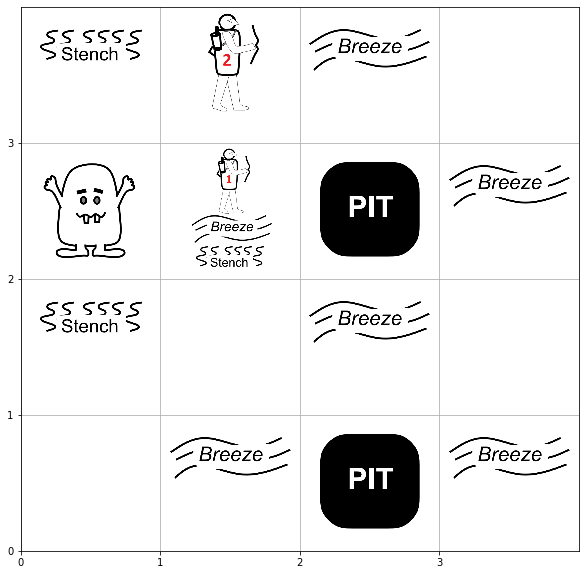

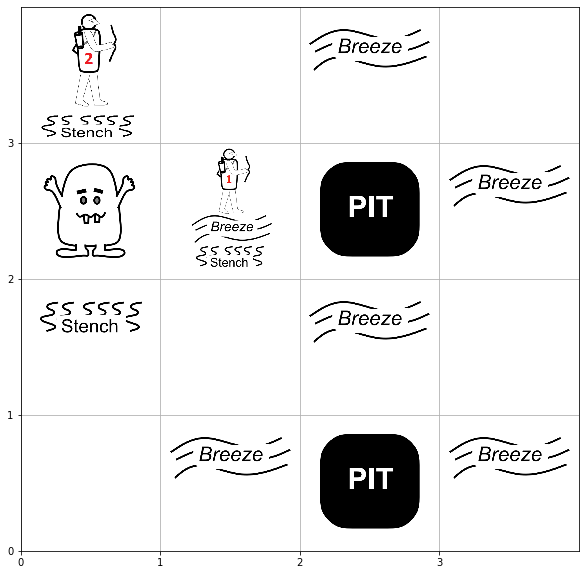

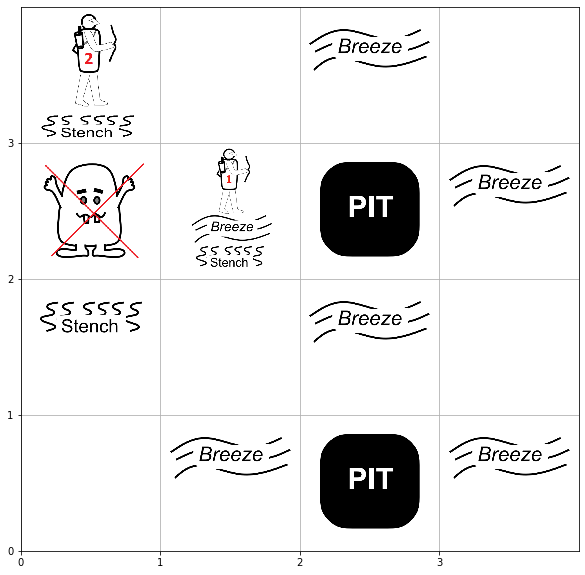

In [16]:
print('Version 2:\n')
AdvantageWeightedRegression(deterministic_multi_agent_wumpus_world_environment, alternate_network=True,
                            offline_memory_size=1000, iterations=10)

Version 3:


Initial Policy Table for Agent 1:
 [[0.16293316 0.1625839  0.1636397  0.17745326 0.16657744 0.16681254]
 [0.17794628 0.16053706 0.15843321 0.18135782 0.16406651 0.1576591 ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16363451 0.1598109  0.16977091 0.16930772 0.16796114 0.1695148 ]
 [0.16750768 0.16268143 0.16037636 0.17498091 0.17097871 0.16347492]
 [0.1712073  0.16622347 0.15798959 0.16999352 0.17062952 0.16395663]
 [0.17753157 0.17103718 0.1579312  0.17112218 0.16553538 0.15684244]
 [0.17161556 0.1690825  0.15778492 0.16982271 0.16537747 0.16631684]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16632654 0.16507408 0.16321288 0.16863789 0.16684301 0.16990565]
 [0.         0.         0.         0.         0.         0.        ]
 [0.1680026  0.16882485 0.16095528 0.17138948 0.17415223 0.15667558]
 [0.1631934  0.17036526 0.15951473 0.17576376 0.1674852  0.16367769]
 [0.16851391 0.16469721 0.16040781 0.1730079  0.1675492

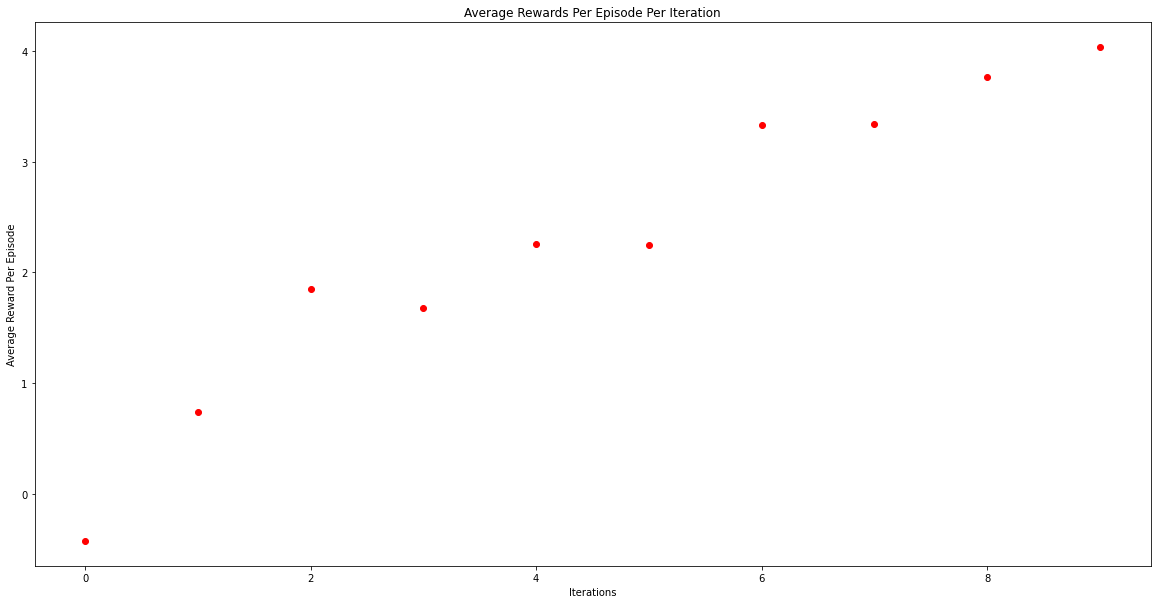

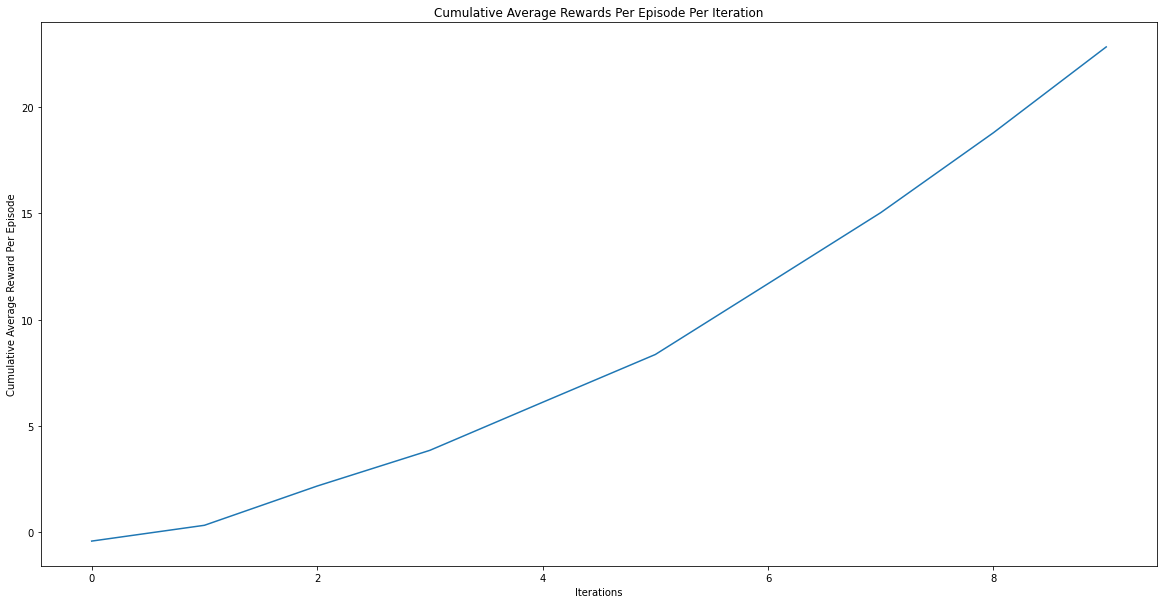

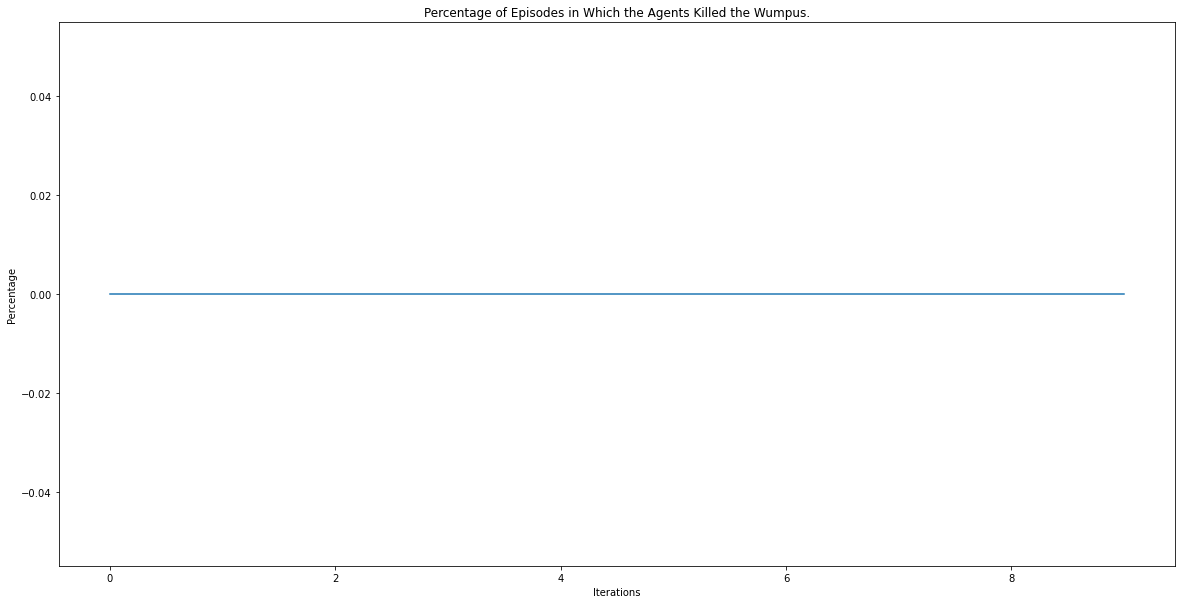


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 10.0
Average penalties incurred per episode: 1.0


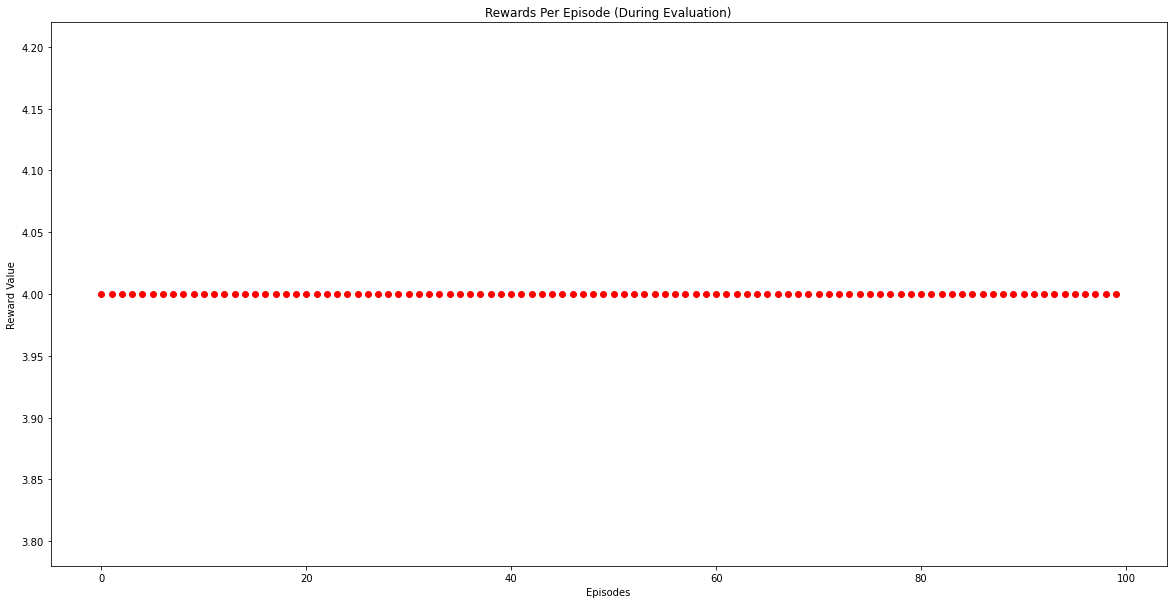

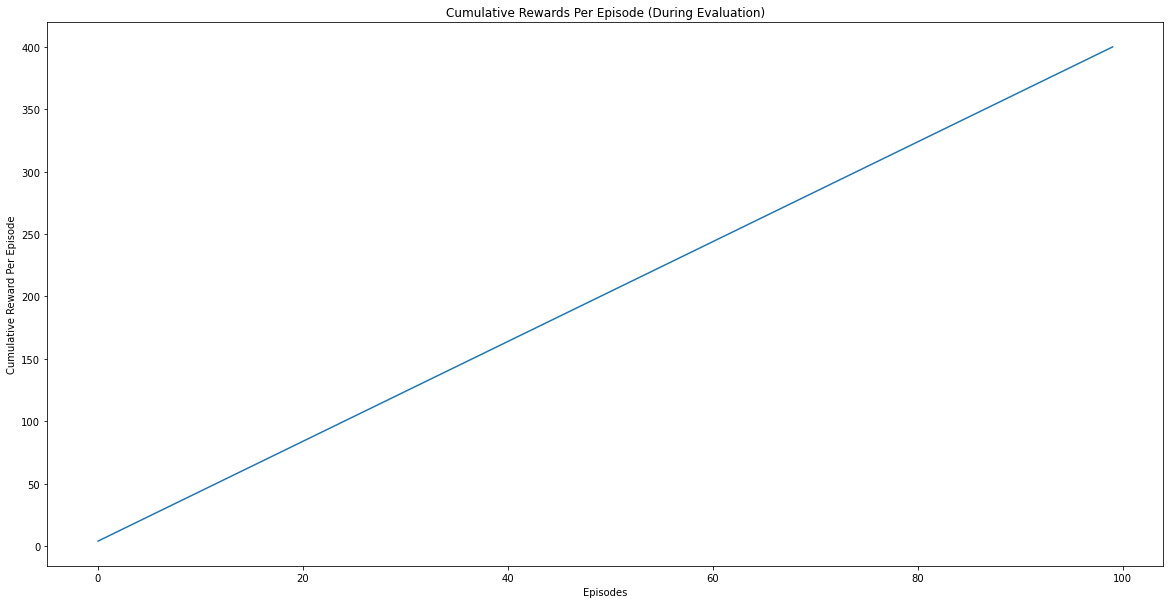

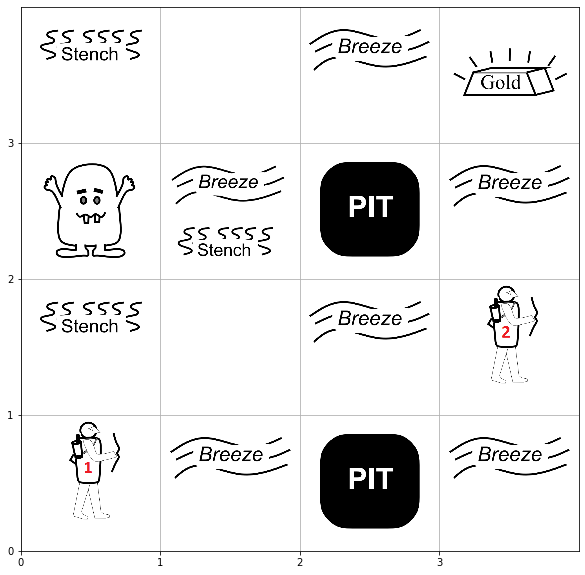

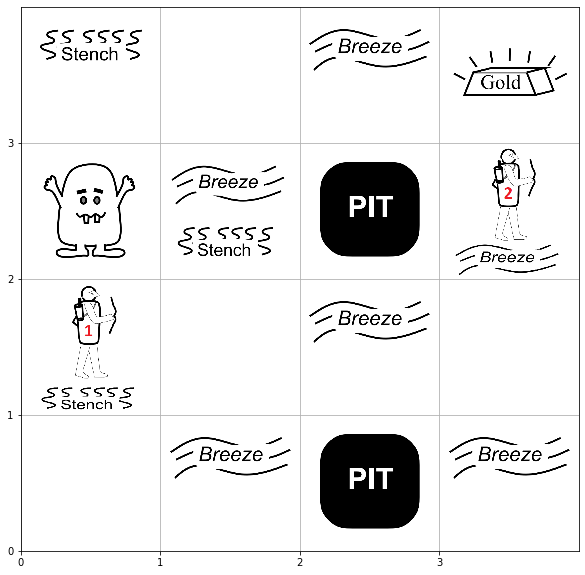

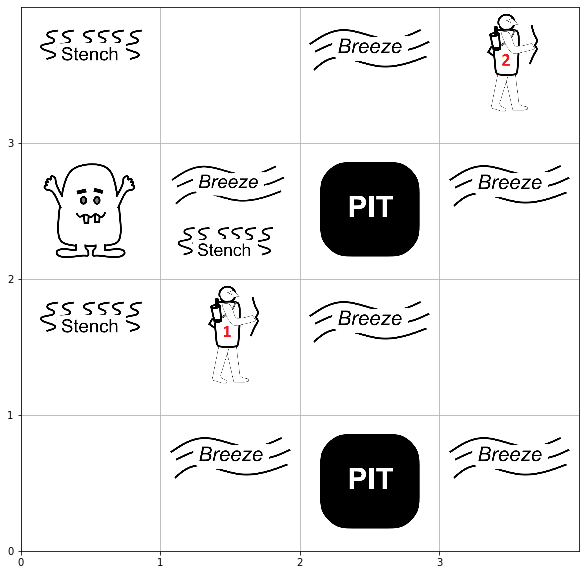

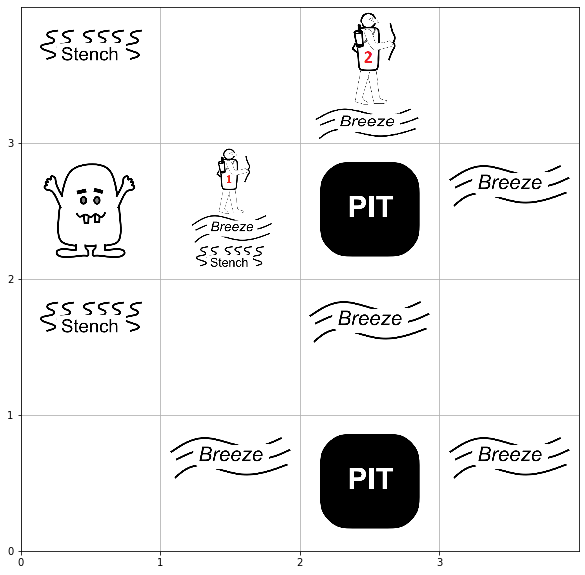

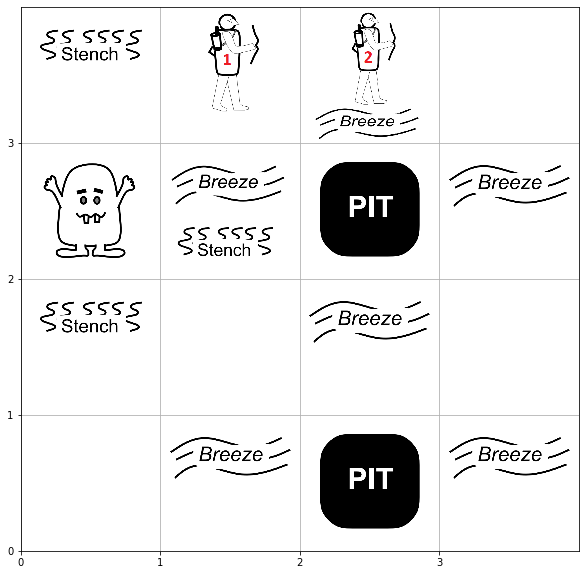

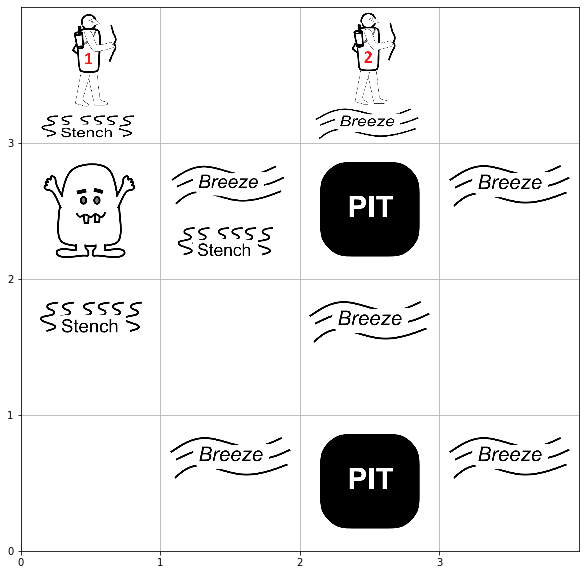

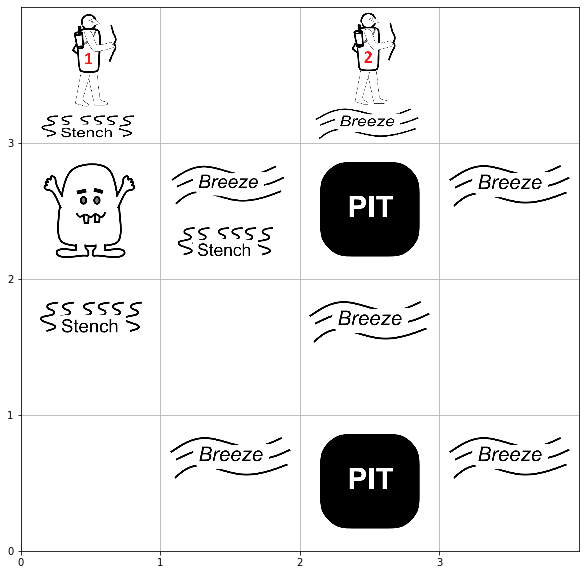

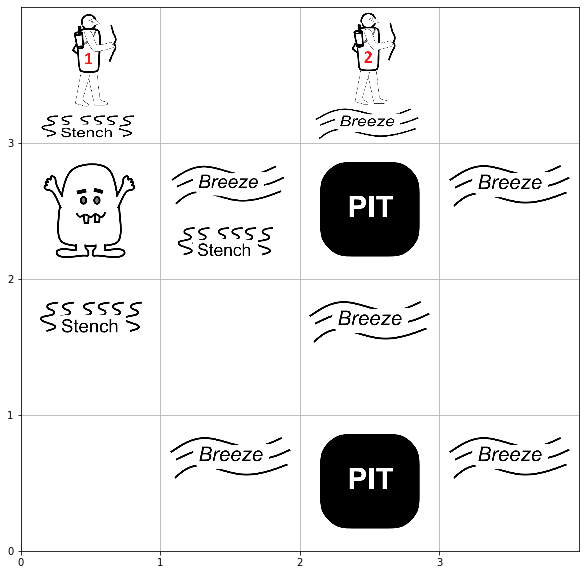

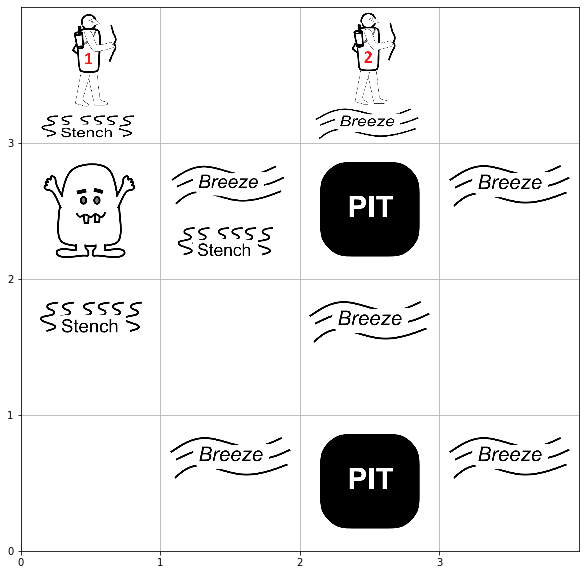

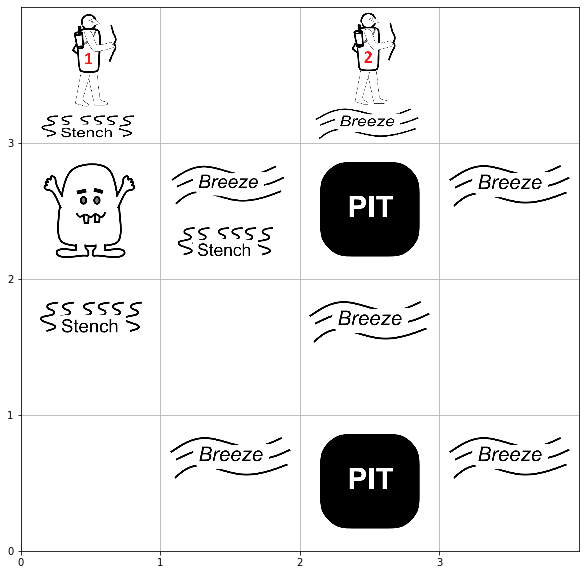

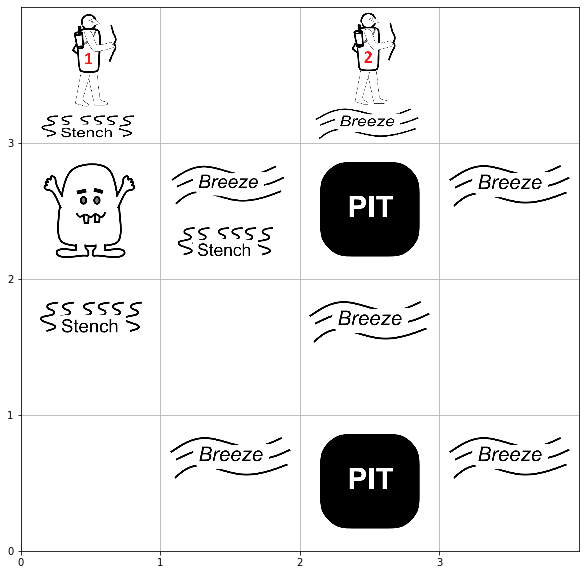

In [17]:
print('Version 3:\n')
AdvantageWeightedRegression(deterministic_multi_agent_wumpus_world_environment, alternate_network=True,
                            offline_memory_size=500, iterations=10)

#### AWR on Stochastic Multi-Agent Wumpus World Environment

Version 1:


Initial Policy Table for Agent 1:
 [[0.17281431 0.16984698 0.15874347 0.16871695 0.15832154 0.17155676]
 [0.17056027 0.16062422 0.16225368 0.1703664  0.15765405 0.17854139]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16875967 0.159231   0.17411806 0.16916195 0.15731221 0.17141712]
 [0.16711816 0.17605998 0.15245211 0.16812728 0.14373688 0.19250563]
 [0.16166663 0.16960439 0.15697016 0.16253081 0.17063408 0.17859393]
 [0.17866695 0.17174017 0.1672485  0.14072418 0.17637575 0.16524446]
 [0.16887687 0.17076537 0.17611754 0.15623523 0.14247416 0.18553081]
 [0.         0.         0.         0.         0.         0.        ]
 [0.18273169 0.17126596 0.16034113 0.16987479 0.16024235 0.15554406]
 [0.         0.         0.         0.         0.         0.        ]
 [0.15001433 0.19461167 0.14912574 0.16047153 0.16670261 0.17907414]
 [0.17219251 0.16486758 0.16750593 0.15900984 0.16364793 0.17277622]
 [0.16053255 0.1644616  0.159584   0.18268806 0.1580966

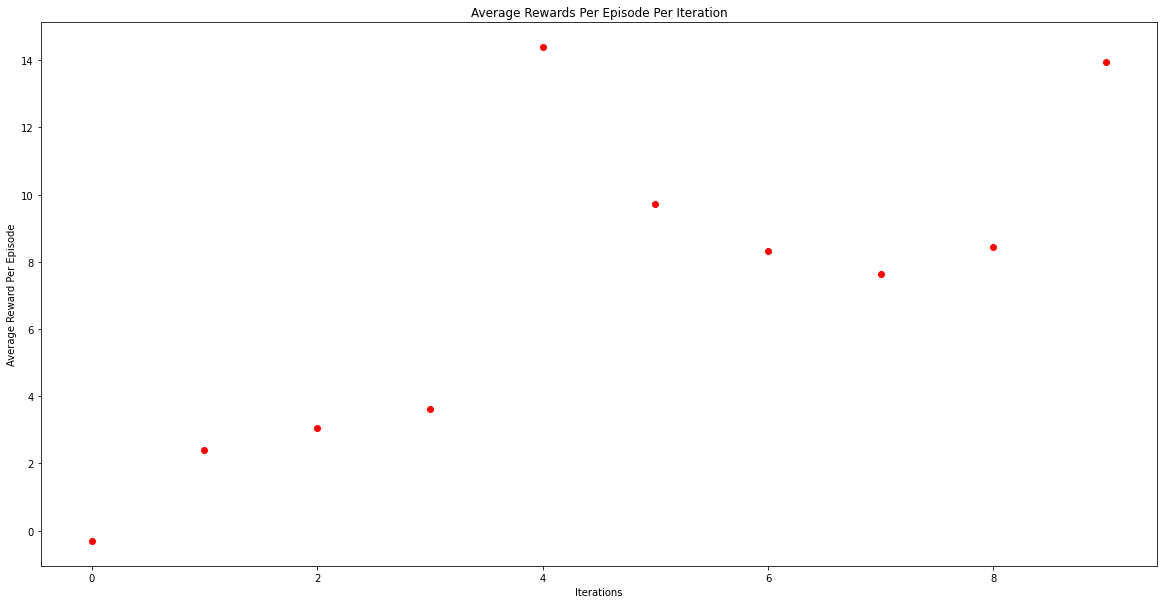

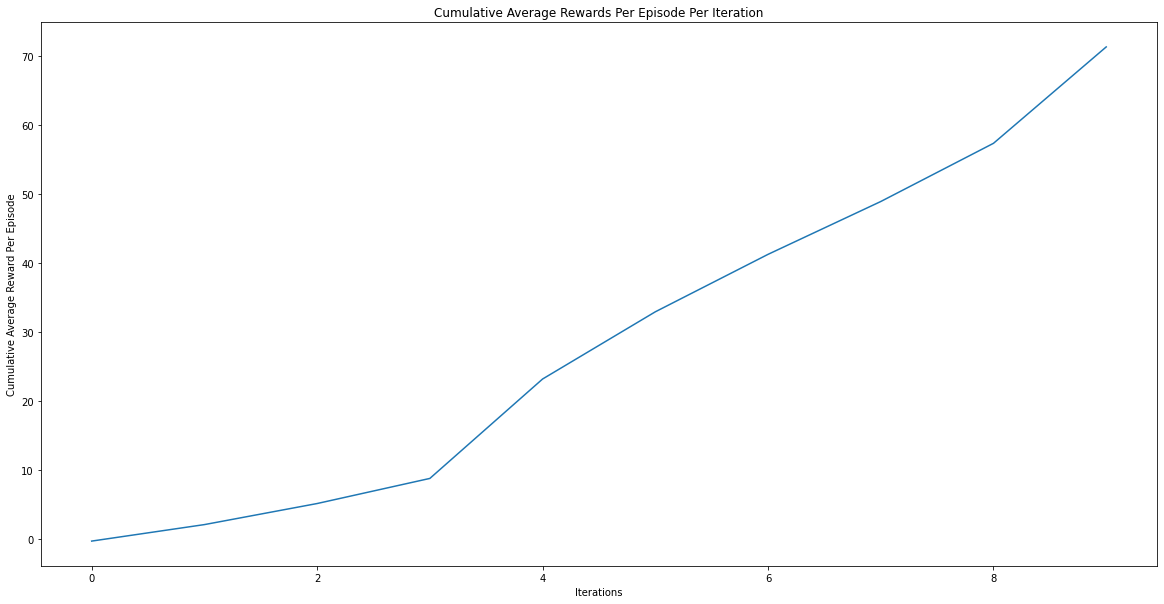

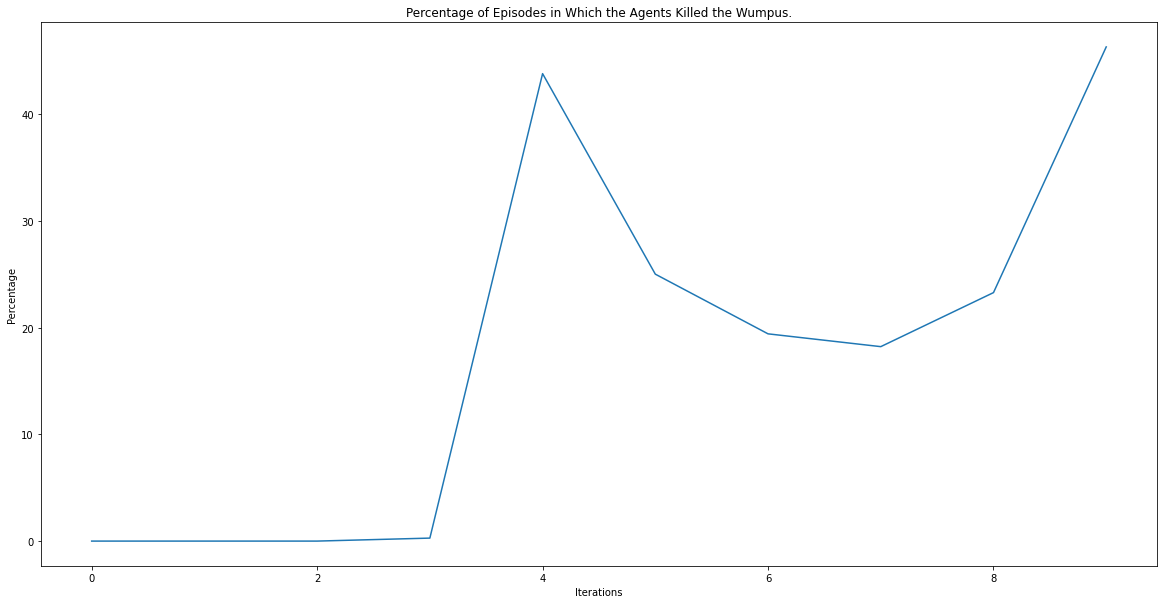


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 6.43
Average penalties incurred per episode: 0.0


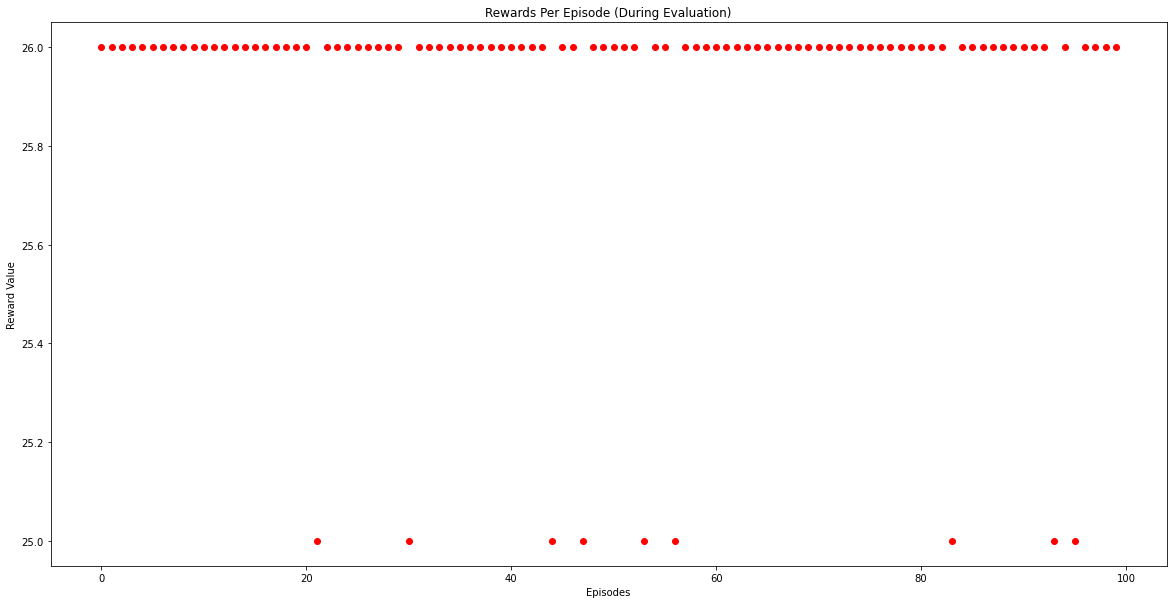

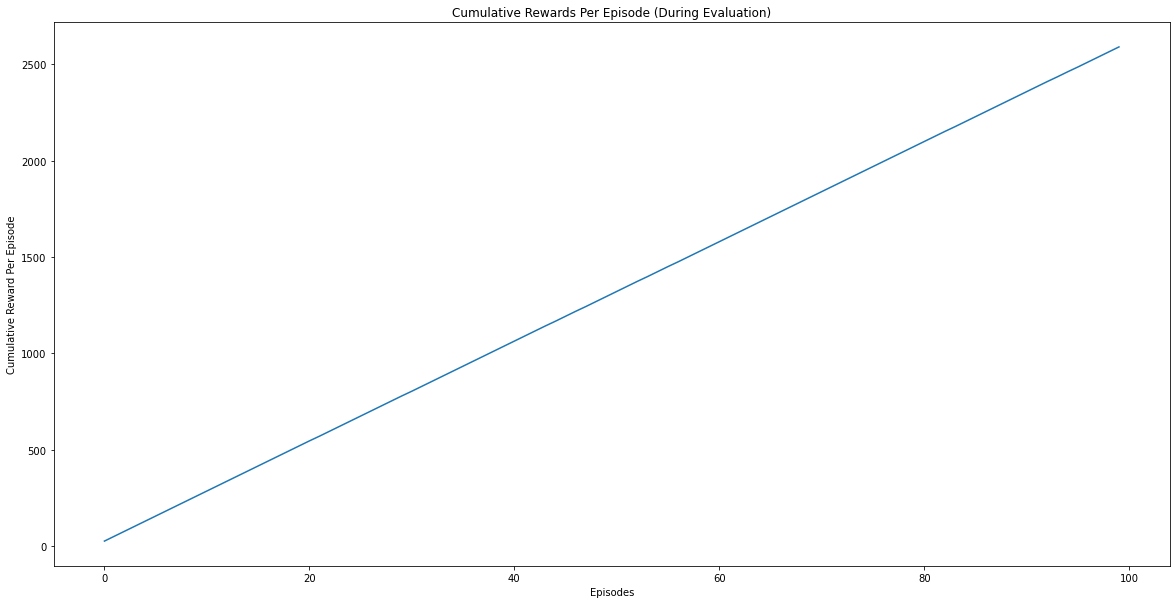

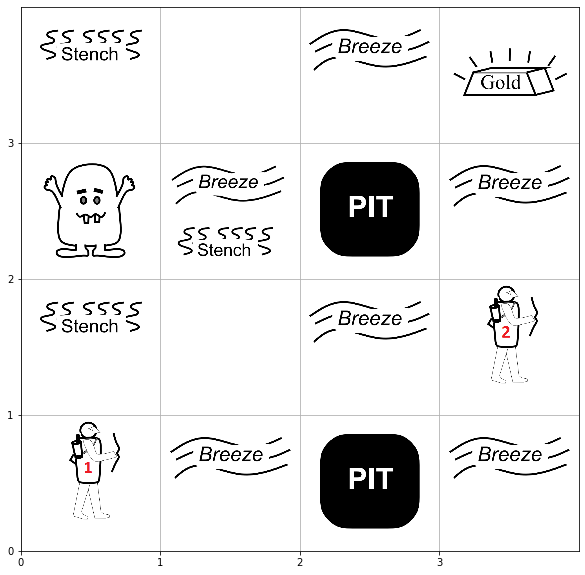

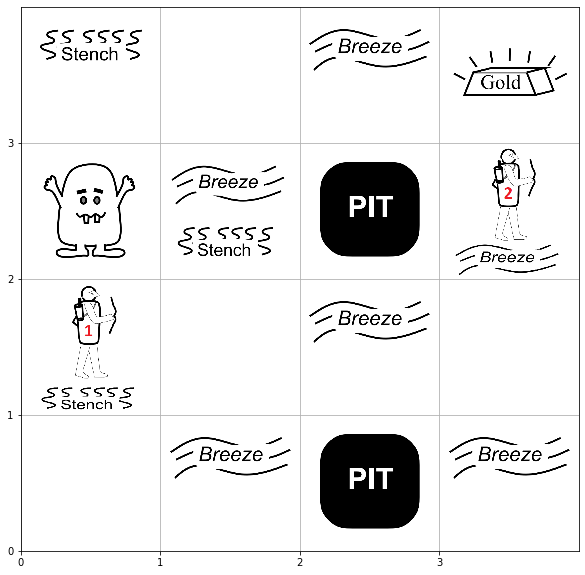

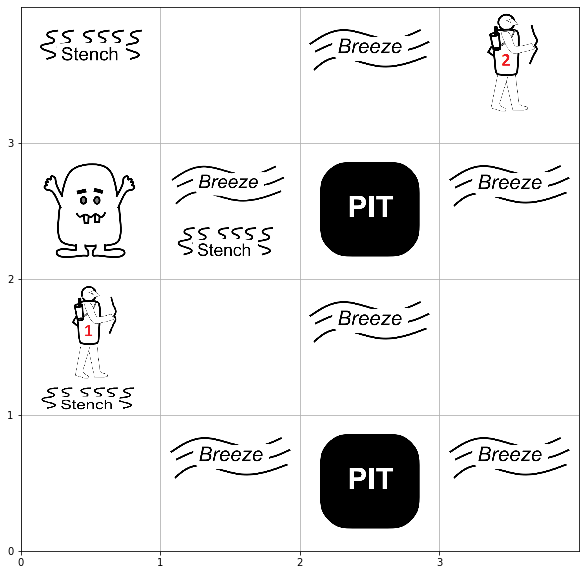

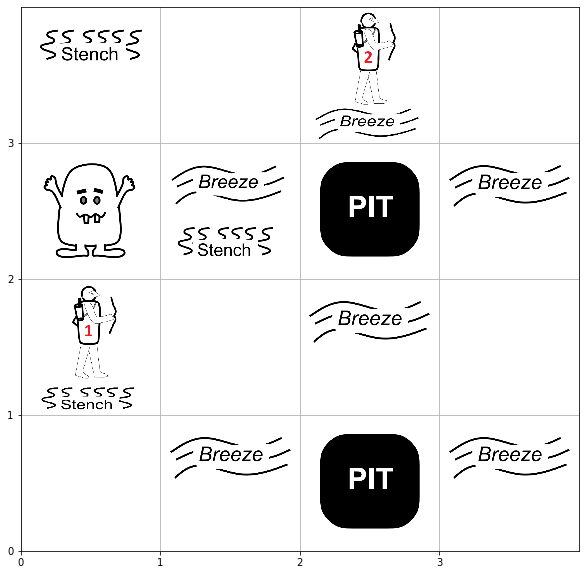

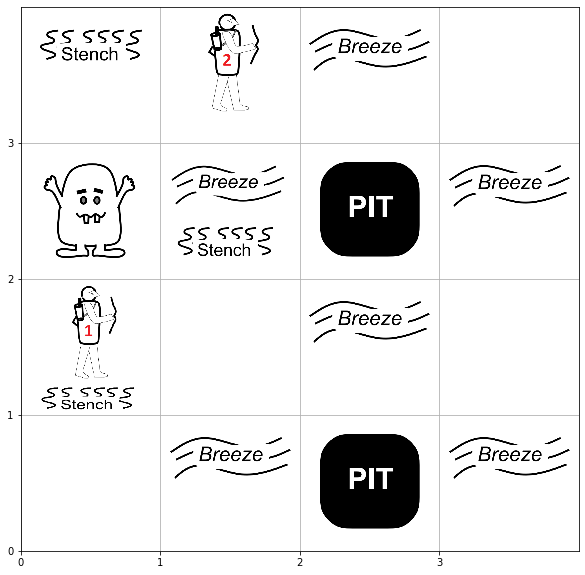

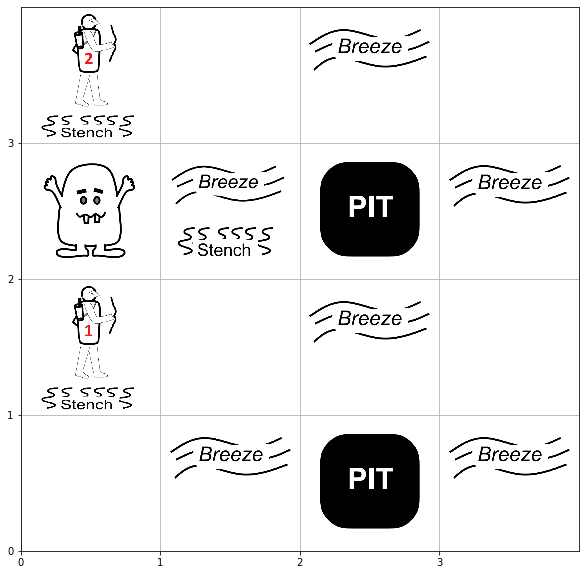

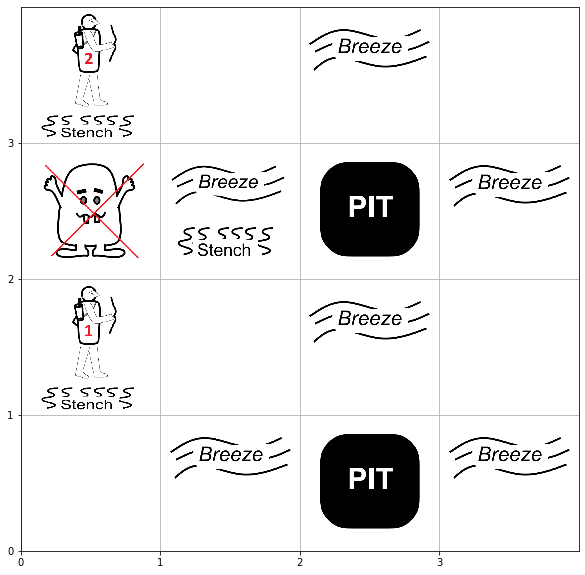

In [18]:
print('Version 1:\n')
AdvantageWeightedRegression(stochastic_multi_agent_wumpus_world_environment, alternate_network=False,
                            offline_memory_size=10000, iterations=10)

Version 2:


Initial Policy Table for Agent 1:
 [[0.16388911 0.17172977 0.16656876 0.16565514 0.16558577 0.16657148]
 [0.16240376 0.17418109 0.17136529 0.16469799 0.16727449 0.16007736]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16864738 0.1750436  0.165564   0.16207887 0.16019103 0.1684751 ]
 [0.16316804 0.17479561 0.17374735 0.16199109 0.1648283  0.16146964]
 [0.16580693 0.16987504 0.16984166 0.16752684 0.16090201 0.1660475 ]
 [0.16765057 0.17197436 0.16995606 0.15826577 0.16571467 0.16643861]
 [0.1639604  0.16367105 0.1749964  0.16916585 0.16393124 0.164275  ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.17203985 0.16814142 0.16817725 0.16992188 0.16125612 0.16046347]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16767688 0.17436929 0.1657853  0.16978705 0.15861371 0.16376778]
 [0.16502163 0.1693215  0.16573575 0.16978413 0.16142415 0.16871284]
 [0.16648883 0.16665044 0.16677804 0.16812107 0.1690923

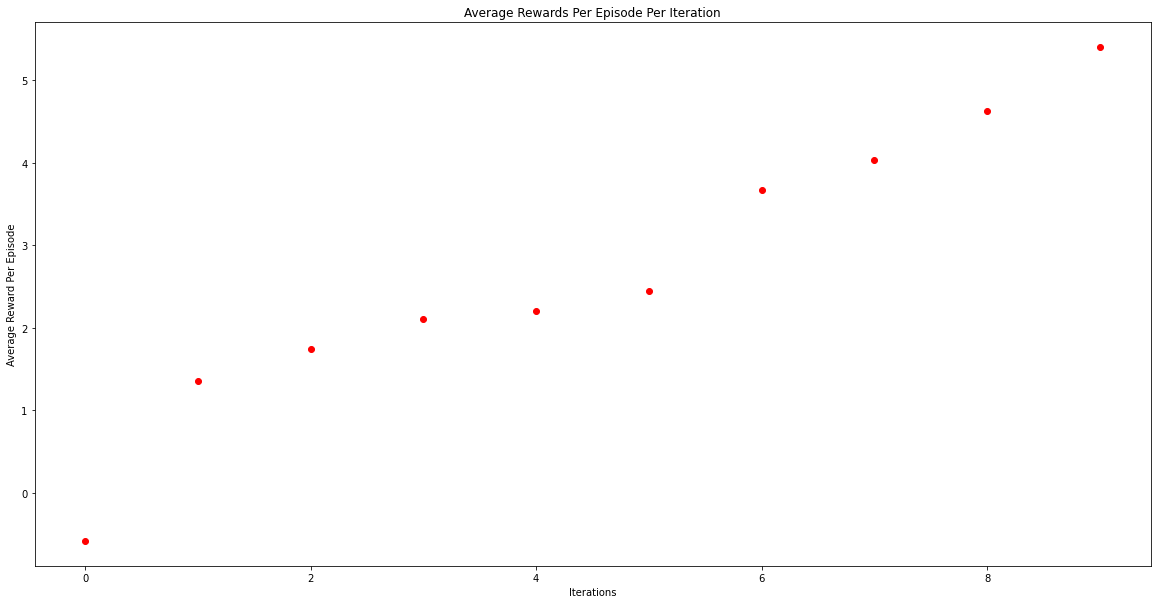

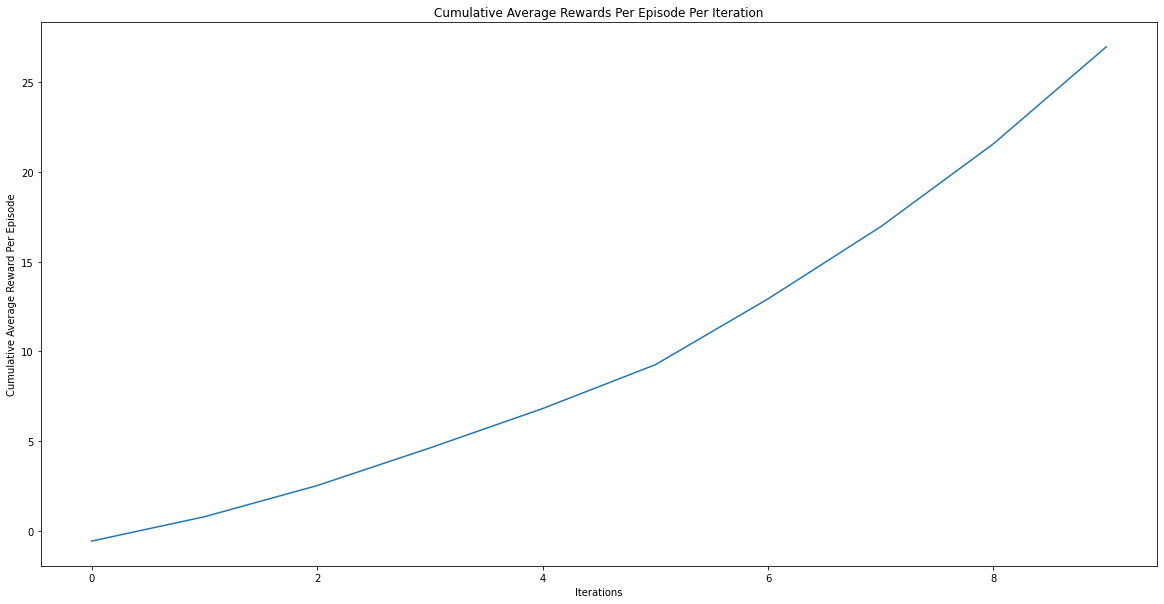

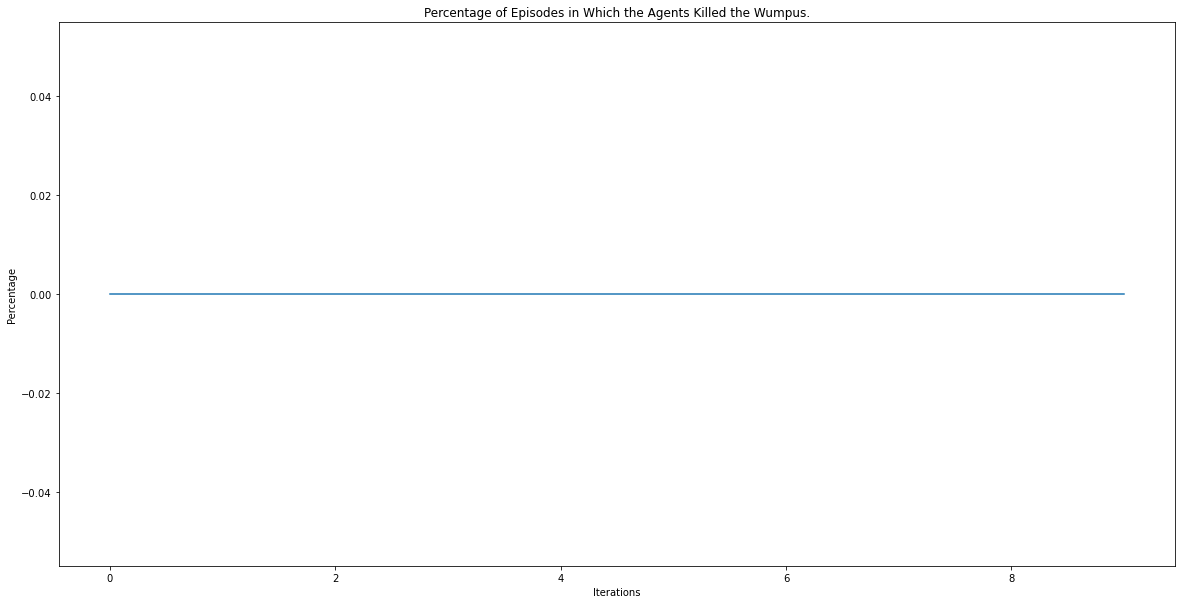


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 10.0
Average penalties incurred per episode: 1.07


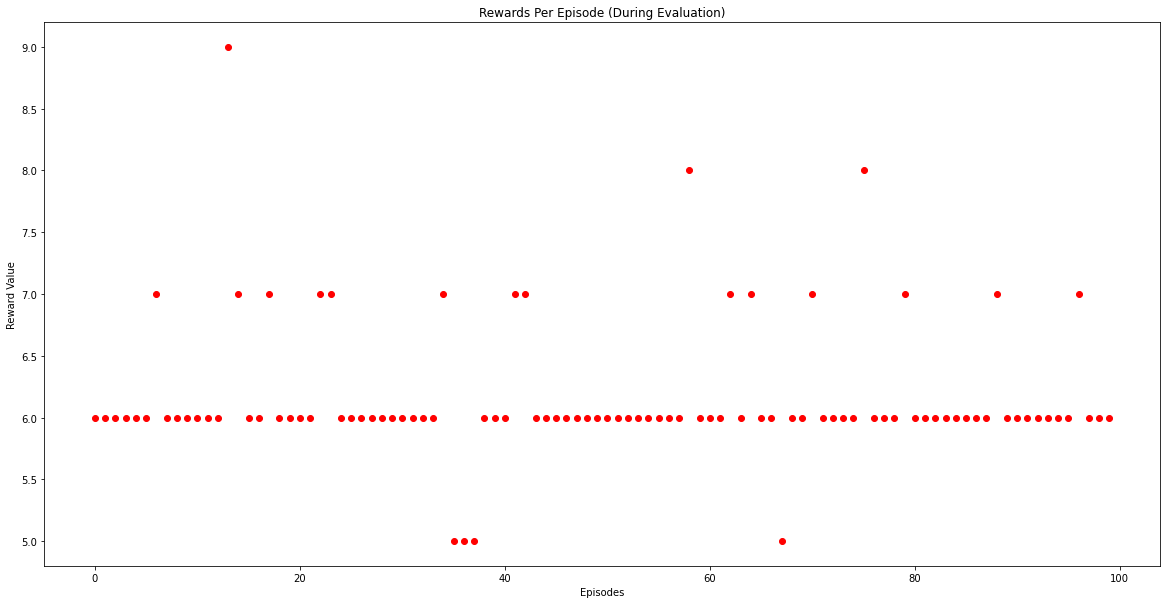

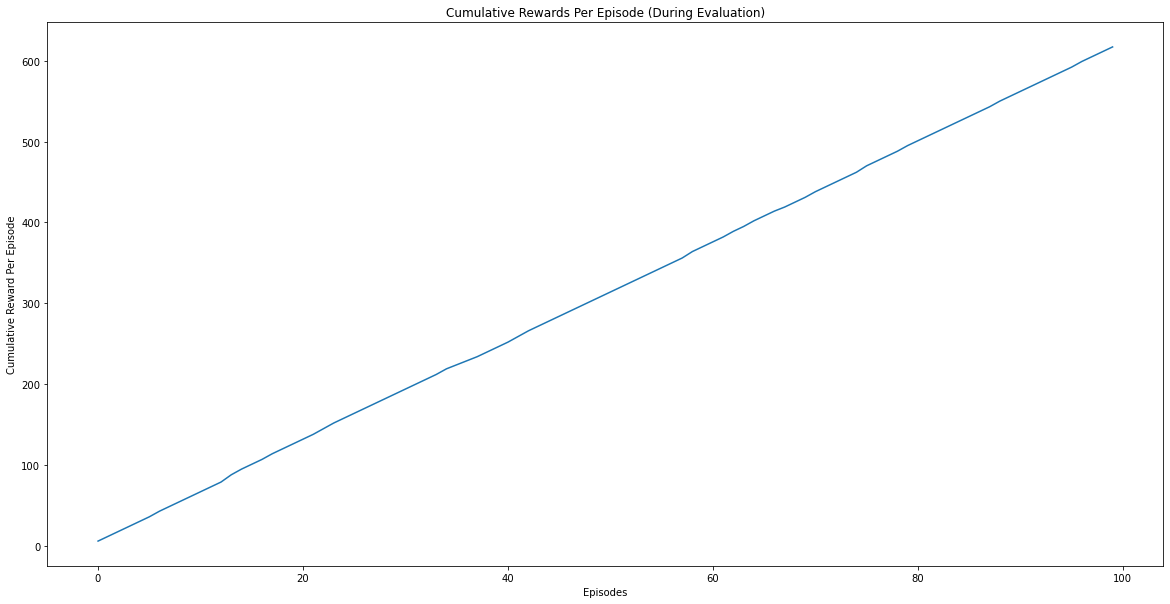

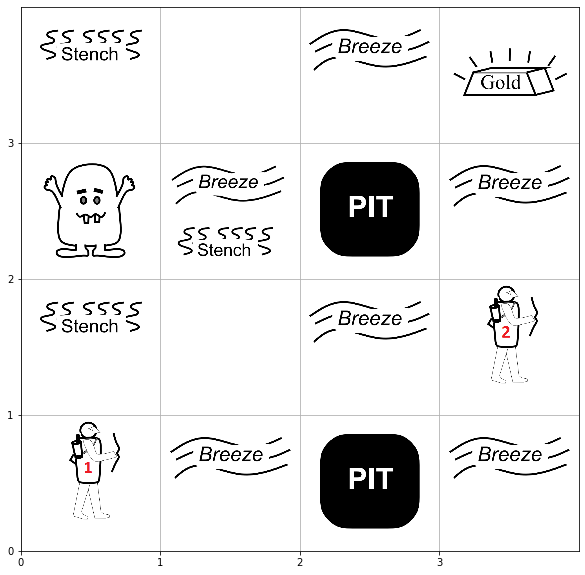

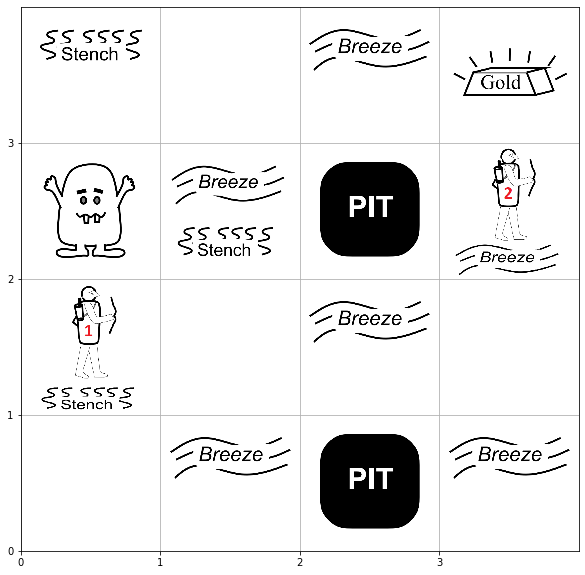

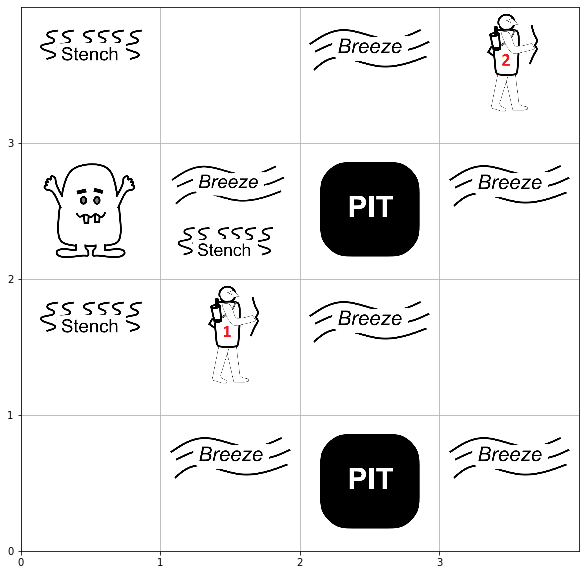

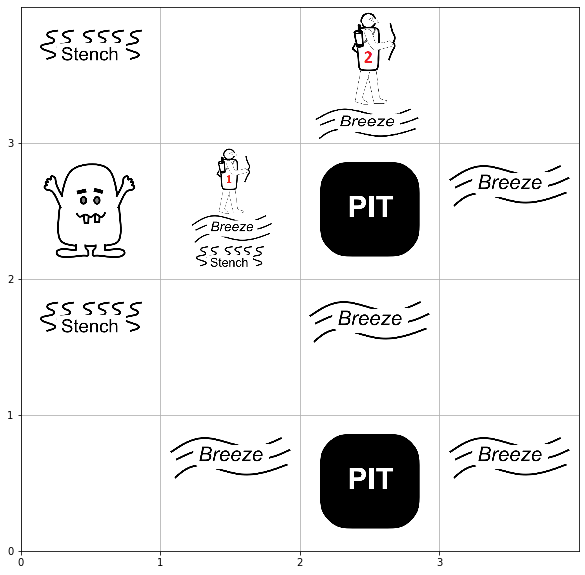

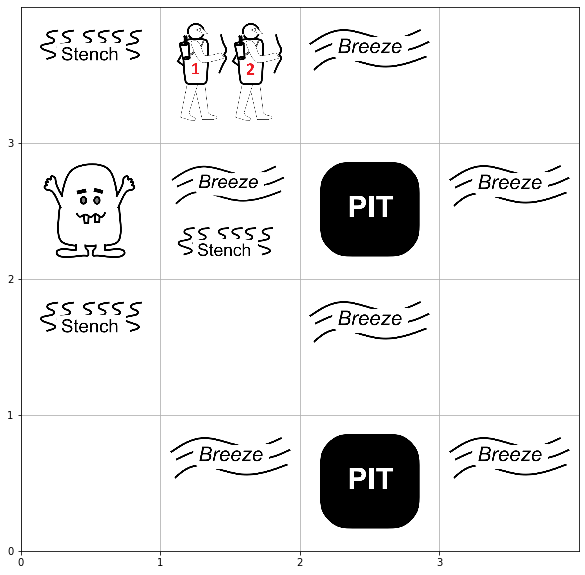

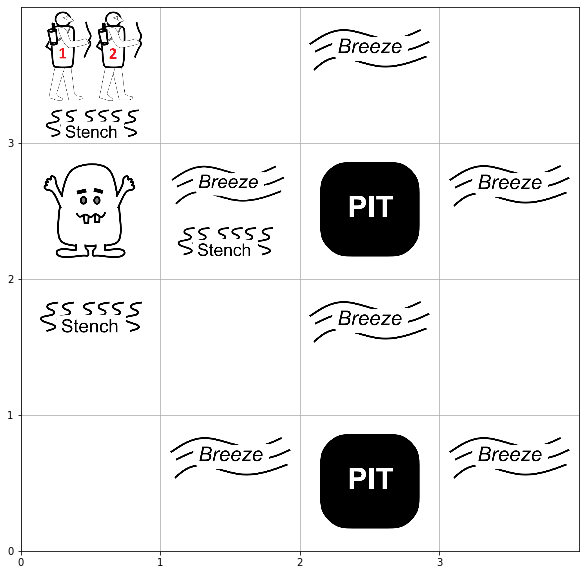

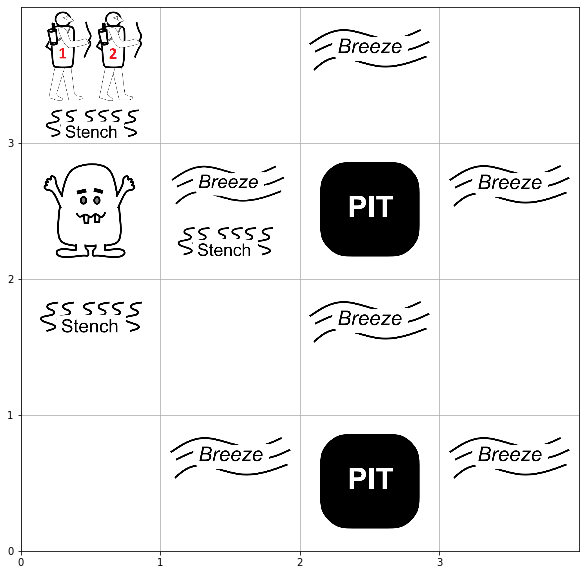

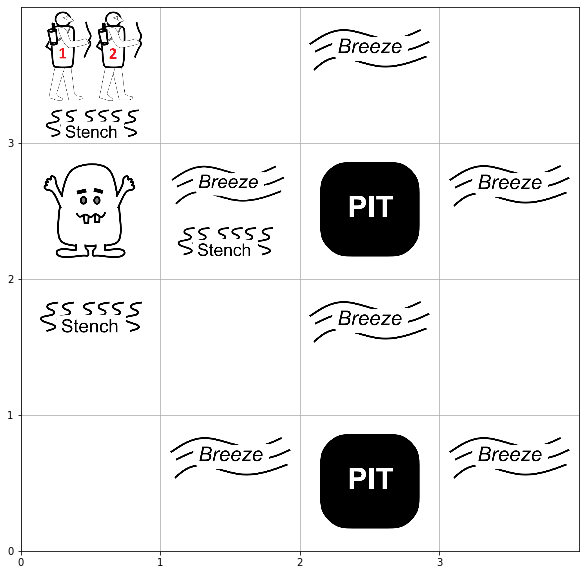

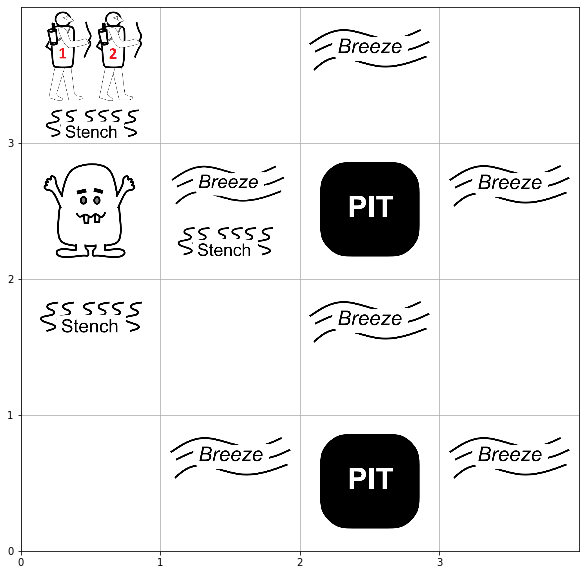

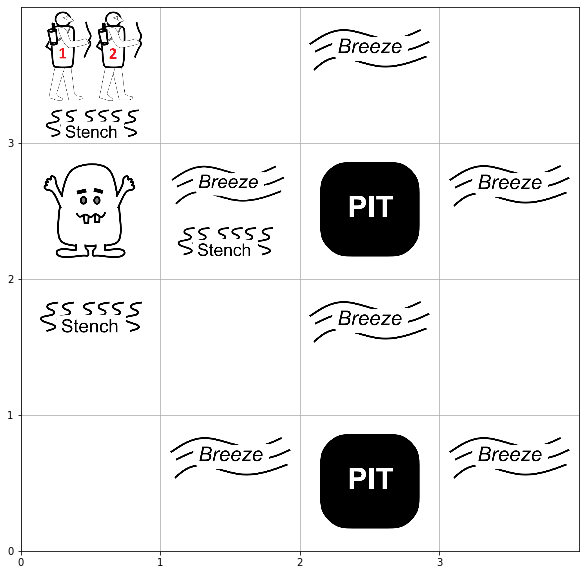

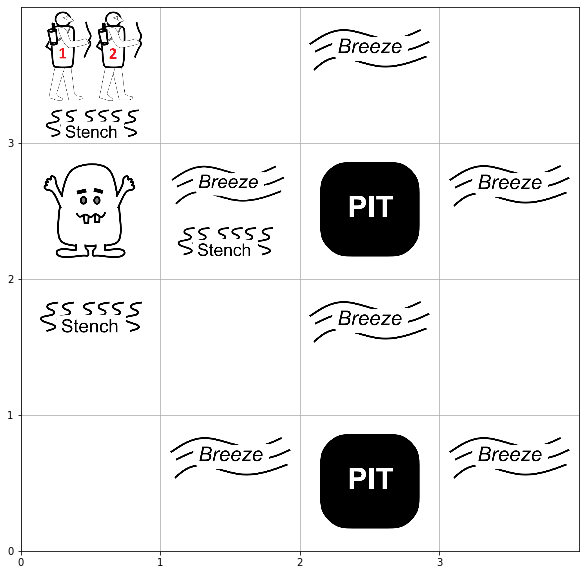

In [19]:
print('Version 2:\n')
AdvantageWeightedRegression(stochastic_multi_agent_wumpus_world_environment, alternate_network=True,
                            offline_memory_size=1000, iterations=10)

Version 3:


Initial Policy Table for Agent 1:
 [[0.1681208  0.15846492 0.17073727 0.16889116 0.16666323 0.1671226 ]
 [0.16316877 0.15901501 0.1698817  0.17099984 0.16495055 0.17198412]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16746235 0.16121699 0.16886857 0.1746013  0.16858909 0.15926175]
 [0.1683894  0.16516995 0.16886632 0.1699385  0.16206509 0.16557075]
 [0.16034529 0.1678781  0.171942   0.17619981 0.15643391 0.16720092]
 [0.16207492 0.16715515 0.17204982 0.17581548 0.16162089 0.1612837 ]
 [0.16385037 0.1615372  0.17352979 0.17240632 0.16245951 0.1662168 ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16461611 0.16517477 0.17140913 0.1660132  0.16570851 0.1670783 ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.16538428 0.16136843 0.16838066 0.17779881 0.16139492 0.16567294]
 [0.16546002 0.16524646 0.16527496 0.17094149 0.16194464 0.17113239]
 [0.17118044 0.15850106 0.16759637 0.16924459 0.1618437

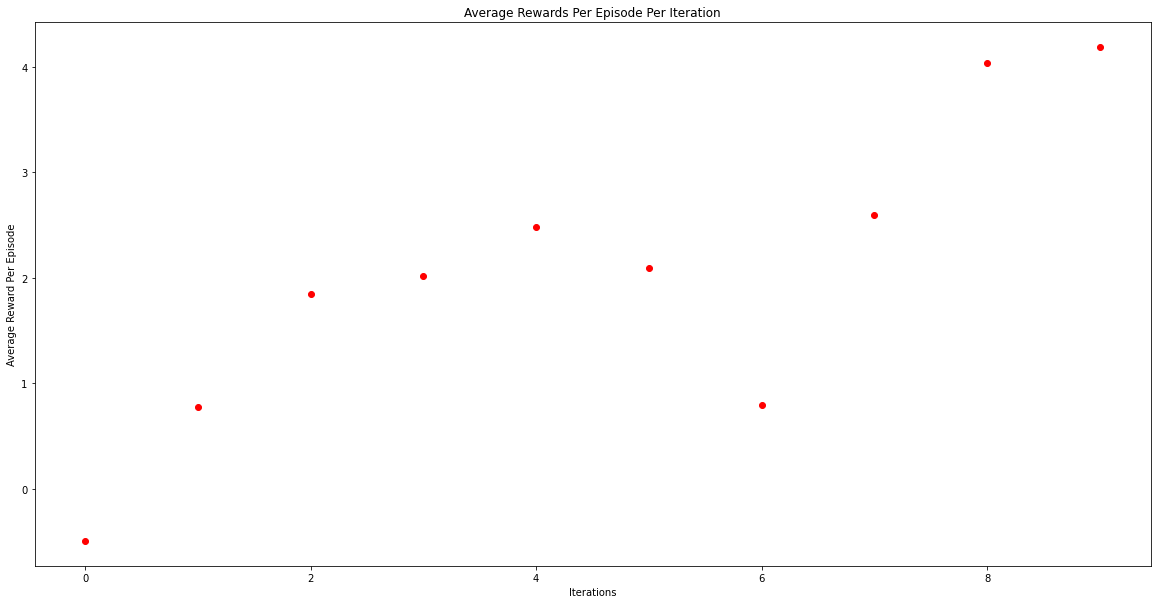

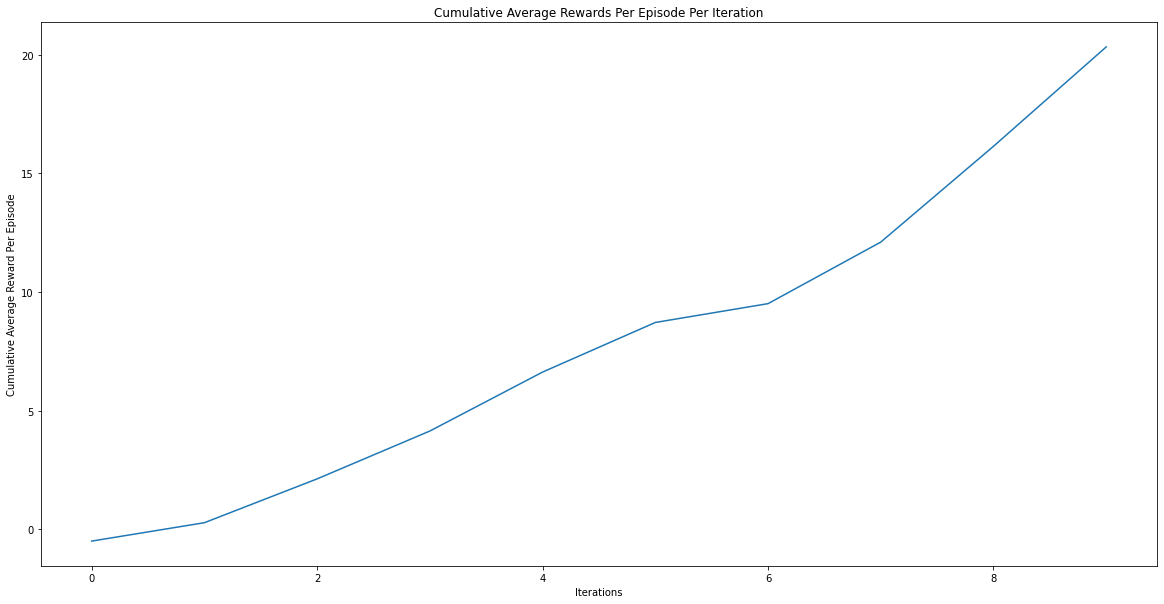

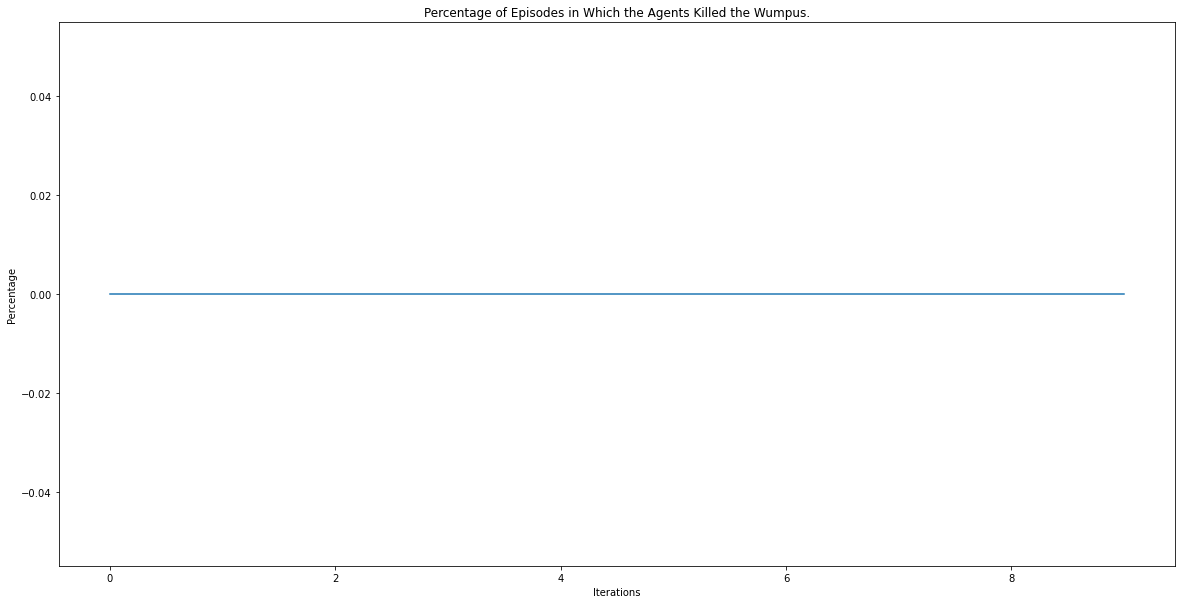


Evaluation of agent's performance across 100 episodes:
Average number of steps taken per episode: 10.0
Average penalties incurred per episode: 1.11


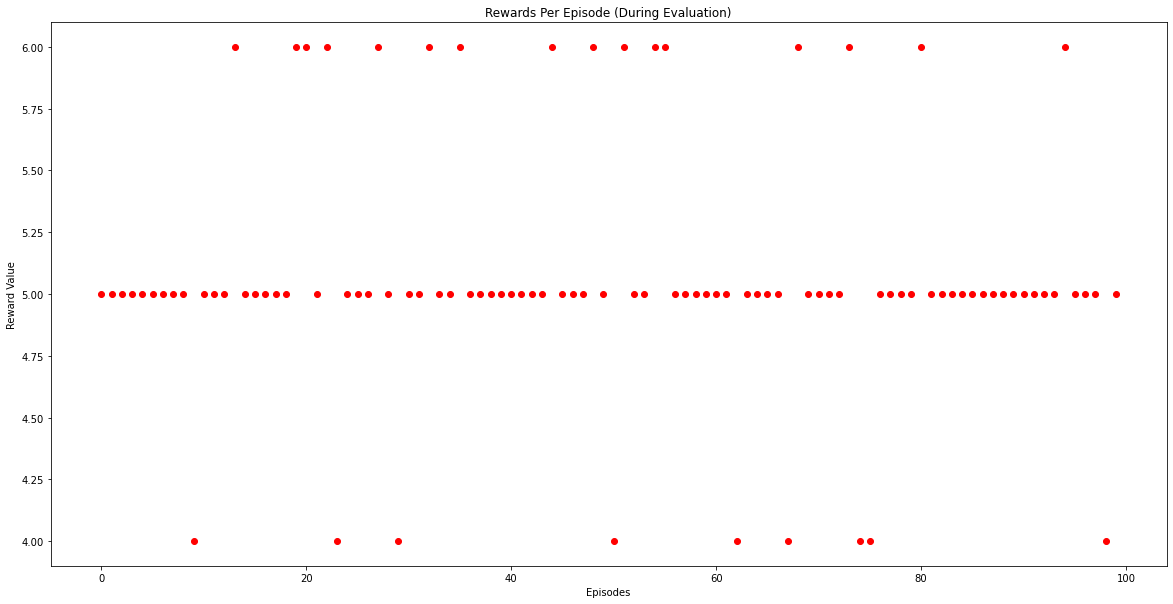

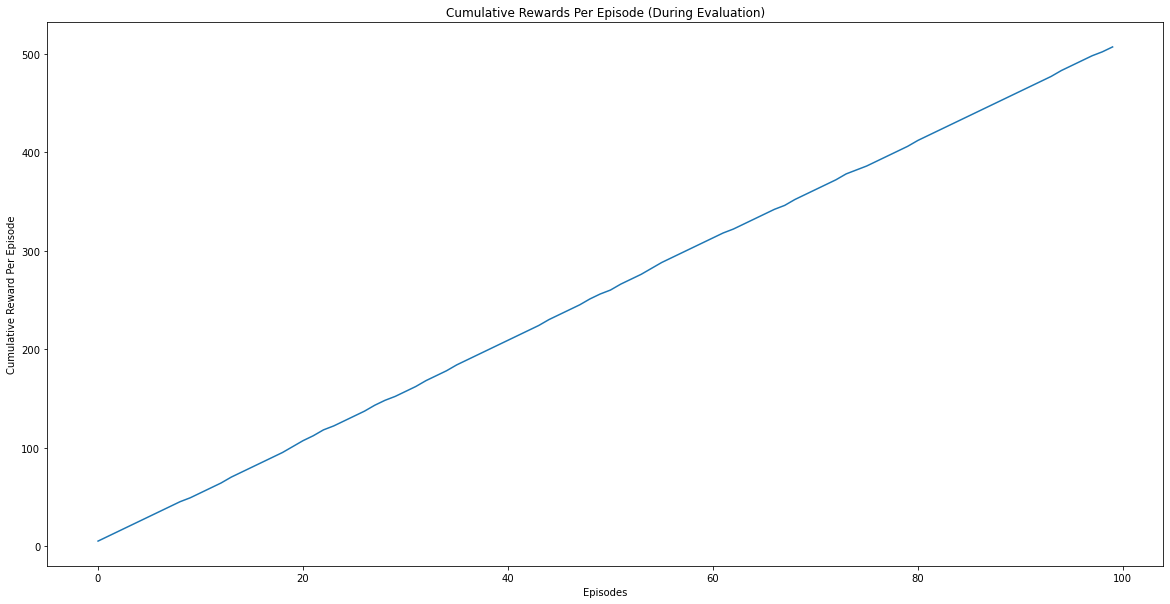

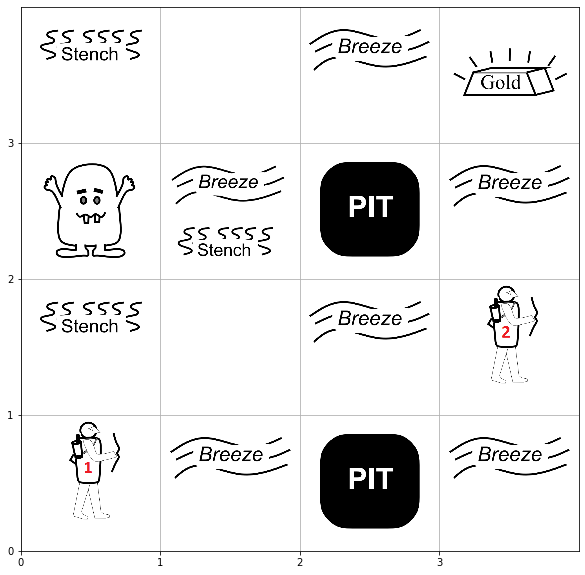

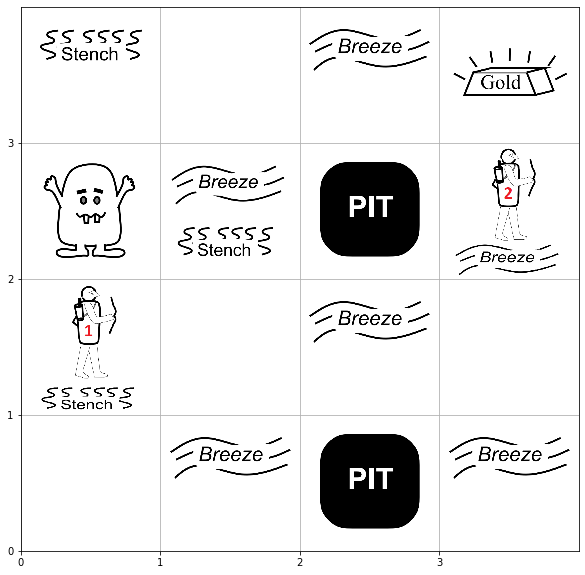

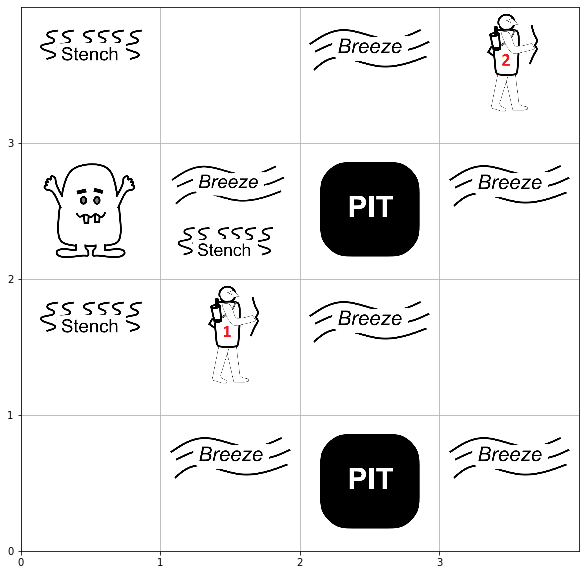

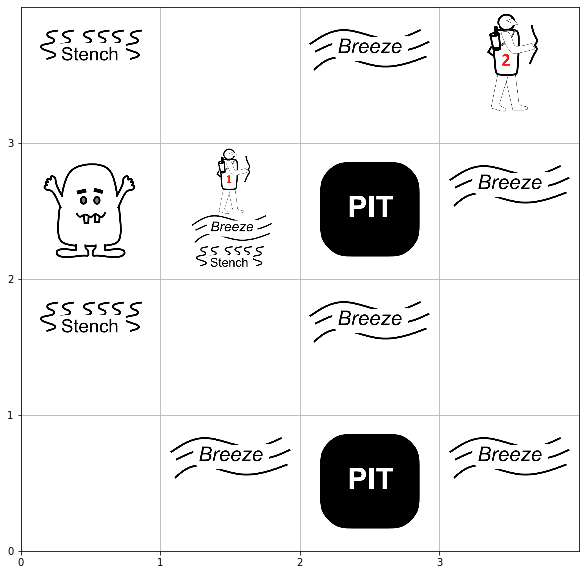

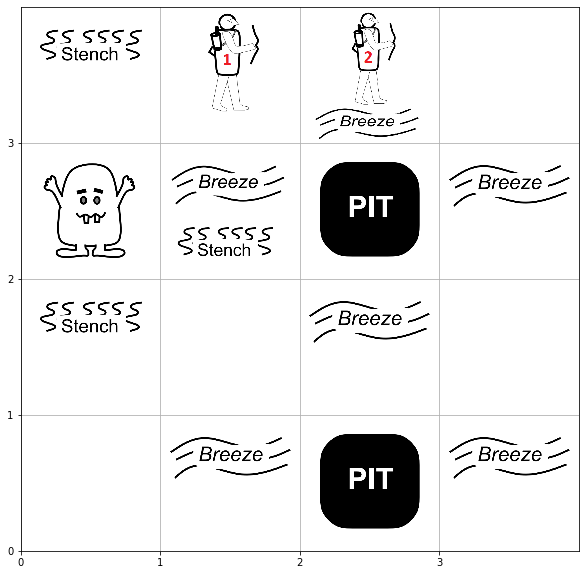

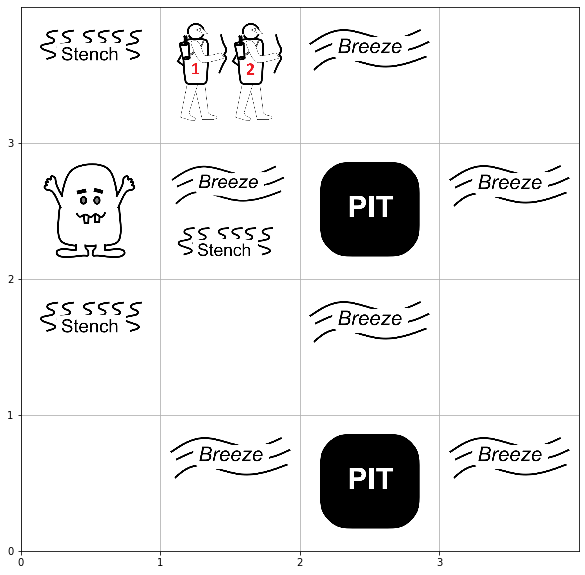

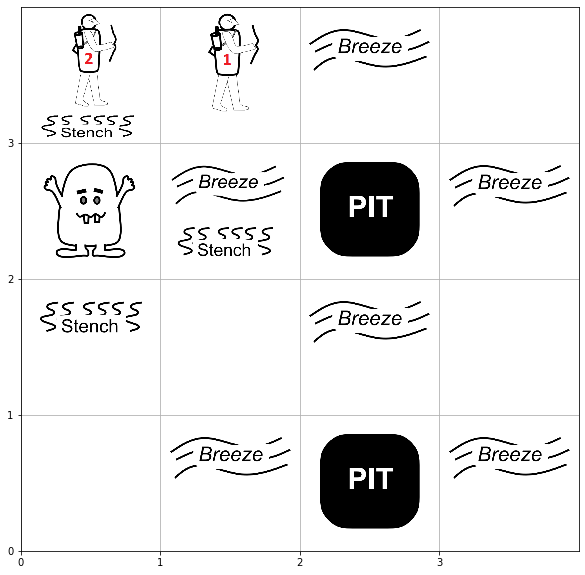

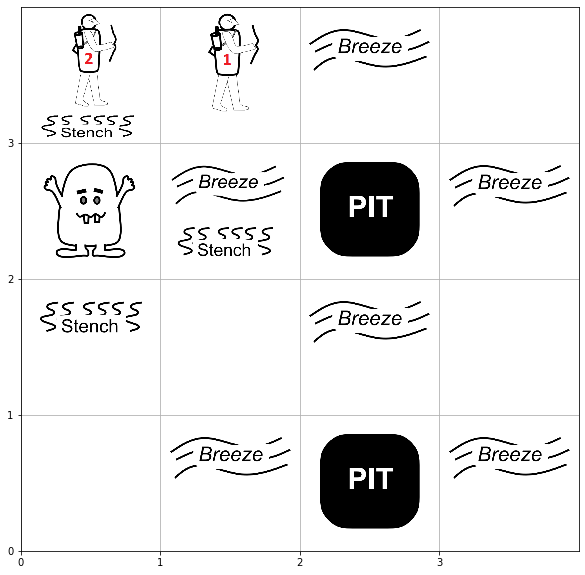

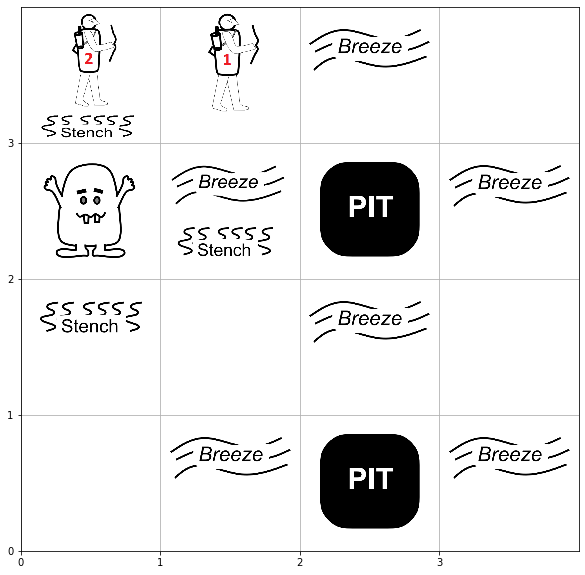

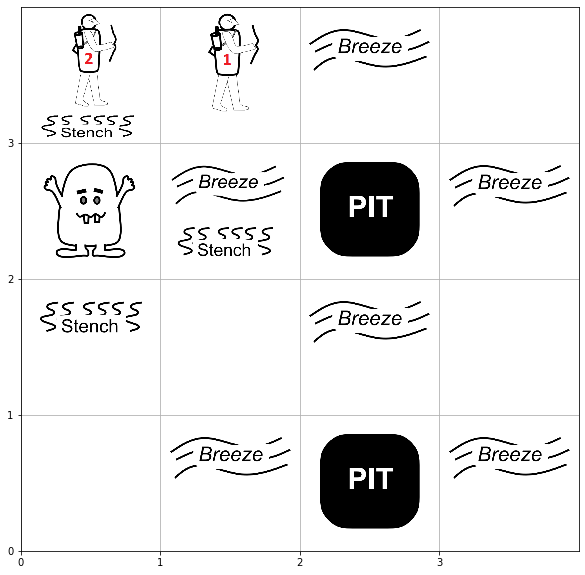

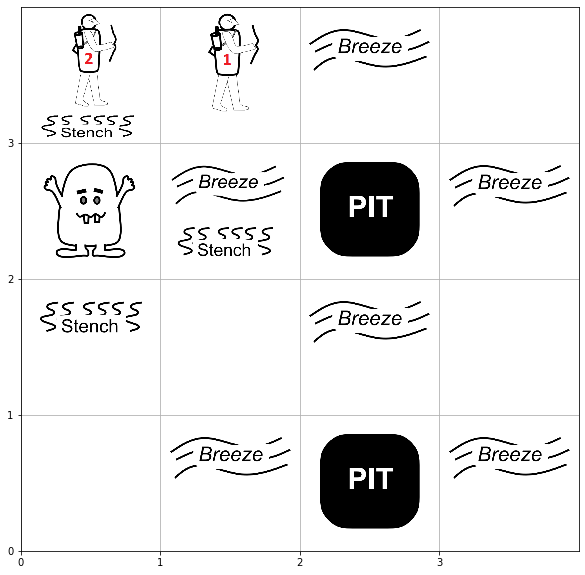

In [20]:
print('Version 3:\n')
AdvantageWeightedRegression(stochastic_multi_agent_wumpus_world_environment, alternate_network=True,
                            offline_memory_size=500, iterations=10)

### Open AI CartPole Environment

In [21]:
# Instantiating the CartPole environment.
cart_pole = gym.make('CartPole-v1')

c:\program files\python36\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [22]:
class AdvantageWeightedRegression:
    """This class implements the AWR Agent."""

    def __init__(self, environment,  alternate_network=False, offline_memory_size=10000, iterations=10):
        """This method initializes the AWR parameters, and calls the train, evaluate and render_actions methods.

        :param environment: This is the environment on which the agent will learn.
        :param alternate_network: Boolean indicating whether to use the second deeper network.
        :param offline_memory_size: Integer indicating the size of the offline replay memory.
        :param iterations: Number of iterations for which we will train."""

        self.environment = environment  # The environment which we need the agent to solve.
        self.alternate_network = alternate_network  # Boolean indicating whether to use the second deeper network.
        self.offline_replay_memory_size = offline_memory_size  # This specifies the length of the offline replay memory.
        self.offline_replay_memory = []  # Offline replay memory.
        self.iterations = iterations  # Number of episodes for which the agent will train.
        self.discount_factor = 0.99  # Discount factor determines the value of the future rewards.
        self.beta = 0.5  # Hyper-parameter used to calculate the exponential advantage.
        self.actor_model, self.critic_model, self.policy_model = self.neural_network()  # Creating the networks.
        self.cumulative_rewards_evaluation = []  # List containing the cumulative rewards per episode during evaluation.
        self.train()  # Calling the train method.
        self.evaluate()  # Calling the evaluate method.

    def neural_network(self):
        """This method builds the actor, critic and policy networks."""

        if not self.alternate_network:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.shape[0],))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common = Dense(128, activation='relu')(input_)  # Common layer for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common)  # Actor output.
            values = Dense(1, activation='linear')(common)  # Critic output.

        else:
            # Input 1 is the one-hot representation of the environment state.
            input_ = Input(shape=(self.environment.observation_space.shape[0],))
            # Input 2 is the exponential advantage.
            exponential_advantage = Input(shape=[1])
            common1 = Dense(512, activation='relu')(input_)  # Common layer 1 for the networks.
            common2 = Dense(256, activation='relu')(common1)  # Common layer 2 for the networks.
            common3 = Dense(128, activation='relu')(common2)  # Common layer 3 for the networks.
            probabilities = Dense(self.environment.action_space.n, activation='softmax')(common3)  # Actor output.
            values = Dense(1, activation='linear')(common3)  # Critic output.

        def custom_loss(exponential_advantage_):
            """This method defines the custom loss wrapper function that will be used by the actor model."""

            def loss_fn(y_true, y_pred):
                # Clipping y_pred so that we don't end up taking the log of 0 or 1.
                clipped_y_pred = k.clip(y_pred, 1e-8, 1 - 1e-8)
                log_probability = y_true * k.log(clipped_y_pred)
                return k.sum(-log_probability * exponential_advantage_)
            return loss_fn

        # Instantiating the actor model.
        actor_model = Model(inputs=[input_, exponential_advantage], outputs=[probabilities])
        actor_model.compile(optimizer=Adam(), loss=custom_loss(exponential_advantage))

        # Instantiating the critic model.
        critic_model = Model(inputs=[input_], outputs=[values])
        critic_model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber())

        # Instantiating the policy model.
        policy_model = Model(inputs=[input_], outputs=[probabilities])

        return actor_model, critic_model, policy_model

    def monte_carlo_returns(self):
        """This method calculates the Monte Carlo returns given a list of rewards."""

        rewards = [item[2] for item in self.offline_replay_memory]
        monte_carlo_returns = []  # List containing the Monte-Carlo returns.
        monte_carlo_return = 0
        t = 0  # Exponent by which the discount factor is raised.

        for i in range(len(self.offline_replay_memory)):

            while not self.offline_replay_memory[i][4]:  # Execute until you encounter a terminal state.

                # Equation to calculate the Monte-Carlo return.
                monte_carlo_return += self.discount_factor ** t * rewards[i]
                i += 1  # Go to the next sample.
                t += 1  # Increasing the exponent by which the discount factor is raised.

                # Condition to check whether we have reached the end of the replay memory without the episode being
                # terminated, and if so break. (This can happen with the samples at the end of the replay memory as we
                # only store the samples till we reach the replay memory size and not till we exceed it with the episode
                # being terminated.)
                if i == len(self.offline_replay_memory):

                    # If the episode hasn't terminated but you reach the end append the Monte-Carlo return to the list.
                    monte_carlo_returns.append(monte_carlo_return)

                    # Resetting the Monte-Carlo return value and the exponent to 0.
                    monte_carlo_return = 0
                    t = 0

                    break  # Break from the loop.

            # If for one of the samples towards the end we reach the end of the replay memory and it hasn't terminated,
            # we will go back to the beginning of the for loop to calculate the Monte-Carlo return for the future
            # samples if any for whom the episode hasn't terminated.
            if i == len(self.offline_replay_memory):
                continue

            # Equation to calculate the Monte-Carlo return.
            monte_carlo_return += self.discount_factor ** t * rewards[i]

            # Appending the Monte-Carlo Return for cases where the episode terminates without reaching the end of the
            # replay memory.
            monte_carlo_returns.append(monte_carlo_return)

            # Resetting the Monte-Carlo return value and the exponent to 0.
            monte_carlo_return = 0
            t = 0

        # Normalizing the returns.
        monte_carlo_returns = np.array(monte_carlo_returns)
        monte_carlo_returns = (monte_carlo_returns - np.mean(monte_carlo_returns)) / (np.std(monte_carlo_returns)
                                                                                      + 1e-08)
        monte_carlo_returns = monte_carlo_returns.tolist()

        return monte_carlo_returns

    def replay(self):
        """This is the replay method, that is used to fit the actor and critic networks and synchronize the weights
            between the actor and policy networks."""

        states = [item[0] for item in self.offline_replay_memory]
        states = np.asarray(states).reshape(-1, self.environment.observation_space.shape[0])

        actions = [tf.keras.utils.to_categorical(item[1], self.environment.action_space.n).tolist()
                   for item in self.offline_replay_memory]

        monte_carlo_returns = self.monte_carlo_returns()

        critic_values = self.critic_model.predict(states).flatten()

        exponential_advantages = [np.exp(1/self.beta * (monte_carlo_returns[i] - critic_values[i]))
                      for i in range(len(self.offline_replay_memory))]

        # Fitting the actor model.
        self.actor_model.fit([states, np.asarray(exponential_advantages)], np.asarray(actions),
                             batch_size=16, epochs=1, verbose=0)

        # Syncing the weights between the actor and policy models.
        self.policy_model.set_weights(self.actor_model.get_weights())

        # Fitting the critic model.
        self.critic_model.fit(states, np.asarray(monte_carlo_returns), batch_size=16, epochs=1, verbose=0)

    def train(self):
        """This method performs the agent training."""

        average_reward_per_episode_per_iteration = []
        cumulative_average_rewards_per_episode_per_iteration = []
        max_reward_reached_list = []  # List containing the percentage of episodes in which the agent balanced the pole
                                      # for 500 time-steps per iteration.

        for iteration in range(self.iterations):

            self.offline_replay_memory = []  # Resetting the replay memory to be empty.
            total_reward_iteration = 0  # Total reward acquired in this iteration.
            max_reward_reached = 0  # Initializing the counter for number of episodes in which the agent reached the
                                    # maximum reward to be 0.
            episodes = 0  # Initializing the counter for number of episodes in this iteration to be 0.

            while len(self.offline_replay_memory) < self.offline_replay_memory_size:

                # Resetting the environment and starting from a random position.
                state = self.environment.reset()
                done = False  # Initializing the done parameter which indicates whether the environment has terminated
                              # or not to False.
                reward_episode = 0
                episodes += 1  # Increasing the number of episodes in this iteration.

                while not done:
                    # Selecting an action according to the predicted action probabilities.
                    action_probabilities = (self.policy_model.predict(
                        np.asarray(state).reshape(-1, self.environment.observation_space.shape[0]))[0])
                    action = np.random.choice(self.environment.action_space.n, p=action_probabilities)

                    # Taking an action.
                    next_state, reward, done, info = self.environment.step(action)

                    # Incrementing the reward acquired in this episode.
                    reward_episode += reward

                    # Incrementing the total reward.
                    total_reward_iteration += reward

                    # Incrementing the Gold counter when the agent reaches the Gold.
                    if reward_episode == 500:
                        max_reward_reached += 1

                    # Appending the state, action, reward, next state and done to the replay memory.
                    self.offline_replay_memory.append([state, action, reward, next_state, done])

                    state = next_state  # Setting the current state to be equal to the next state.

                    # This condition ensures that we don't append more values than the size of the replay memory.
                    if len(self.offline_replay_memory) == self.offline_replay_memory_size:
                        break

            # Calculating the average reward per episode for this iteration.
            average_reward_per_episode = total_reward_iteration / episodes
            average_reward_per_episode_per_iteration.append(average_reward_per_episode)

            # Appending the cumulative reward.
            if len(cumulative_average_rewards_per_episode_per_iteration) == 0:
                cumulative_average_rewards_per_episode_per_iteration.append(average_reward_per_episode)
            else:
                cumulative_average_rewards_per_episode_per_iteration.append(
                    average_reward_per_episode + cumulative_average_rewards_per_episode_per_iteration[
                        iteration - 1])

            # Calculating the percentage of episodes in which the agent reached the maximum reward.
            percentage_max_reward_reached = max_reward_reached / episodes * 100
            max_reward_reached_list.append(percentage_max_reward_reached)

            # Calling the replay method.
            self.replay()

        # Calling the plots method to plot the reward dynamics.
        self.plots(average_reward_per_episode_per_iteration, cumulative_average_rewards_per_episode_per_iteration,
                   max_reward_reached=max_reward_reached_list, plot_max_reward_reached=True, plot_rolling_mean=False,
                   iterations=True)

    def evaluate(self):
        """This method evaluates the performance of the agent after it has finished training."""

        episodes = 100  # Number of episodes for which we are going to test the agent's performance.
        rewards_per_episode = []  # Sum of immediate rewards during the episode.
        rolling_mean_rewards = []  # Rolling mean of rewards per episode computed over 10 episodes.

        for episode in range(episodes):
            state = self.environment.reset()  # Resetting the environment for every new episode.
            done = False  # Initializing the done parameter indicating the episode termination to be False.
            total_reward_episode = 0  # Initializing the total reward acquired in this episode to be 0.

            while not done:
                self.environment.render()
                # Always choosing the greedy action.
                action = np.argmax(self.policy_model.predict(
                    np.asarray(state).reshape(-1, self.environment.observation_space.shape[0]))[0])

                # Taking the greedy action.
                next_state, reward, done, info = self.environment.step(action)

                total_reward_episode += reward  # Adding the reward acquired on this step to the total reward acquired
                                                # during the episode.

                state = next_state  # Setting the current state to the next state.

            rewards_per_episode.append(total_reward_episode)  # Appending the reward acquired during the episode.

            # Appending the cumulative reward.
            if len(self.cumulative_rewards_evaluation) == 0:
                self.cumulative_rewards_evaluation.append(total_reward_episode)
            else:
                self.cumulative_rewards_evaluation.append(
                    total_reward_episode + self.cumulative_rewards_evaluation[episode - 1])

            # Rolling mean.
            if len(rewards_per_episode) > 9:
                rolling_mean_rewards.append(np.mean(rewards_per_episode[-10:]))

        # Printing some statistics after the evaluation of agent's performance is completed.
        print(f"\nEvaluation of agent's performance across {episodes} episodes:")
        print(f"Average reward per episode: {self.cumulative_rewards_evaluation[-1] / episodes}")

        # Calling the plots method to plot the reward dynamics.
        self.plots(rewards_per_episode, self.cumulative_rewards_evaluation, rolling_mean_rewards)

    @staticmethod
    def plots(rewards_per_episode, cumulative_rewards, rolling_mean=None, plot_rolling_mean=True,
              max_reward_reached=None, plot_max_reward_reached=False, iterations=False):
        """This method plots the reward dynamics and epsilon decay.

        :param plot_rolling_mean: Boolean indicating whether or not to plot rolling_mean.
        :param plot_max_reward_reached: Boolean indicating whether or not to plot max_reward_reached.
        :param max_reward_reached: List containing the percentage of episodes in which the agent balanced the pole
                                   for the maximum time-steps.
        :param iterations: Boolean indicating that we are plotting for iterations and not episodes.
        :param rewards_per_episode: List containing the reward values per episode.
        :param cumulative_rewards: List containing the cumulative reward values per episode.
        :param rolling_mean: List containing the rolling mean reward values computed over 10 episodes."""

        plt.figure(figsize=(20, 10))
        plt.plot(rewards_per_episode, 'ro')
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Average Reward Per Episode')
            plt.title('Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rewards Per Episode (During Evaluation)')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.plot(cumulative_rewards)
        if iterations:
            plt.xlabel('Iterations')
            plt.ylabel('Cumulative Average Reward Per Episode')
            plt.title('Cumulative Average Rewards Per Episode Per Iteration')
        else:
            plt.xlabel('Episodes')
            plt.ylabel('Cumulative Reward Per Episode')
            plt.title('Cumulative Rewards Per Episode (During Evaluation)')
        plt.show()

        if plot_rolling_mean:
            # Plotting the Rolling mean.
            plt.figure(figsize=(20, 10))
            plt.plot(rolling_mean)
            plt.xlabel('Episodes')
            plt.ylabel('Reward Value')
            plt.title('Rolling Mean Rewards Per Episode')
            plt.show()

        if plot_max_reward_reached:
            plt.figure(figsize=(20, 10))
            plt.plot(max_reward_reached)
            plt.xlabel('Iterations')
            plt.ylabel('Percentage')
            plt.title('Percentage of Episodes in Which the Agent Reached the Maximum Reward.')
            plt.show()

Version 1:



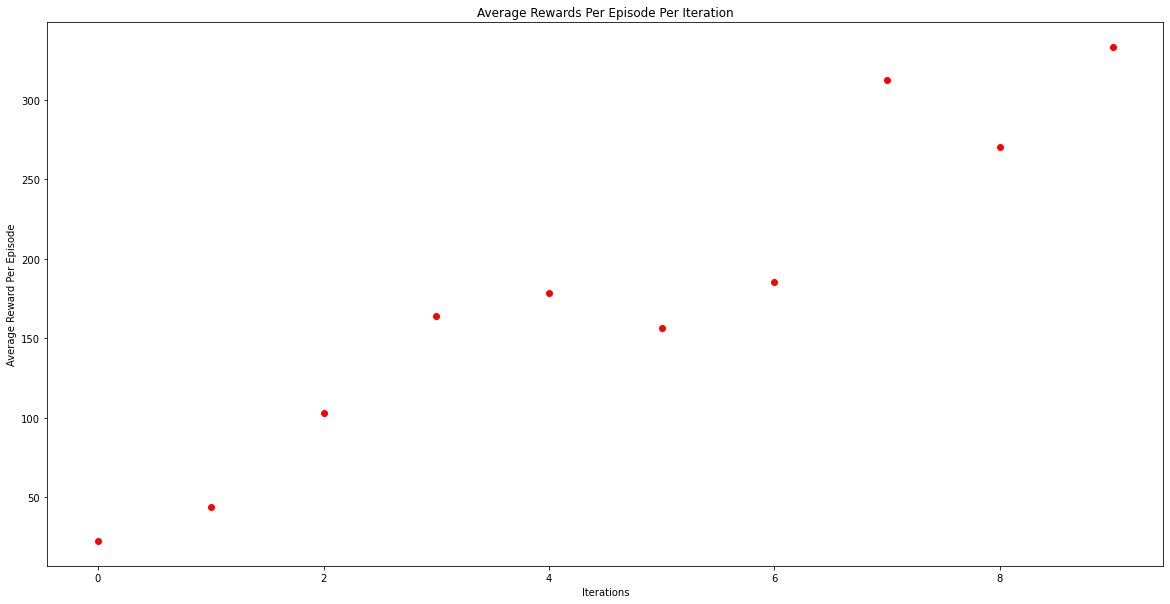

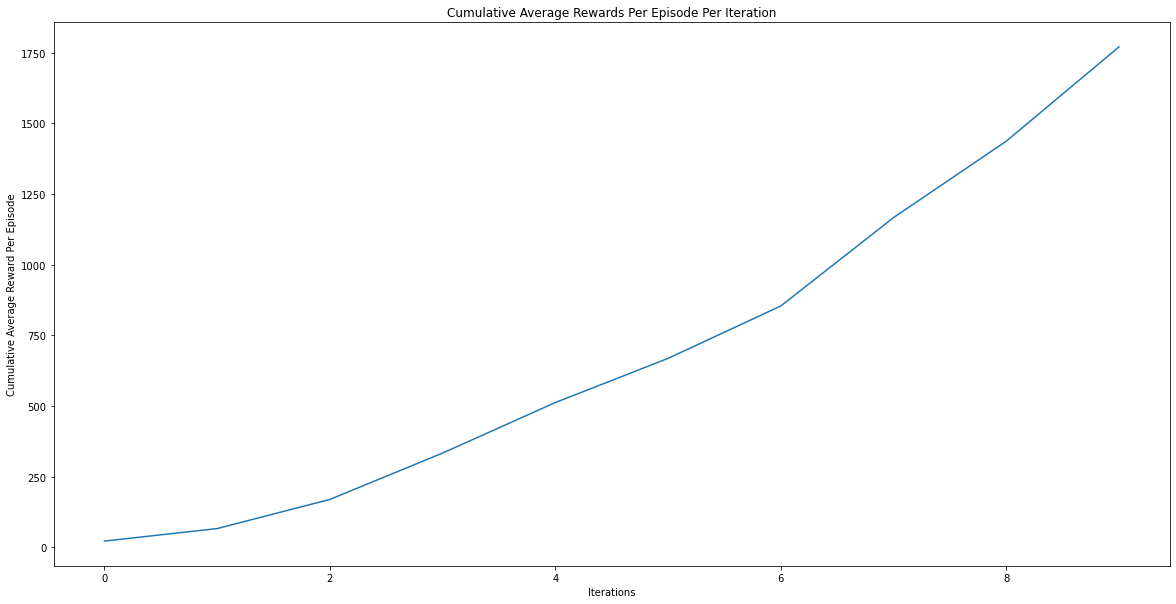

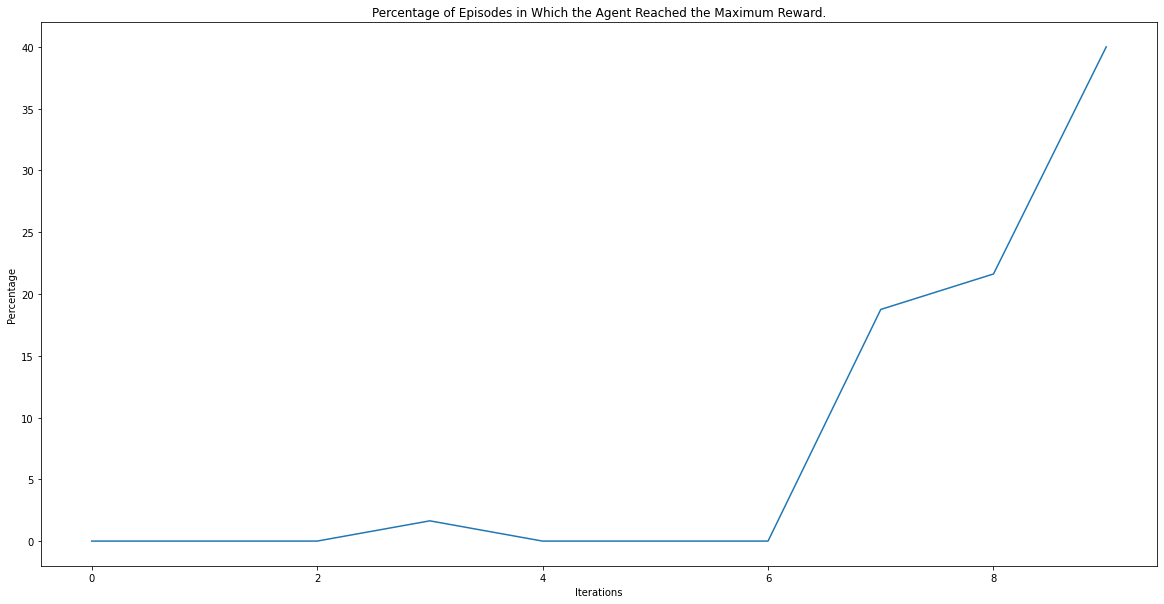


Evaluation of agent's performance across 100 episodes:
Average reward per episode: 500.0


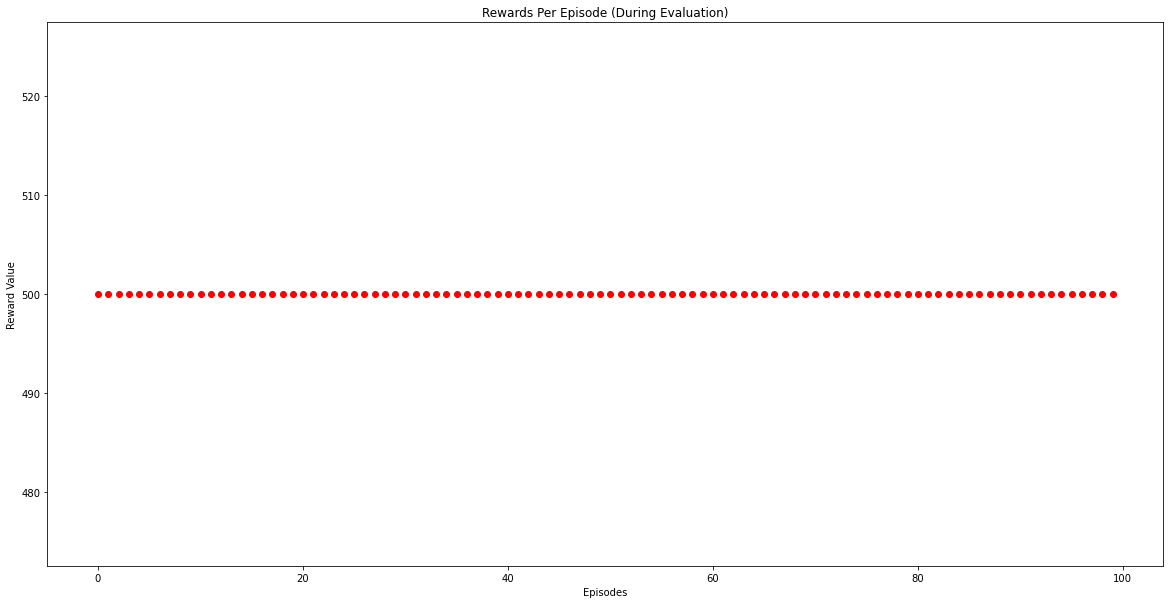

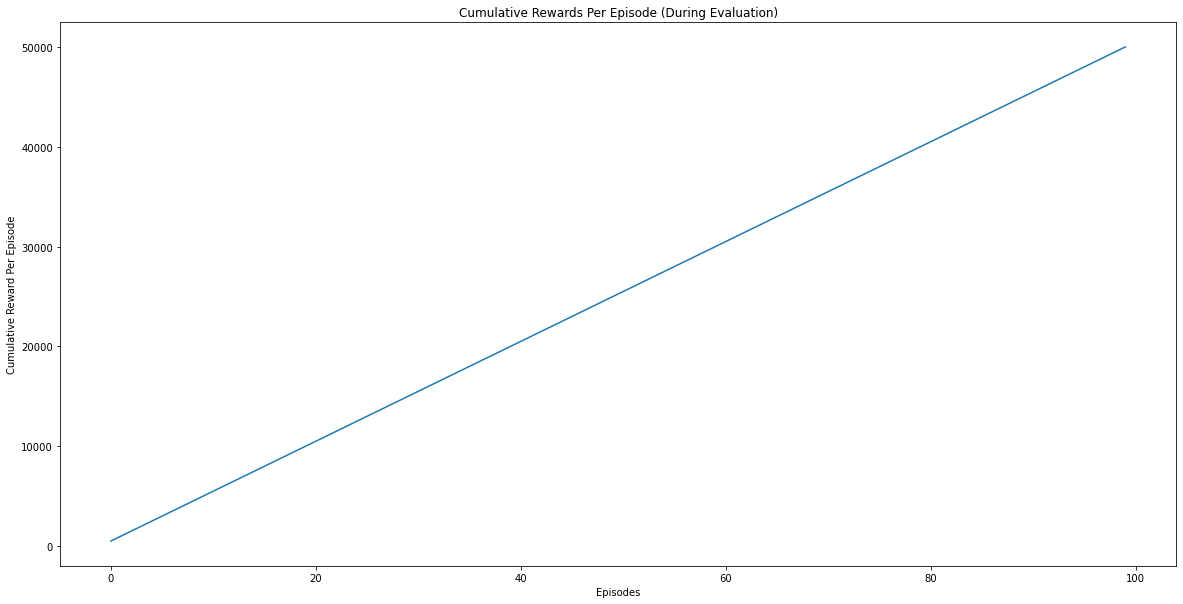

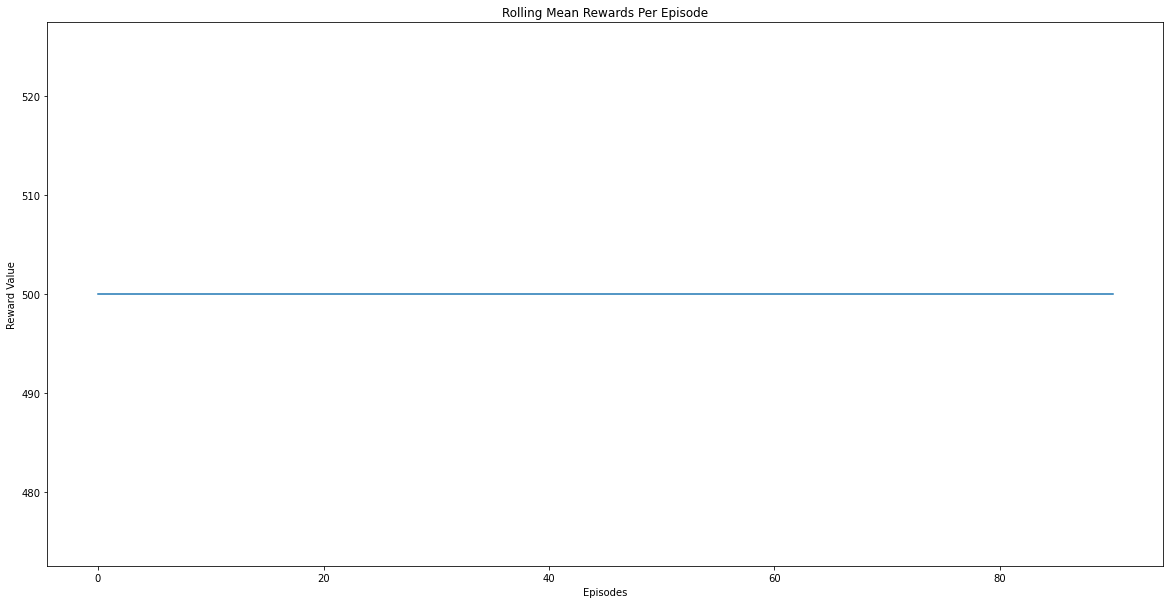

In [23]:
print('Version 1:\n')
AdvantageWeightedRegression(cart_pole, alternate_network=False, offline_memory_size=10000,
                            iterations=10)

Version 2:



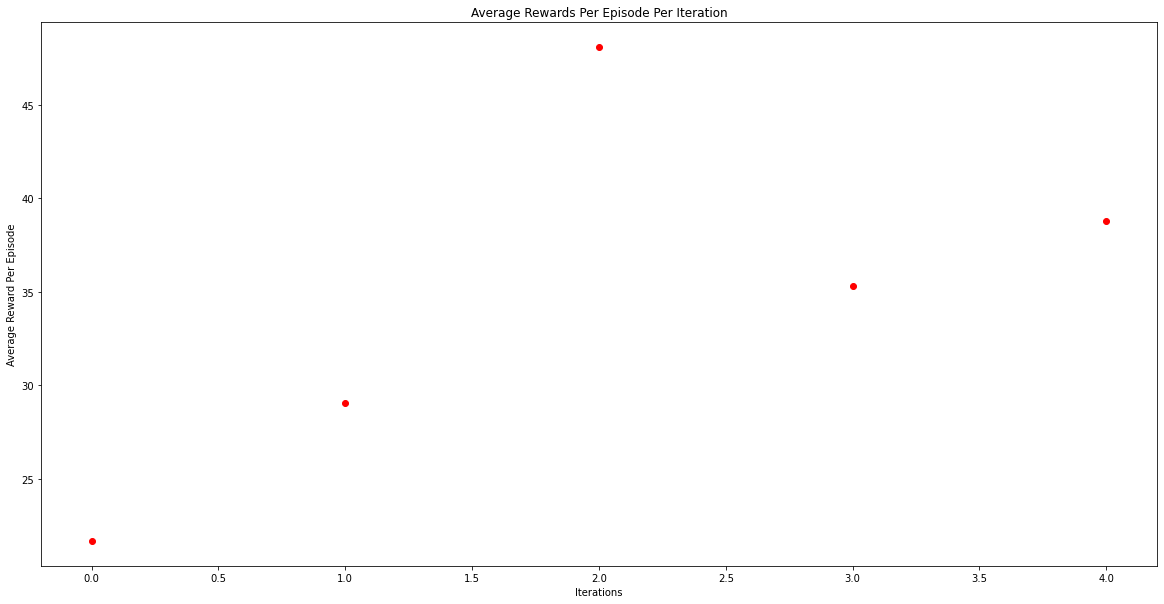

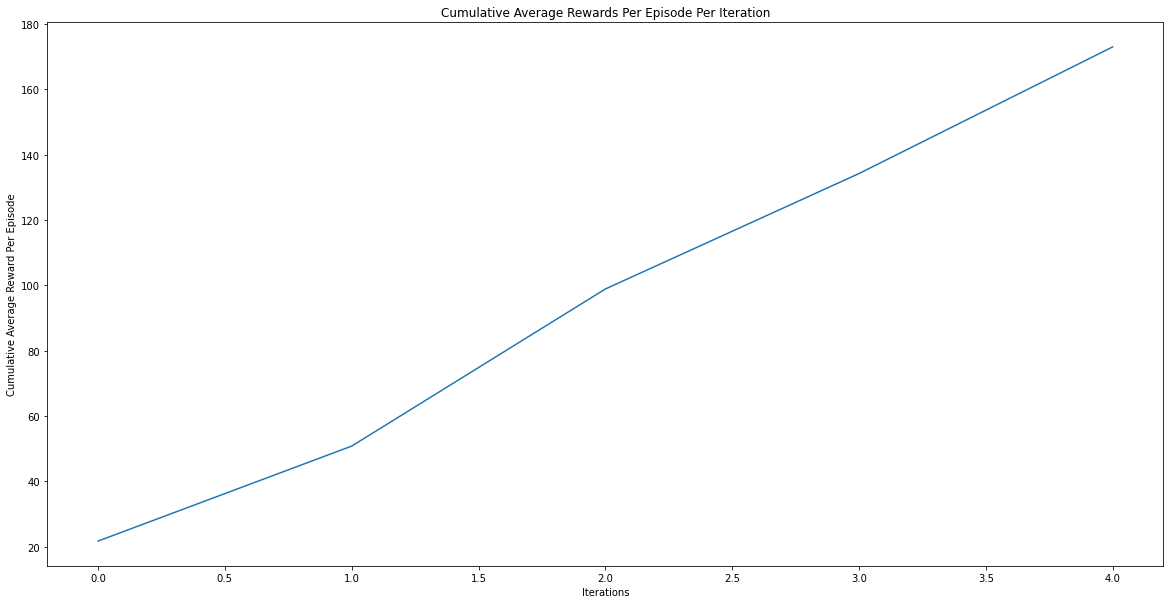

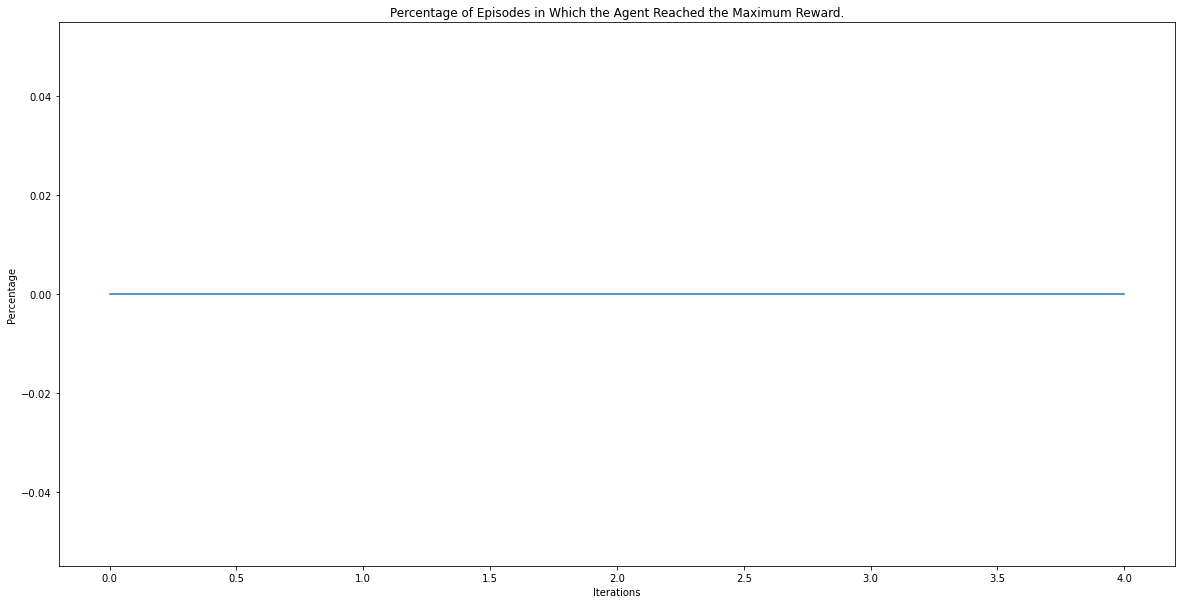


Evaluation of agent's performance across 100 episodes:
Average reward per episode: 498.26


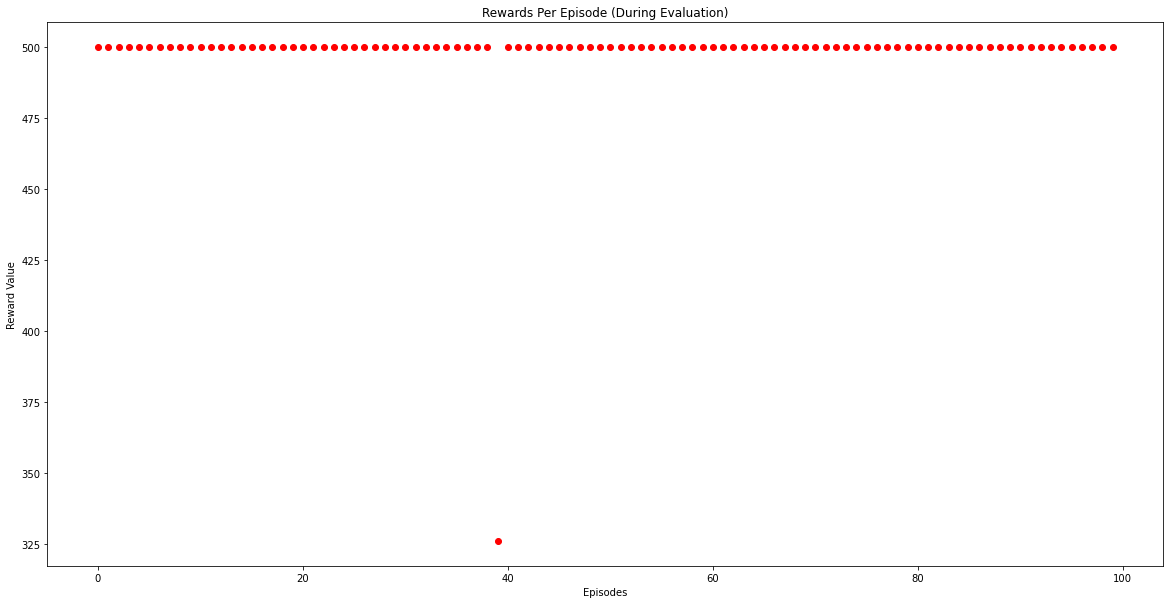

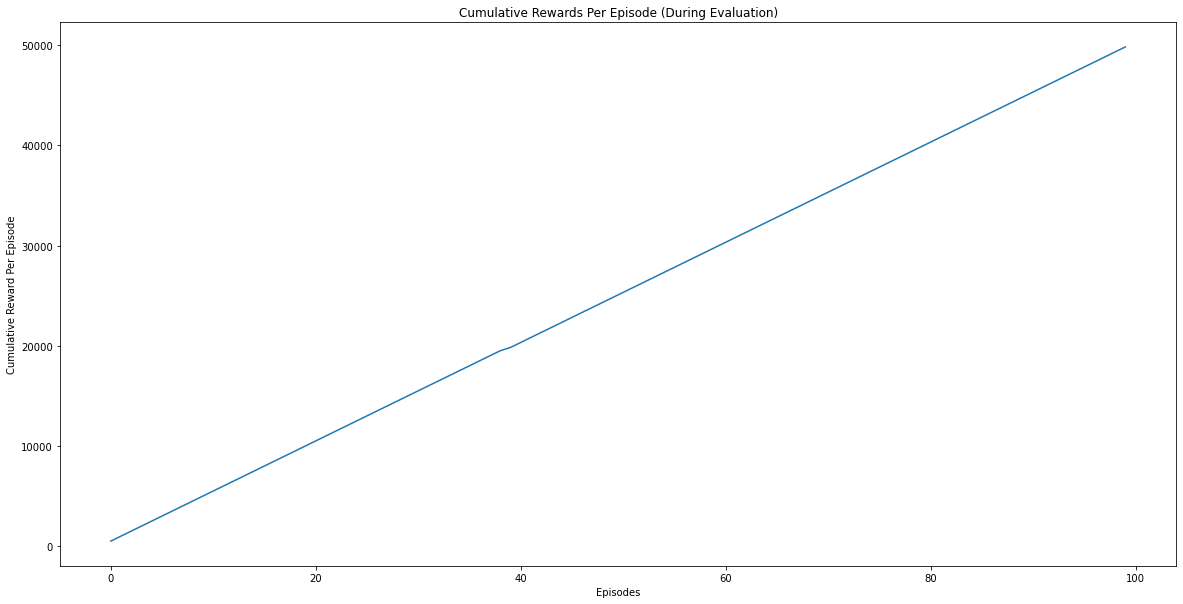

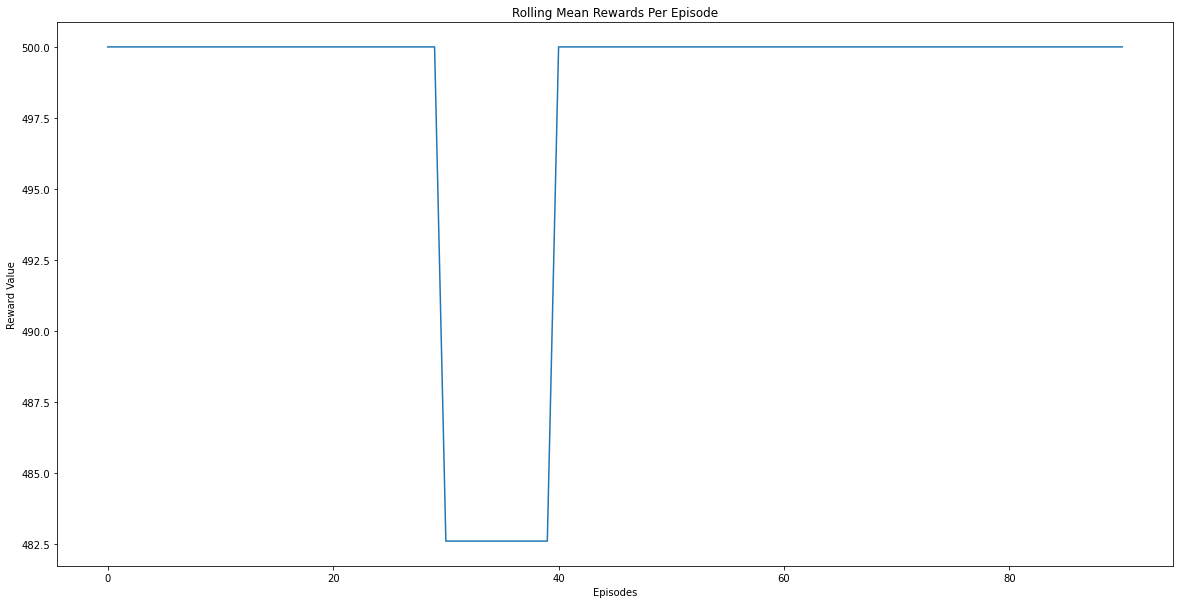

In [24]:
print('Version 2:\n')
AdvantageWeightedRegression(cart_pole, alternate_network=True, offline_memory_size=10000,
                            iterations=5)

Version 3:



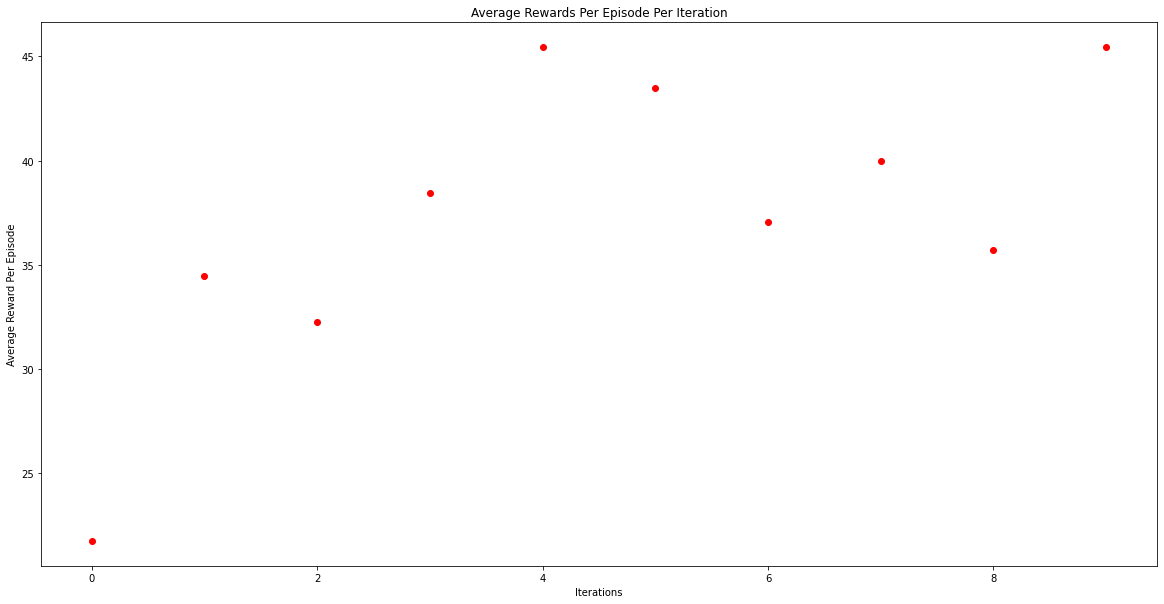

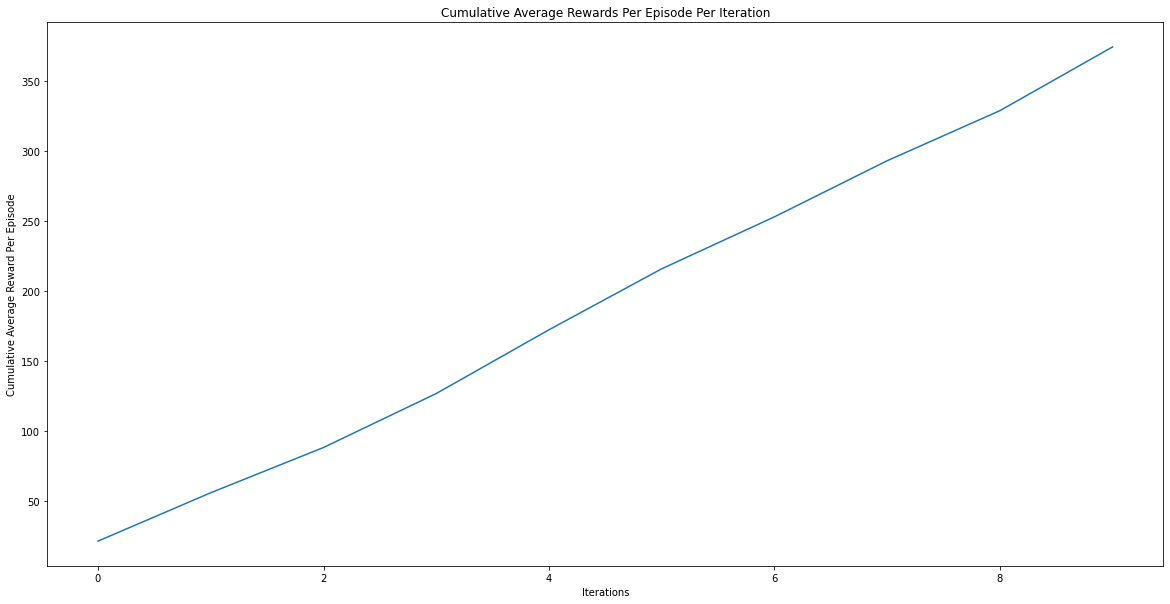

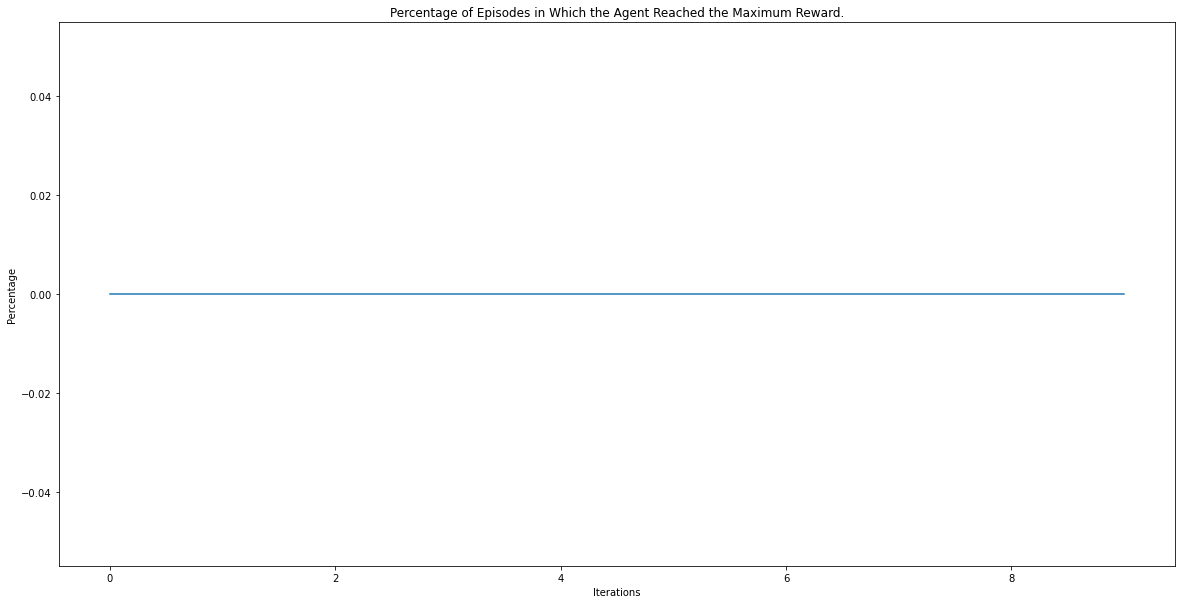


Evaluation of agent's performance across 100 episodes:
Average reward per episode: 405.98


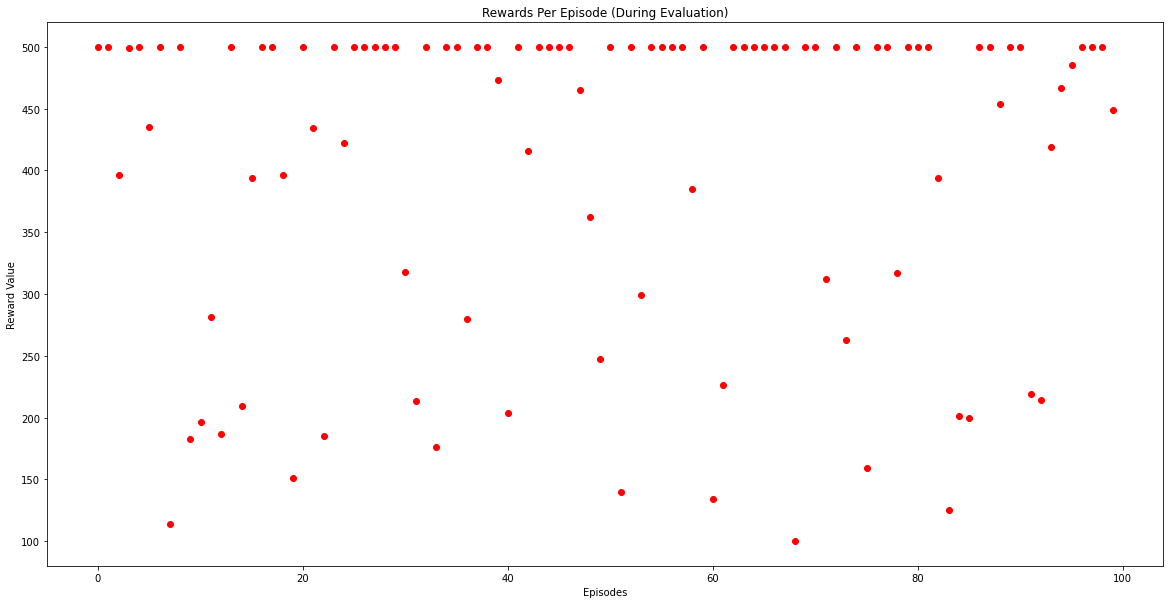

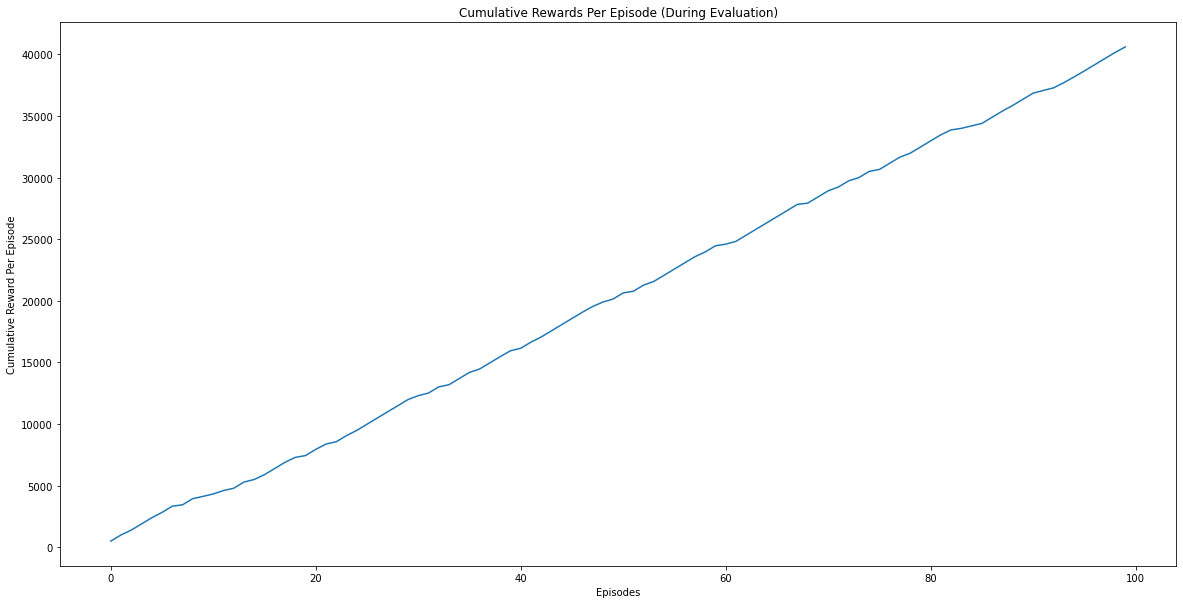

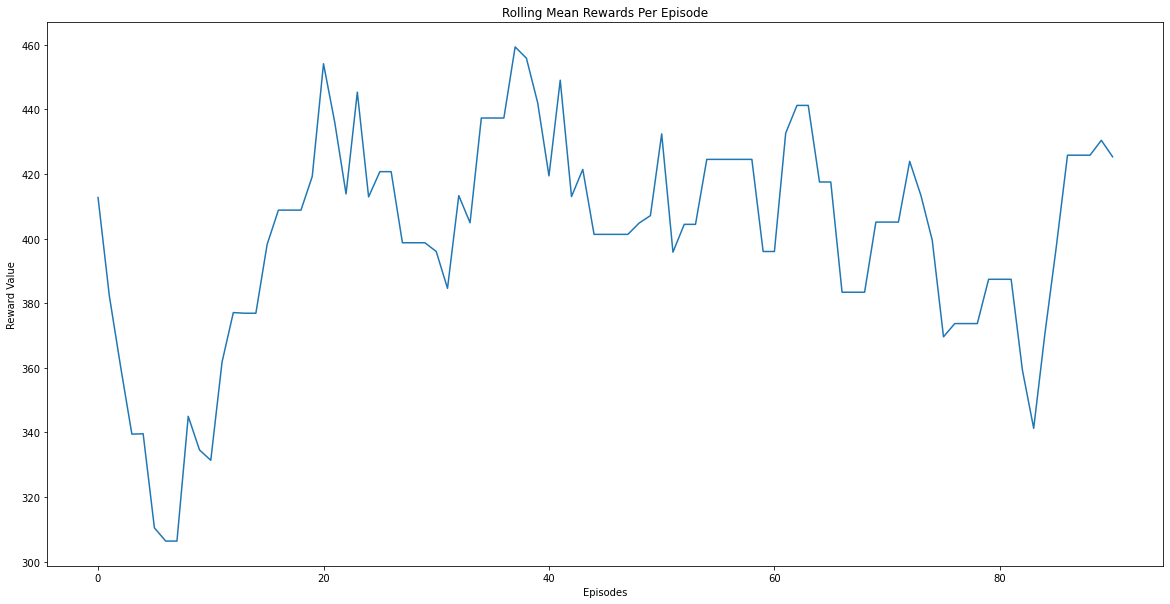

In [25]:
print('Version 3:\n')
AdvantageWeightedRegression(cart_pole, alternate_network=False, offline_mesmory_size=1000,
                            iterations=10)